In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

In [2]:
def id(x):
    return x

function = type(id)

In [3]:
def int_01(f, N=None):
    if N is None:
        N = len(f) - 1
    return (f.sum() - f[0] / 2 - f[-1] / 2) / N

def norm(f, N=None):
    if N is None:
        N = len(f) - 1
    return np.sqrt(int_01(f**2, N))

def sqal(f, g, N=None):
    if N is None:
        N = len(f) - 1
    return int_01(f * g, N)

def expand(f, N):
    lf = len(f)
    if N % (lf - 1) != 0:
        raise ValueError("Function with length {} can't be expanded to length {}".format(lf, N))
    points_to_segment = N // (lf - 1)
    ef = np.zeros(N + 1)
    for i in range(lf):
        ef[points_to_segment * i] = f[i]
    for i in range(lf - 1):
        left = f[i]
        right = f[i + 1]
        for j in range(1, points_to_segment):
            ef[points_to_segment * i + j] = (left * (points_to_segment - j) + right * j) / points_to_segment
    return ef

def cut(f, N):
    lf = len(f)
    if (lf - 1) % N != 0:
        raise ValueError("Function with length {} can't be cut to length {}".format(N, lf))
    points_to_segment = (lf - 1) // N
    ef = np.zeros(N + 1)
    for i in range(N + 1):
        ef[i] = f[points_to_segment * i]
    return ef

In [4]:
def get_A(k, N):
    hm1 = N
    hm2 = N ** 2
    coef = k**2 - hm2 * 4
    m = (N + 1) ** 2
    A = np.zeros((m, m), dtype=float)
    line = 0
    for i in range(1, N):
        for j in range(1, N):
            A[line, (i - 1) * (N + 1) + j] = hm2
            A[line, (i + 1) * (N + 1) + j] = hm2
            A[line, i * (N + 1) + j - 1] = hm2
            A[line, i * (N + 1) + j + 1] = hm2
            A[line, i * (N + 1) + j] = coef
            line += 1
    for j in range(1, N):
        A[line, N * (N + 1) + j] = 1
        line += 1    
    for j in range(1, N):
        A[line, j] = -hm1
        A[line, N + 1 + j] = hm1
        line += 1
    for i in range(N + 1):
        A[line, i * (N + 1)] = 1
        line += 1
    for i in range(N + 1):
        A[line, i * (N + 1) + N] = 1
        line += 1
    return A


def get_b(v1, vx0, N):
    if type(v1) == function:
        v1 = np.array([0.0] + [v1(j / N) for j in range(1, N)] + [0.0])
    elif len(v1) > N:
        v1 = cut(v1, N)
    elif len(v1) < N:
        v1 = expand(v1, N)
    if isinstance(vx0, function):
        vx0 = np.array([0.0] + [vx0(j / N) for j in range(1, N)] + [0.0])
    elif len(vx0) > N:
        vx0 = cut(vx0, N)
    elif len(v1) < N:
        vx0 = expand(vx0, N)
    b = np.zeros((N + 1) ** 2, dtype=float)
    line = (N - 1) ** 2
    for j in range(1, N):
        b[line] = v1[j]
        line += 1    
    for j in range(1, N):
        b[line] = vx0[j]
        line += 1
    return b

In [5]:
class Oracle:
    def __init__(self, f, g, k, N_func, N_grid):
        if type(f) == function:
            self.f = np.array([0.0] + [f(j / N_func) for j in range(1, N_func)] + [0.0])
        else:
            self.f = f
        if type(g) == function:
            self.g = np.array([0.0] + [g(j / N_func) for j in range(1, N_func)] + [0.0])
        else:
            self.g = g
        self.A = get_A(k, N_grid)
        self.N_func = N_func
        self.N_grid = N_grid
    
    def GH(self, v1, vx0):
        b = get_b(v1, vx0, self.N_grid)
        vect = np.linalg.solve(self.A, b)
        v = np.zeros((self.N_grid + 1, self.N_grid + 1), dtype=float)
        for i in range(self.N_grid + 1):
            for j in range(self.N_grid + 1):
                v[i, j] = vect[i * (self.N_grid + 1) + j]
        return v

    def func_grad(self, q):
        u = self.GH(q, self.g)
        la = expand(u[0, :], self.N_func) - self.f
        psi = self.GH(np.zeros(self.N_grid + 1), la)
        grad = expand((psi[-1, :] - psi[-2, :]) * self.N_grid, self.N_func)
        J = int_01(la ** 2, self.N_func) / 2
        return J, grad

In [6]:
class FirstOrderAlgorithmRunner:
    """
    Testing Method should return dict {
    'points': list of points,
    'grad_seq': list of gradient norm values,
    'func_seq': list of function values,
    'grad_count': total count of gradient calls,
    'func_count': total count of function calls}
    """
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.results = {}
        self.colors = ['b', 'r', 'g', 'y', 'c', 'm']

    def run_method(self, name, method, x0, func_grad, **parameters):
        time_start = time()
        result = method(x0, func_grad, self.verbose, **parameters)
        result['total_time'] = time() - time_start
        self.results[name] = result

    def plot_points(self, capture, n_start=0, n_finish=-1, range_=None, projection=(0, 1)):
        xc, yc = projection
        legend = []
        for color, key in zip(self.colors, self.results):
            if range_:
                points = [point for point in self.results[key]['points'][n_start:n_finish] 
                          if range_[0]<=point[xc]<=range_[1] and range_[0]<=point[yc]<=range_[1]]
            else:
                points = self.results[key]['points'][n_start:]                    
            xs = [point[xc] for point in points]
            ys = [point[yc] for point in points]
            plt.scatter(x=xs, y=ys, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        plt.xlabel('$x_{'+str(xc)+'}$')
        plt.ylabel('$x_{'+str(yc)+'}$')
        plt.title(capture)

    def plot_distance(self, capture, n_start=0, n_finish=-1, log=False, x_target=None):
        from_last = (x_target is None)
        color_idx = 0
        legend = []
        for color, key in zip(self.colors, self.results):
            if from_last:
                x_target = self.results[key]['points'][-1]
            dist = [norm(point - x_target) for point in self.results[key]['points'][n_start:n_finish]]
            if log:
                dist = [np.log10(abs(g)) for g in dist]
            plt.scatter(x=range(n_start, n_start + len(dist)), y=dist, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        plt.xlabel('$n$')
        if log:
            plt.ylabel(r'$\lg||\Delta x_n||$')
        else:
            plt.ylabel(r'$||\Delta x_n||$')
        plt.title(capture)

    def plot_grads(self, capture, n_start=0, n_finish=-1, log=False):
        legend = []
        for color, key in zip(self.colors, self.results):
            grad = self.results[key]['grad_seq'][n_start:n_finish]
            if log:
                grad = [np.log10(abs(g)) for g in grad]
            plt.scatter(x=range(n_start, n_start + len(grad)), y=grad, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        plt.xlabel('$n$')
        if log:
            plt.ylabel(r'$\lg||\nabla f(x_n)||$')
        else:
            plt.ylabel(r'$||\nabla f(x_n)||$')
        plt.title(capture)

    def plot_func(self, capture, n_start=0, n_finish=-1, log=False):
        color_idx = 0
        legend = []
        for color, key in zip(self.colors, self.results):
            fval = self.results[key]['func_seq'][n_start:n_finish]
            if log:
                fval = [np.log10(abs(g)) for g in fval]
            plt.scatter(x=range(n_start, n_start + len(fval)), y=fval, lw=1, marker='.', c=color, edgecolors=color)
            legend.append(key)
        plt.legend(legend)
        plt.xlabel('$n$')
        if log:
            plt.ylabel(r'$\lg|f(x_n)|$')
        else:
            plt.ylabel(r'$|f(x_n)|$')
        plt.title(capture)

    def print_data(self):
        for key in self.results:
            print("Experiment '{}': "
                  "total time {} seconds;\n"
                  "gradient called {} times, "
                  "function called {} times;\n"
                  "minimal gradient norm is {}, "
                  "minimal function value is {}".format(key,
                                                        self.results[key]['total_time'],
                                                        self.results[key]['grad_count'],
                                                        self.results[key]['func_count'],
                                                        min(self.results[key]['grad_seq']),
                                                        min(self.results[key]['func_seq'])))


In [7]:
def f(x):
    return 100 * (x - x ** 2)

def g(x):
    return 1000 * ((x - 0.5) ** 2 - (x - 0.5) ** 4 * 4)

In [19]:
def conjugate_grad_descent(x0, func_grad, verbose=True, alpha=1, N=1000, eps=1e-8):
    x, xvals, fvals, grads, ngrads, s = x0.copy().astype(np.float), [], [], [], [], []
    xvals.append(x)
    for i in range(N):
        f, g = func_grad(x)
        fvals.append(f)
        ng = norm(g, len(g) - 1)
        if verbose:
            print(i, f, ng)
        ngrads.append(ng)
        grads.append(g)
        if s:
            s.append(-g + s[-1] * sqal(g, g) / (sqal(grads[-2], grads[-2]) + eps))
        else:
            s.append(-g)
        x = x + s[-1] * alpha
        xvals.append(x)
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': N, 
            'func_count': N}

Эксперименты с h=0.1

In [20]:
x = np.arange(0.0, 1.0001, 0.0001)
oracle = Oracle(f(x), g(x), np.pi, 10000, 10)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('conjugate grad descent', conjugate_grad_descent, np.zeros(10001), oracle.func_grad, alpha=1, N=10000, eps=1e-8)

Выходные данные были обрезаны до нескольких последних строк (5000).
5000 1.6667628206171656 0.001254110557614159
5001 1.6665006229255215 0.0012539699648165304
5002 1.6662385357310916 0.0012538294187098835
5003 1.6659765640953745 0.0012536889223264442
5004 1.6657147165636983 0.001253548474659605
5005 1.6654529957154962 0.0012534080737586868
5006 1.665191395409016 0.0012532677227632659
5007 1.6649299074257222 0.0012531274199389353
5008 1.6646685300218393 0.0012529871640789422
5009 1.6644072699645418 0.001252846958199188
5010 1.664146134836212 0.0012527067999091328
5011 1.6638851250072817 0.0012525666888959417
5012 1.663624233001229 0.0012524266277847992
5013 1.6633634516241749 0.0012522866137978112
5014 1.6631027816066117 0.0012521466474418336
5015 1.6628422305665171 0.0012520067307714268
5016 1.6625818048651673 0.0012518668608394487
5017 1.662321502555492 0.0012517270389156342
5018 1.6620613153868558 0.0012515872663757138
5019 1.6618012377808111 0.0012514475402818934
5020 1.661541272720

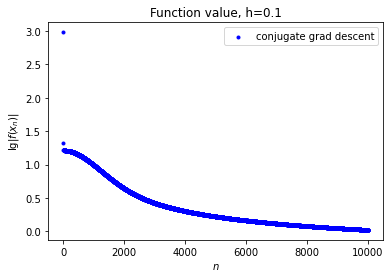

In [30]:
algrun.plot_func('Function value, h=0.1', log=True)

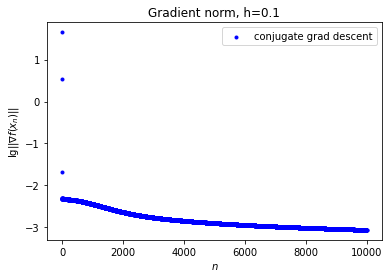

In [31]:
algrun.plot_grads('Gradient norm, h=0.1', log=True)

In [14]:
algrun.print_data()

Experiment 'conjugate grad descent': total time 569.8311541080475 seconds;
gradient called 10000 times, function called 10000 times;
minimal gradient norm is 0.0008627678584383965, minimal function value is 1.0470965650765525


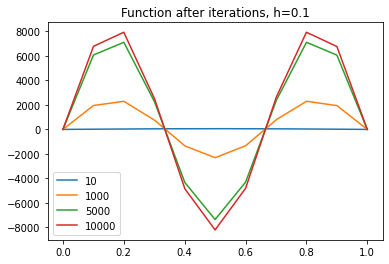

In [29]:
plt.title('Function after iterations, h=0.1')
plt.plot(x, algrun.results['conjugate grad descent']['points'][10], label='10')
plt.plot(x, algrun.results['conjugate grad descent']['points'][1000], label='1000')
plt.plot(x, algrun.results['conjugate grad descent']['points'][5000], label='5000')
plt.plot(x, algrun.results['conjugate grad descent']['points'][-1], label='10000')
plt.legend()

Эксперименты с h=0.05

In [32]:
x = np.arange(0.0, 1.0001, 0.0001)
oracle = Oracle(f(x), g(x), np.pi, 10000, 20)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('conjugate grad descent', conjugate_grad_descent, np.zeros(10001), oracle.func_grad, alpha=1, N=10000, eps=1e-8)

Выходные данные были обрезаны до нескольких последних строк (5000).
5000 7.516960845601652 0.0015633397292086186
5001 7.516352474119274 0.00156327320244077
5002 7.5157442073553 0.0015632066852093607
5003 7.5151360465145425 0.001563140176018093
5004 7.514527991112032 0.001563073675067941
5005 7.513920040011651 0.0015630071836143342
5006 7.513312192135464 0.0015629407001921801
5007 7.512704446902938 0.0015628742250570486
5008 7.512096806278533 0.0015628077593989181
5009 7.5114892716349395 0.0015627413017007983
5010 7.510881842283747 0.0015626748523737833
5011 7.510274516920679 0.0015626084124775233
5012 7.509667293885019 0.0015625419804530358
5013 7.509060174387648 0.0015624755569359963
5014 7.508453159215531 0.0015624091427879462
5015 7.5078462494819975 0.0015623427365029914
5016 7.507239444863172 0.0015622763387065641
5017 7.50663274416192 0.0015622099502765197
5018 7.506026146039585 0.0015621435696981107
5019 7.505419650818239 0.0015620771976793033
5020 7.504813259711165 0.00156201083

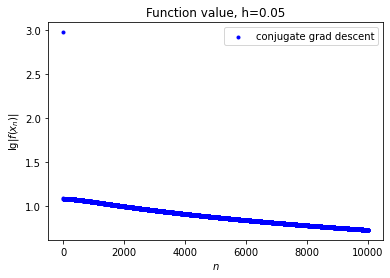

In [33]:
algrun.plot_func('Function value, h=0.05', log=True)

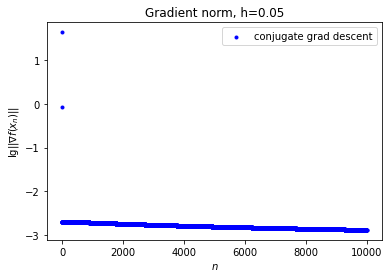

In [34]:
algrun.plot_grads('Gradient norm, h=0.05', log=True)

In [35]:
algrun.print_data()

Experiment 'conjugate grad descent': total time 708.6126112937927 seconds;
gradient called 10000 times, function called 10000 times;
minimal gradient norm is 0.001309896117461271, minimal function value is 5.386472511011387


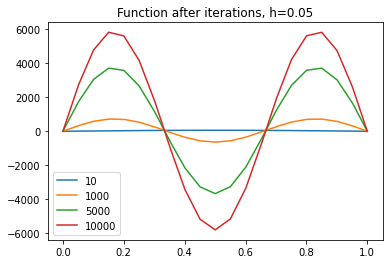

In [36]:
plt.title('Function after iterations, h=0.05')
plt.plot(x, algrun.results['conjugate grad descent']['points'][10], label='10')
plt.plot(x, algrun.results['conjugate grad descent']['points'][1000], label='1000')
plt.plot(x, algrun.results['conjugate grad descent']['points'][5000], label='5000')
plt.plot(x, algrun.results['conjugate grad descent']['points'][-1], label='10000')
plt.legend()

Эксперименты с h=0.02

In [37]:
x = np.arange(0.0, 1.0001, 0.0001)
oracle = Oracle(f(x), g(x), np.pi, 10000, 50)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('conjugate grad descent', conjugate_grad_descent, np.zeros(10001), oracle.func_grad, alpha=1, N=10000, eps=1e-8)

Выходные данные были обрезаны до нескольких последних строк (5000).
5000 8.401642323158553 0.0012574434297266497
5001 8.401389987079577 0.001257423952064452
5002 8.401137666411818 0.0012574044752928341
5003 8.40088536157837 0.0012573849994396342
5004 8.4006330723028 0.0012573655244858643
5005 8.4003807986733 0.0012573460504376425
5006 8.400128540571922 0.0012573265772887992
5007 8.399876298085161 0.0012573071050435449
5008 8.399624071190026 0.0012572876337008812
5009 8.399371860039203 0.001257268163271191
5010 8.399119664436878 0.0012572486937407253
5011 8.398867484508468 0.0012572292251175204
5012 8.398615320180516 0.0012572097573974425
5013 8.398363171264066 0.0012571902905702092
5014 8.39811103814266 0.0012571708246567343
5015 8.397858920465652 0.0012571513596380136
5016 8.397606818557735 0.0012571318955326295
5017 8.39735473225642 0.0012571124323303674
5018 8.39710266145637 0.0012570929700252988
5019 8.39685060629815 0.0012570735086264624
5020 8.39659856670003 0.0012570540481281942

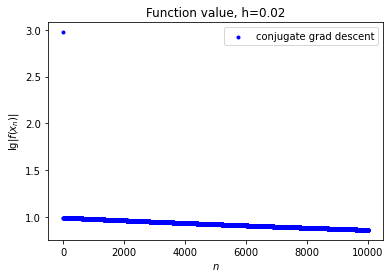

In [38]:
algrun.plot_func('Function value, h=0.02', log=True)

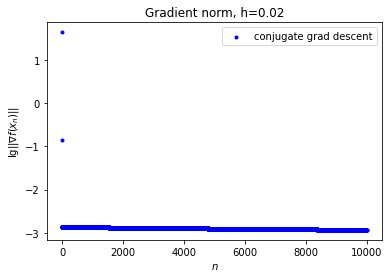

In [39]:
algrun.plot_grads('Gradient norm, h=0.02', log=True)

In [40]:
algrun.print_data()

Experiment 'conjugate grad descent': total time 10392.977093935013 seconds;
gradient called 10000 times, function called 10000 times;
minimal gradient norm is 0.0011700845538798257, minimal function value is 7.309179980173999


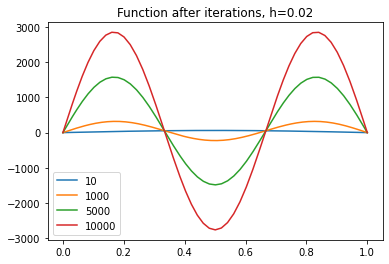

In [41]:
plt.title('Function after iterations, h=0.02')
plt.plot(x, algrun.results['conjugate grad descent']['points'][10], label='10')
plt.plot(x, algrun.results['conjugate grad descent']['points'][1000], label='1000')
plt.plot(x, algrun.results['conjugate grad descent']['points'][5000], label='5000')
plt.plot(x, algrun.results['conjugate grad descent']['points'][-1], label='10000')
plt.legend()

In [8]:
def STM(x0, func_grad, verbose=True, L=1, N=1000):
    A = [1/L]
    alpha = [1/L]

    x, xvals, fvals, grads, ngrads, tildaxs, tildagrads, zs = x0.copy().astype(np.float), [], [], [], [], [], [], []
    xvals.append(x)
    f, g = func_grad(xvals[0])
    fvals.append(f)
    ng = norm(g, len(g) - 1)
    if verbose:
        print(0, f, ng)
    ngrads.append(ng)
    grads.append(g)
    tildaxs.append(x)
    tildagrads.append(func_grad(x)[1])
    zs.append(x - tildagrads[0] * alpha[0])
    xvals.append(zs[0])
    f, g = func_grad(xvals[1])
    fvals.append(f)
    ng = norm(g, len(g) - 1)
    if verbose:
        print(0, f, ng)
    ngrads.append(ng)
    grads.append(g)
    for i in range(1, N + 1):
        alpha.append(0.5/L + np.sqrt(A[-1] + 0.25/L/L))
        A.append(A[-1] + alpha[-1])
        tildaxs.append((xvals[-1] * A[-2] + zs[-1] * alpha[-1]) / A[-1])
        tildagrads.append(func_grad(tildaxs[-1])[1])
        zs.append(zs[-1] - tildagrads[-1] * alpha[-1])
        xvals.append((xvals[-1] * A[-2] + zs[-1] * alpha[-1]) / A[-1])
        f, g = func_grad(xvals[-1])
        fvals.append(f)
        ng = norm(g, len(g) - 1)
        if verbose:
            print(i, f, ng)
        ngrads.append(ng)
        grads.append(g)
    return {'points': xvals, 
            'grad_seq': ngrads, 
            'func_seq': fvals, 
            'grad_count': N + 1, 
            'func_count': 0}

Эксперименты с h=0.1

In [9]:
x = np.arange(0.0, 1.0001, 0.0001)
oracle = Oracle(f(x), g(x), np.pi, 10000, 10)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM', STM, np.zeros(10001), oracle.func_grad, N=30000)

Выходные данные были обрезаны до нескольких последних строк (5000).
25001 0.45966920056561794 7.350247631633914e-05
25002 0.459671375894761 7.351968489683087e-05
25003 0.4596735429304923 7.353684138503769e-05
25004 0.45967570172658145 7.355394580206737e-05
25005 0.45967785223860935 7.357099812775164e-05
25006 0.45967999446433133 7.358799834392048e-05
25007 0.4596821284319123 7.360494647244581e-05
25008 0.45968425411040437 7.362184250078695e-05
25009 0.4596863714831198 7.363868640134881e-05
25010 0.4596884806030641 7.36554782093402e-05
25011 0.4596905813973227 7.367221787585278e-05
25012 0.4596926738803102 7.368890541022225e-05
25013 0.459694758059055 7.370554080203273e-05
25014 0.4596968339540834 7.372212407966092e-05
25015 0.4596989014821951 7.373865517118617e-05
25016 0.45970096073671185 7.375513414751595e-05
25017 0.4597030116470388 7.377156093805602e-05
25018 0.459705054200608 7.378793556360845e-05
25019 0.45970708846062663 7.380425802463862e-05
25020 0.4597091143546625 7.382052830

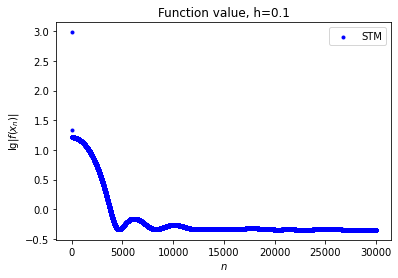

In [10]:
algrun.plot_func('Function value, h=0.1', log=True)

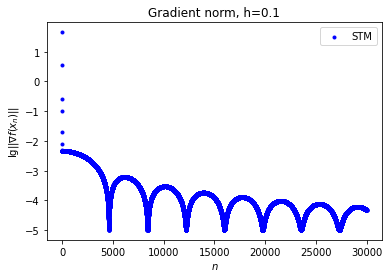

In [12]:
algrun.plot_grads('Gradient norm, h=0.1', log=True)

In [11]:
algrun.print_data()

Experiment 'STM': total time 3419.395943880081 seconds;
gradient called 30001 times, function called 0 times;
minimal gradient norm is 1.0252291498083329e-05, minimal function value is 0.44653256988064916


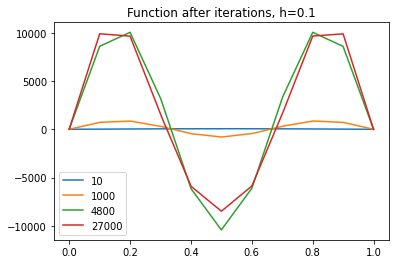

In [13]:
plt.title('Function after iterations, h=0.1')
plt.plot(x, algrun.results['STM']['points'][10], label='10')
plt.plot(x, algrun.results['STM']['points'][1000], label='1000')
plt.plot(x, algrun.results['STM']['points'][4800], label='4800')
plt.plot(x, algrun.results['STM']['points'][27000], label='27000')
plt.legend()

Эксперименты с h=0.05

In [11]:
x = np.arange(0.0, 1.0001, 0.0001)
oracle = Oracle(f(x), g(x), np.pi, 10000, 20)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM', STM, np.zeros(10001), oracle.func_grad, N=30000)

Выходные данные были обрезаны до нескольких последних строк (5000).
25001 0.3452792231766741 1.743101160451698e-05
25002 0.3452819246578812 1.7468891854839477e-05
25003 0.3452846340611552 1.7506764833518826e-05
25004 0.34528735150262485 1.7544630495052953e-05
25005 0.34529007657517896 1.7582488972196214e-05
25006 0.3452928093632798 1.7620340238247858e-05
25007 0.34529555038885257 1.765818404401966e-05
25008 0.34529829895988096 1.7696020702061652e-05
25009 0.3453010555054395 1.7733850013811746e-05
25010 0.34530381962564405 1.7771672125323872e-05
25011 0.34530659184191087 1.7809486804287414e-05
25012 0.34530937170681525 1.7847294249693876e-05
25013 0.345312159499493 1.7885094311759864e-05
25014 0.34531495503343096 1.792288706407668e-05
25015 0.34531775827571953 1.796067254472687e-05
25016 0.3453205692420993 1.7998450702173007e-05
25017 0.34532338817233205 1.8036221422072397e-05
25018 0.34532621475341385 1.8073984854264975e-05
25019 0.3453290492208888 1.8111740860578936e-05
25020 0.345331

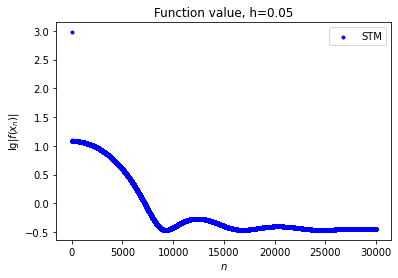

In [12]:
algrun.plot_func('Function value, h=0.05', log=True)

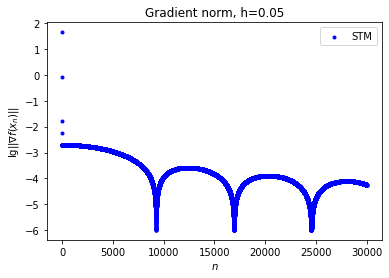

In [13]:
algrun.plot_grads('Gradient norm, h=0.05', log=True)

In [14]:
algrun.print_data()

Experiment 'STM': total time 4294.53780579567 seconds;
gradient called 30001 times, function called 0 times;
minimal gradient norm is 1.0395609409466406e-06, minimal function value is 0.3448458372402337


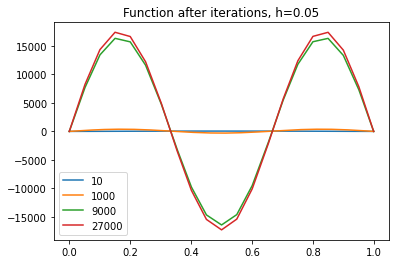

In [16]:
plt.title('Function after iterations, h=0.05')
plt.plot(x, algrun.results['STM']['points'][10], label='10')
plt.plot(x, algrun.results['STM']['points'][1000], label='1000')
plt.plot(x, algrun.results['STM']['points'][9000], label='9000')
plt.plot(x, algrun.results['STM']['points'][27000], label='27000')
plt.legend()

Эксперименты с h=0.02

In [9]:
x = np.arange(0.0, 1.0001, 0.0001)
oracle = Oracle(f(x), g(x), np.pi, 10000, 50)
algrun = FirstOrderAlgorithmRunner()
algrun.run_method('STM', STM, np.zeros(10001), oracle.func_grad, N=30000)

0 942.1147504996941 43.24346728170576
0 9.837184002579198 0.13788303785158057
1 9.828536357788252 0.0014322737805864635
2 9.828530499282063 0.0013689222002441774
3 9.828528358297966 0.0013631432356366294
4 9.828524954422738 0.0013631424981370738
5 9.828521063601752 0.00136314220347887
6 9.828516678826121 0.0013631418912534552
7 9.82851180465101 0.0013631415441817563
8 9.828506443701592 0.0013631411624469164
9 9.828500597635282 0.0013631407461711822
10 9.82849426839641 0.0013631402954895333
11 9.828487457377097 0.001363139810501414
12 9.828480165764924 0.0013631392912916934
13 9.828472394562104 0.001363138737932154
14 9.828464144650306 0.0013631381504860868
15 9.82845541698144 0.001363137529019205
16 9.82844621213378 0.001363136873574688
17 9.8284365308933 0.0013631361842064637
18 9.828426373687034 0.001363135460946863
19 9.828415741137642 0.0013631347038390272
20 9.828404633704453 0.0013631339129156097
21 9.828393051786858 0.0013631330882056209
22 9.828380995776204 0.001363132229736945

190 9.819709257825945 0.0013625146034611335
191 9.819618259425827 0.0013625081208069095
192 9.819526796046091 0.0013625016049983519
193 9.819434867913083 0.0013624950560487874
194 9.819342474864474 0.0013624884739482832
195 9.819249617095224 0.0013624818587078418
196 9.819156294537494 0.001362475210323467
197 9.819062507255888 0.0013624685287985494
198 9.818968255147036 0.0013624618141268251
199 9.818873538406885 0.0013624550663195103
200 9.81877835690199 0.0013624482853684466
201 9.818682710648977 0.0013624414712743798
202 9.818586599802464 0.0013624346240461275
203 9.81849002427536 0.0013624277436780922
204 9.81839298409226 0.0013624208301717857
205 9.81829547930177 0.0013624138835294705
206 9.81819750990419 0.0013624069037510025
207 9.81809907595242 0.0013623998908391028
208 9.818000177362126 0.0013623928447886384
209 9.817900814271093 0.0013623857656072963
210 9.81780098654419 0.0013623786532869638
211 9.81770069436516 0.0013623715078380102
212 9.817599937708557 0.00136236432925873

378 9.794449993387525 0.001360713968700614
379 9.794271926932193 0.0013607012665824872
380 9.794093399450338 0.0013606885314566613
381 9.793914410723723 0.0013606757633098246
382 9.79373496095947 0.0013606629621532491
383 9.793555049961578 0.0013606501279751168
384 9.793374677901115 0.0013606372607845511
385 9.793193844805167 0.0013606243605827175
386 9.793012550676428 0.001360611427368887
387 9.792830795486744 0.0013605984611410407
388 9.792648579395962 0.0013605854619077162
389 9.79246590220449 0.001360572429656674
390 9.79228276409891 0.0013605593643981197
391 9.792099165024839 0.0013605462661282182
392 9.79191510515238 0.001360533134856484
393 9.791730584290324 0.0013605199705707485
394 9.791545602656022 0.001360506773283231
395 9.791360160201005 0.001360493542990553
396 9.791174256921483 0.001360480279691821
397 9.790987892793513 0.0013604669833847303
398 9.790801068042981 0.0013604536540820123
399 9.790613782400325 0.0013604402917673287
400 9.790426036134319 0.0013604268964555453

566 9.752894634597292 0.001357746455239562
567 9.752630328158997 0.0013577275600813413
568 9.75236556586221 0.001357708632069522
569 9.75210034764491 0.0013576896711994517
570 9.751834673560959 0.0013576706774733377
571 9.751568543619559 0.0013576516508907969
572 9.751301957880472 0.0013576325914544474
573 9.751034916417781 0.0013576134991674193
574 9.750767419142079 0.0013575943740238726
575 9.750499466224277 0.0013575752160325308
576 9.750231057580883 0.0013575560251877447
577 9.749962193266043 0.0013575368014915644
578 9.749692873525905 0.001357517544957686
579 9.74942309815311 0.0013574982555728267
580 9.749152867133528 0.0013574789333352065
581 9.74888218067294 0.0013574595782558266
582 9.748611038749356 0.001357440190332625
583 9.748339441251339 0.001357420769557926
584 9.748067388544667 0.0013574013159523394
585 9.747794880336894 0.0013573818294975717
586 9.747521916912621 0.0013573623102095217
587 9.747248498132361 0.0013573427580787917
588 9.746974624032243 0.00135732317310677

755 9.69487961803697 0.0013535926633543827
756 9.694529780893708 0.001353567576870214
757 9.694179494940073 0.0013535424577367761
758 9.693828760271487 0.0013535173059584607
759 9.693477576832041 0.0013534921215305126
760 9.693125944704521 0.0013534669044567944
761 9.692773864058687 0.0013534416547459204
762 9.69242133468449 0.0013534163723842735
763 9.692068356828575 0.001353391057384957
764 9.691714930529253 0.0013533657097492982
765 9.691361055647928 0.0013533403294674299
766 9.691006732492019 0.0013533149165562564
767 9.690651960891921 0.001353289471004815
768 9.690296741043099 0.001353263992823104
769 9.689941072643911 0.0013532384819920126
770 9.689584956263964 0.0013532129385438682
771 9.68922839164868 0.0013531873624625206
772 9.688871378842006 0.0013531617537491025
773 9.688513917924347 0.0013531361124070706
774 9.688156008944812 0.0013531104384380882
775 9.687797651922057 0.0013530847318418981
776 9.687438846969107 0.0013530589926240017
777 9.687079594023894 0.001353033220779

944 9.620837037403648 0.0013482727410529965
945 9.620403194344815 0.0013482415078165592
946 9.619968911538383 0.0013482102421972172
947 9.619534188959246 0.0013481789441913063
948 9.619099026631096 0.0013481476137990498
949 9.618663424743648 0.0013481162510299827
950 9.618227383211648 0.0013480848558774616
951 9.61779090222885 0.0013480534283515345
952 9.6173539817728 0.0013480219684488949
953 9.616916621870093 0.0013479904761699414
954 9.616478822599195 0.0013479589515175813
955 9.616040584036705 0.0013479273944946757
956 9.615601906133023 0.0013478958050967221
957 9.61516278907028 0.0013478641833330417
958 9.614723232868485 0.0013478325292031114
959 9.614283237579736 0.0013478008427084737
960 9.613842803167417 0.0013477691238451908
961 9.613401929784846 0.0013477373726208924
962 9.612960617440276 0.0013477055890345159
963 9.612518866260414 0.0013476737730919134
964 9.612076676280035 0.0013476419247934652
965 9.61163404738815 0.0013476100441310063
966 9.61119097985412 0.00134757813111

1130 9.532633607956704 0.0013419078552223854
1131 9.532118922870959 0.0013418706262526595
1132 9.531603808672088 0.0013418333652097875
1133 9.53108826542993 0.0013417960720960161
1134 9.530572293171973 0.001341758746911234
1135 9.530055891913051 0.0013417213896543703
1136 9.529539061832061 0.00134168400033399
1137 9.52902180295319 0.001341646578949996
1138 9.528504115324576 0.0013416091255031442
1139 9.527985998944269 0.0013415716399915005
1140 9.527467453966649 0.0013415341224224473
1141 9.526948480407004 0.0013414965727947682
1142 9.52642907845463 0.0013414589911180939
1143 9.52590924792021 0.0013414213773791908
1144 9.525388988989997 0.001341383731587197
1145 9.524868301855339 0.0013413460537516895
1146 9.524347186465617 0.0013413083438677247
1147 9.523825642816625 0.0013412706019329788
1148 9.523303671073887 0.0013412328279559659
1149 9.522781271292482 0.0013411950219372351
1150 9.52225844346041 0.00134115718387493
1151 9.521735187672304 0.0013411193137723495
1152 9.521211504064594

1314 9.430772469614217 0.0013345196561611026
1315 9.43017992086843 0.0013344765577645895
1316 9.429586955306307 0.0013344334276579484
1317 9.428993572877037 0.0013343902658360235
1318 9.428399773715707 0.0013343470723042035
1319 9.427805557853487 0.0013343038470630328
1320 9.42721092545814 0.0013342605901198914
1321 9.426615876552969 0.0013342173014738782
1322 9.426020411162403 0.0013341739811247519
1323 9.425424529395663 0.0013341306290765435
1324 9.424828231285932 0.001334087245329145
1325 9.42423151695886 0.0013340438298879876
1326 9.423634386592951 0.0013340003827613692
1327 9.423036839983336 0.0013339569039351462
1328 9.42243887751818 0.0013339133934301525
1329 9.421840499038312 0.0013338698512349093
1330 9.421241704634172 0.0013338262773524392
1331 9.420642494389433 0.001333782671785727
1332 9.420042868523355 0.001333739034545638
1333 9.419442826901326 0.0013336953656218052
1334 9.418842369788162 0.0013336516650281139
1335 9.41824149716236 0.0013336079327611256
1336 9.41764020894

1498 9.314799830404139 0.0013260578324795808
1499 9.314131822434268 0.0013260089356296263
1500 9.313463411352366 0.0013259600074701557
1501 9.312794597539874 0.00132591104802228
1502 9.312125380825117 0.0013258620572722864
1503 9.311455761385778 0.0013258130352290923
1504 9.310785739174106 0.0013257639818873943
1505 9.310115314354798 0.001325714897254472
1506 9.309444487189857 0.001325665781343574
1507 9.308773257504052 0.0013256166341420567
1508 9.308101625415173 0.0013255674556542486
1509 9.307429591167663 0.0013255182458924689
1510 9.306757154543355 0.0013254690048412159
1511 9.30608431591438 0.001325419732520597
1512 9.305411075256718 0.001325370428926759
1513 9.304737432665705 0.0013253210940623425
1514 9.30406338813213 0.0013252717279252253
1515 9.30338894186768 0.0013252223305254649
1516 9.302714093893298 0.0013251729018613088
1517 9.302038844216321 0.0013251234419313577
1518 9.30136319303891 0.0013250739507451583
1519 9.300687140376581 0.0013250244283012223
1520 9.3000106863243

1682 9.185185093935539 0.001316536299559738
1683 9.184444323732519 0.001316481684565522
1684 9.183703166044413 0.0013164270387353062
1685 9.182961620727403 0.0013163723620580954
1686 9.182219688145166 0.0013163176545527718
1687 9.18147736821885 0.0013162629162124962
1688 9.180734661047081 0.001316208147039967
1689 9.179991566746878 0.0013161533470397429
1690 9.17924808552988 0.0013160985162223408
1691 9.17850421719985 0.0013160436545725735
1692 9.177759962198296 0.0013159887621148297
1693 9.177015320248115 0.0013159338388297245
1694 9.176270291704641 0.0013158788847359778
1695 9.175524876476791 0.001315823899825082
1696 9.174779074851562 0.0013157688841125296
1697 9.174032886758464 0.0013157138375905928
1698 9.173286312364743 0.0013156587602669125
1699 9.172539351699873 0.001315603652140673
1700 9.171792004859402 0.0013155485132147608
1701 9.17104427205181 0.0013154933434992697
1702 9.170296153196961 0.0013154381429867868
1703 9.16954764847002 0.00131538291168486
1704 9.168798757901065

1867 9.04163958929228 0.001305910434286911
1868 9.040828660820942 0.0013058501603263435
1869 9.040017361612723 0.0013057898560292097
1870 9.039205691959948 0.001305729521410895
1871 9.03839365203913 0.0013056691564785462
1872 9.037581241841512 0.0013056087612297283
1873 9.03676846130031 0.0013055483356560966
1874 9.03595531081857 0.0013054878797805376
1875 9.03514179027792 0.0013054273935924124
1876 9.03432789977399 0.0013053668770942755
1877 9.033513639567271 0.0013053063302995399
1878 9.032699009680154 0.0013052457532066405
1879 9.031884010009781 0.0013051851458060993
1880 9.031068640832883 0.0013051245081119702
1881 9.030252902460916 0.0013050638401407965
1882 9.029436794556329 0.0013050031418679405
1883 9.02862031740449 0.0013049424133088944
1884 9.027803471246658 0.0013048816544749947
1885 9.02698625600456 0.0013048208653588269
1886 9.026168671713911 0.0013047600459591266
1887 9.025350718841304 0.0013046991963018835
1888 9.024532396980028 0.0013046383163591063
1889 9.0237137064742

2051 8.886289341803616 0.0012943124908497386
2052 8.885411879343112 0.0012942466873298055
2053 8.884534064595107 0.0012941808540437947
2054 8.88365589762485 0.0012941149909933202
2055 8.882777378673437 0.0012940490981900434
2056 8.881898507580958 0.0012939831756208194
2057 8.8810192846461 0.0012939172233007623
2058 8.880139709981046 0.001293851241233993
2059 8.879259783581201 0.0012937852294161918
2060 8.878379505676685 0.001293719187859296
2061 8.877498876162633 0.001293653116553554
2062 8.876617895414817 0.0012935870155184423
2063 8.875736563295318 0.00129352088474277
2064 8.874854880025916 0.0012934547242366022
2065 8.873972845707408 0.001293388534003372
2066 8.873090460405027 0.0012933223140436793
2067 8.872207724260003 0.001293256064362754
2068 8.87132463740739 0.001293189784966637
2069 8.870441199898282 0.0012931234758546174
2070 8.869557411730948 0.0012930571370240336
2071 8.868673273162036 0.0012929907684865569
2072 8.867788784232243 0.0012929243702422563
2073 8.866903945114265

2235 8.719011667721206 0.0012817068034480209
2236 8.718071150834916 0.0012816355777706876
2237 8.717130301506964 0.0012815643229546875
2238 8.716189119290746 0.0012814930389682352
2239 8.715247604801561 0.0012814217258467733
2240 8.714305757558137 0.0012813503835566635
2241 8.713363578193611 0.0012812790121340312
2242 8.712421066448032 0.0012812076115592504
2243 8.71147822279842 0.0012811361818586956
2244 8.710535046961267 0.0012810647230116138
2245 8.70959153962093 0.0012809932350565686
2246 8.708647700110852 0.001280921717948995
2247 8.707703529168095 0.0012808501717315403
2248 8.706759026469197 0.0012807785963807768
2249 8.705814192433552 0.0012807069919186925
2250 8.704869027079674 0.0012806353583438548
2251 8.70392353033502 0.0012805636956479754
2252 8.702977702647418 0.0012804920038557602
2253 8.70203154387285 0.0012804202829546467
2254 8.701085054302297 0.0012803485329590026
2255 8.700138233852323 0.001280276753860662
2256 8.699191082825035 0.001280204945675273
2257 8.6982436010

2419 8.540467564823846 0.0012681139270800518
2420 8.539467696891457 0.001268037395295718
2421 8.53846751695295 0.0012679608350099458
2422 8.537467024786654 0.0012678842462053312
2423 8.536466221038514 0.0012678076289180365
2424 8.535465105701574 0.001267730983145826
2425 8.534463678471887 0.0012676543088640199
2426 8.533461939864216 0.0012675776061024581
2427 8.532459889907491 0.0012675008748587247
2428 8.531457528722711 0.0012674241151380248
2429 8.530454856390396 0.0012673473269404175
2430 8.529451872882605 0.001267270510261574
2431 8.528448578528357 0.0012671936651186327
2432 8.527444973628665 0.0012671167915264386
2433 8.526441057711887 0.001267039889451388
2434 8.525436831337942 0.001266962958925733
2435 8.524432294734941 0.00126688599996018
2436 8.52342744761902 0.0012668090125333867
2437 8.522422290371757 0.0012667319966647719
2438 8.52141682279736 0.001266654952340252
2439 8.520411045597529 0.0012665778795983224
2440 8.519404958256562 0.001266500778404685
2441 8.518398561143758

2603 8.351357262038539 0.0012535559816304492
2604 8.350301948555746 0.0012534742681351468
2605 8.349246344834368 0.0012533925268380516
2606 8.34819045092888 0.0012533107577395717
2607 8.347134266851862 0.0012532289608367755
2608 8.346077792834798 0.0012531471361405568
2609 8.345021028989338 0.0012530652836533747
2610 8.343963975488343 0.00125298340338416
2611 8.342906632244093 0.0012529014953218305
2612 8.34184899961661 0.0012528195594865205
2613 8.340791077650858 0.001252737595876915
2614 8.339732866410031 0.0012526556044937926
2615 8.33867436603503 0.0012525735853417931
2616 8.33761557686445 0.0012524915384387553
2617 8.336556498650785 0.0012524094637654125
2618 8.33549713166595 0.0012523273613353795
2619 8.33443747610064 0.0012522452311561297
2620 8.333377532119599 0.0012521630732357382
2621 8.332317299501335 0.0012520808875553166
2622 8.331256778738645 0.0012519986741426987
2623 8.33019596976172 0.0012519164329899517
2624 8.329134872968732 0.001251834164118123
2625 8.32807348814142

2787 8.152416334919137 0.0012380566073879311
2788 8.151309662883254 0.001237969844733465
2789 8.150202723283888 0.0012378830550205762
2790 8.14909551592878 0.0012377962382330836
2791 8.14798804138756 0.0012377093944036873
2792 8.146880299558354 0.0012376225235217252
2793 8.145772290746708 0.0012375356256024933
2794 8.144664014509283 0.0012374487006145752
2795 8.143555471508153 0.0012373617485953346
2796 8.142446661833123 0.0012372747695481477
2797 8.141337585385648 0.0012371877634615876
2798 8.140228242496486 0.0012371007303535757
2799 8.139118633183218 0.0012370136702212437
2800 8.138008757584338 0.0012369265830693083
2801 8.136898615756218 0.0012368394688976581
2802 8.13578820810286 0.0012367523277285314
2803 8.13467753435412 0.001236665159540346
2804 8.133566594913972 0.001236577964354904
2805 8.132455389837451 0.001236490742172432
2806 8.131343919180862 0.0012364034929924004
2807 8.130232183356277 0.0012363162168374602
2808 8.129120182021815 0.0012362289136812127
2809 8.12800791568

2971 7.944411647812351 0.0012216409174103542
2972 7.943257862753233 0.0012215492460088
2973 7.942103833724004 0.0012214575483413493
2974 7.94094956060524 0.0012213658243965433
2975 7.93979504332169 0.0012212740741644
2976 7.938640282324786 0.0012211822976711695
2977 7.9374852777180935 0.0012210904949199462
2978 7.936330029670839 0.0012209986659157495
2979 7.935174538151541 0.0012209068106542123
2980 7.934018803281782 0.0012208149291386336
2981 7.932862825208617 0.0012207230213744712
2982 7.93170660406496 0.0012206310873666775
2983 7.9305501400571305 0.0012205391271238838
2984 7.929393433457242 0.0012204471406604218
2985 7.928236484069494 0.0012203551279596101
2986 7.927079292371611 0.0012202630890481576
2987 7.925921857970209 0.0012201710238959023
2988 7.9247641816334236 0.0012200789325494802
2989 7.923606262893285 0.001219986814975059
2990 7.922448102398587 0.0012198946712087969
2991 7.921289699896614 0.0012198025012323257
2992 7.9201310557526075 0.0012197103050632303
2993 7.918972170

3154 7.729333445434169 0.0012044318534744187
3155 7.728137148886949 0.001204335446805034
3156 7.72694063201969 0.0012042390146660368
3157 7.72574389533296 0.001204142557087277
3158 7.724546938464252 0.0012040460740397594
3159 7.723349761773616 0.001203949565542729
3160 7.722152365422418 0.0012038530316041234
3161 7.720954749782785 0.0012037564722439382
3162 7.719756914584173 0.0012036598874387925
3163 7.7185588599857775 0.001203563277196452
3164 7.717360586511022 0.001203466641547091
3165 7.7161620940732725 0.0012033699804798062
3166 7.714963382584558 0.0012032732939860164
3167 7.7137644524694275 0.0012031765820884359
3168 7.712565303942827 0.0012030798447983143
3169 7.711365936590376 0.0012029830820820973
3170 7.7101663511395415 0.0012028862939857457
3171 7.708966547430307 0.0012027894804940425
3172 7.7077665256001 0.0012026926416104358
3173 7.706566285999946 0.0012025957773556099
3174 7.705365828352413 0.0012024988877061336
3175 7.704165153382237 0.0012024019727063298
3176 7.70296426

3337 7.50687847202289 0.001186370100461534
3338 7.50564410710519 0.001186269112058068
3339 7.504409546698061 0.0011861680990635478
3340 7.503174790804736 0.001186067061473346
3341 7.501939839704086 0.0011859659993015965
3342 7.500704692827999 0.0011858649125063337
3343 7.499469351288231 0.001185763801157754
3344 7.498233814799595 0.0011856626652322433
3345 7.496998083202052 0.0011855615047151502
3346 7.495762157109687 0.0011854603196430396
3347 7.494526036547123 0.0011853591100132335
3348 7.4932897214126015 0.001185257875815066
3349 7.492053211832215 0.001185156617052739
3350 7.4908165083353655 0.0011850553337567605
3351 7.489579610682625 0.001184954025907137
3352 7.488342519112996 0.0011848526935158423
3353 7.487105233971618 0.0011847513366024234
3354 7.485867755097011 0.0011846499551502704
3355 7.4846300827346 0.0011845485491726493
3356 7.483392217134189 0.0011844471186799094
3357 7.482154158113683 0.0011843456636590397
3358 7.480915906336213 0.0011842441841484685
3359 7.479677461344

3521 7.276600216084914 0.0011673789801594971
3522 7.275332142381282 0.0011672735467676933
3523 7.274063898268801 0.0011671680896840609
3524 7.272795483395683 0.0011670626088803634
3525 7.271526898576287 0.001166957104406929
3526 7.2702581434655364 0.0011668515762370557
3527 7.268989218317261 0.0011667460243843081
3528 7.26772012323301 0.0011666404488490348
3529 7.266450858725069 0.00116653484966333
3530 7.265181424336374 0.0011664292267913416
3531 7.263911820408999 0.001166323580252364
3532 7.2626420473030375 0.0011662179100662394
3533 7.261372105131956 0.0011661122162350552
3534 7.260101993791587 0.0011660064987491928
3535 7.258831713380938 0.00116590075761104
3536 7.257561264164446 0.0011657949928336395
3537 7.256290646519632 0.0011656892044379068
3538 7.255019860264104 0.0011655833924083716
3539 7.253748905893987 0.0011654775567728705
3540 7.252477783037985 0.0011653716975028947
3541 7.251206492332773 0.0011652658146372793
3542 7.2499350332747925 0.001165159908137066
3543 7.24866340

3705 7.040543560880478 0.0011475853289725233
3706 7.039246420816948 0.001147475619390313
3707 7.0379491359770645 0.0011473658870702352
3708 7.036651706319474 0.0011472561320036562
3709 7.035354131098624 0.0011471463541380524
3710 7.034056411284249 0.0011470365535326229
3711 7.032758547079525 0.0011469267302000724
3712 7.031460538165457 0.0011468168841114186
3713 7.030162385107331 0.0011467070153030523
3714 7.028864087853731 0.001146597123765479
3715 7.027565646669528 0.0011464872095130034
3716 7.026267060548614 0.001146377272474003
3717 7.02496833136279 0.0011462673127691201
3718 7.0236694585366655 0.0011461573303596056
3719 7.022370442031803 0.0011460473252336277
3720 7.02107128190617 0.0011459372973936137
3721 7.019771978928994 0.0011458272468864506
3722 7.018472532553779 0.001145717173672244
3723 7.0171729433644305 0.0011456070777851569
3724 7.015873211173006 0.0011454969592084611
3725 7.014573336325216 0.0011453868179612681
3726 7.01327331902617 0.0011452766540542764
3727 7.0119731

3888 6.8008881386279505 0.001127134582922908
3889 6.799566734378658 0.0011270207941288868
3890 6.798245210277033 0.0011269069835294456
3891 6.796923566661426 0.0011267931511444085
3892 6.795601803756255 0.001126679296984604
3893 6.794279921245941 0.001126565421022548
3894 6.792957919265814 0.0011264515232651102
3895 6.79163579825756 0.0011263376037370203
3896 6.790313558312011 0.0011262236624431977
3897 6.788991199242664 0.0011261096993633963
3898 6.787668721918742 0.0011259957145561327
3899 6.7863461255783095 0.0011258817079620256
3900 6.7850234111471375 0.0011257676796423846
3901 6.78370057809725 0.0011256536295546457
3902 6.78237762693674 0.0011255395577329345
3903 6.781054557674913 0.00112542546417143
3904 6.77973137085606 0.0011253113489036732
3905 6.778408065812196 0.001125197211879566
3906 6.777084643583489 0.0011250830531654861
3907 6.77576110403763 0.0011249688727511913
3908 6.774437446567953 0.0011248546705877266
3909 6.773113672031216 0.0011247404467315863
3910 6.77178978090

4072 6.555874001971804 0.0011058358609848874
4073 6.554532884657429 0.0011057181512817112
4074 6.553191672411594 0.0011056004207322938
4075 6.5518503665171925 0.0011054826694196762
4076 6.550508966666504 0.001105364897319239
4077 6.549167472374784 0.0011052471043940372
4078 6.5478258846547375 0.0011051292907091276
4079 6.546484203156447 0.001105011456235751
4080 6.545142428686026 0.0011048936010271434
4081 6.5438005601400535 0.0011047757250031056
4082 6.5424585988240915 0.0011046578282489599
4083 6.541116544348485 0.0011045399107319242
4084 6.539774396937886 0.0011044219724666061
4085 6.538432156740343 0.001104304013457933
4086 6.5370898241661575 0.0011041860337302621
4087 6.5357473984097005 0.0011040680332228448
4088 6.534404880631039 0.001103950012014682
4089 6.533062270552042 0.0011038319700787374
4090 6.531719568712196 0.0011037139074505068
4091 6.53037677480364 0.0011035958241041957
4092 6.5290338889290025 0.0011034777200448296
4093 6.527690911344455 0.0011033595952816921
4094 6.5

4255 6.309017820805028 0.0010839541065725035
4256 6.307661745464262 0.0010838326823473445
4257 6.306305601189212 0.001083711238349837
4258 6.304949387987625 0.0010835897745765154
4259 6.303593105748448 0.0010834682910142801
4260 6.302236755016088 0.0010833467876992893
4261 6.300880335353851 0.0010832252645937132
4262 6.29952384833004 0.0010831037218081217
4263 6.298167292195181 0.0010829821592115004
4264 6.2968106682655245 0.001082860576896205
4265 6.2954539765247555 0.0010827389748534432
4266 6.294097216602016 0.0010826173530543892
4267 6.29274038954671 0.0010824957115706042
4268 6.291383494794939 0.0010823740503574345
4269 6.290026532784542 0.0010822523694395375
4270 6.288669502929965 0.001082130668774196
4271 6.287312406182807 0.0010820089484240142
4272 6.285955242497403 0.001081887208381234
4273 6.284598011540074 0.0010817654486176516
4274 6.283240714746619 0.0010816436692336142
4275 6.281883350688988 0.0010815218701215174
4276 6.28052592067161 0.0010814000513687837
4277 6.27916842

4438 6.059843919480666 0.0010614097907654038
4439 6.058477488801743 0.0010612848417545875
4440 6.057111015368636 0.0010611598741058184
4441 6.05574449686929 0.0010610348876459038
4442 6.0543779350209705 0.0010609098824980341
4443 6.053011329797157 0.0010607848586530412
4444 6.051644681334467 0.0010606598161205074
4445 6.050277988485638 0.001060534754809758
4446 6.048911253511767 0.0010604096748840835
4447 6.047544474565895 0.001060284576202027
4448 6.04617765332535 0.0010601594588842786
4449 6.044810789261674 0.0010600343228854099
4450 6.043443882369408 0.0010599091682041884
4451 6.042076932819881 0.0010597839948460373
4452 6.040709940787112 0.0010596588028216763
4453 6.0393429068251105 0.0010595335921673025
4454 6.037975830345145 0.0010594083628329286
4455 6.036608712157093 0.00105928311487882
4456 6.035241552274631 0.0010591578482977838
4457 6.033874350226941 0.0010590325630522289
4458 6.032507106676391 0.0010589072591873619
4459 6.031139822069821 0.0010587819367317904
4460 6.0297724

4622 5.807817700743719 0.001038109799539805
4623 5.806445443797639 0.0010379815026788483
4624 5.805073168356185 0.0010378531882243235
4625 5.8037008727471235 0.0010377248560474869
4626 5.80232855869781 0.0010375965062718016
4627 5.800956225845539 0.0010374681388675248
4628 5.799583873995964 0.0010373397538163765
4629 5.7982115040321265 0.0010372113511784712
4630 5.796839115581531 0.0010370829309243783
4631 5.795466708484817 0.001036954493037327
4632 5.794094283639953 0.0010368260375813545
4633 5.792721840448874 0.0010366975645052531
4634 5.791349379600841 0.0010365690738574742
4635 5.789976900874695 0.0010364405656179197
4636 5.788604404019414 0.0010363120397639633
4637 5.787231890096558 0.0010361834963702628
4638 5.785859358894473 0.0010360549354182296
4639 5.7844868101693505 0.001035926356883589
4640 5.7831142445138335 0.0010357977608094057
4641 5.781741662163912 0.0010356691472062558
4642 5.780369062537039 0.0010355405160289118
4643 5.778996446236392 0.0010354118673178675
4644 5.777

4805 5.556507742097201 0.0010143435608834638
4806 5.555134172006858 0.001014212133810476
4807 5.5537606069378285 0.001014080690192724
4808 5.552387046751619 0.0010139492300157487
4809 5.551013491446908 0.0010138177532779884
4810 5.549639942049868 0.0010136862600515376
4811 5.548266397883904 0.0010135547502809047
4812 5.546892859191747 0.001013423223982569
4813 5.545519326422418 0.0010132916811835427
4814 5.544145798984473 0.0010131601218375552
4815 5.542772278024708 0.0010130285460284228
4816 5.54139876313375 0.0010128969537194364
4817 5.540025254292576 0.0010127653449070908
4818 5.5386517521812015 0.0010126337196372116
4819 5.537278256127953 0.0010125020778546272
4820 5.53590476651511 0.0010123704195873378
4821 5.534531283986099 0.0010122387448797522
4822 5.533157808579835 0.0010121070537285233
4823 5.531784340109321 0.0010119753461176057
4824 5.5304108784228605 0.001011843622033212
4825 5.529037424371848 0.0010117118815307531
4826 5.52766397743667 0.001011580124572169
4827 5.52629053

4989 5.303986260031177 0.0009898885409115347
4990 5.302615775222965 0.0009897541710797086
4991 5.301245318956776 0.0009896197858139518
4992 5.29987489121827 0.0009894853851134305
4993 5.298504492630744 0.0009893509690179754
4994 5.297134122785762 0.0009892165374941002
4995 5.295763781684308 0.0009890820905409231
4996 5.294393470954377 0.000988947628275985
4997 5.293023188975093 0.0009888131505765424
4998 5.291652936512421 0.0009886786574912865
4999 5.290282713314208 0.0009885441490009154
5000 5.288912520375981 0.00098840962517999
5001 5.287542357215064 0.0009882750859836528
5002 5.286172224011858 0.0009881405314254386
5003 5.284802121129338 0.0009880059615268518
5004 5.283432048590488 0.0009878713762904473
5005 5.28206200571633 0.0009877367756571127
5006 5.280691994232148 0.000987602159755429
5007 5.279322012743191 0.0009874675284767362
5008 5.277952062219419 0.0009873328818908943
5009 5.276582142815418 0.0009871982200067887
5010 5.275212254660372 0.0009870635428320897
5011 5.273842396

5172 5.053790724151461 0.000965048188917489
5173 5.052427568962716 0.0009649110993318735
5174 5.051064465444203 0.0009647739954735573
5175 5.049701413581814 0.0009646368773368943
5176 5.048338413012896 0.0009644997448905652
5177 5.046975464510896 0.0009643625981917884
5178 5.045612568138275 0.0009642254372411978
5179 5.044249724164678 0.0009640882620563094
5180 5.0428869316964064 0.0009639510725654174
5181 5.041524192189136 0.0009638138688787611
5182 5.040161504272027 0.0009636766508829874
5183 5.038798870341982 0.0009635394187677221
5184 5.037436287404726 0.000963402172288558
5185 5.03607375857406 0.0009632649116925215
5186 5.03471128223762 0.0009631276368457799
5187 5.033348858928747 0.0009629903477863332
5188 5.031986488964005 0.0009628530445399061
5189 5.0306241723453065 0.0009627157271012711
5190 5.029261909319024 0.0009625783954860272
5191 5.027899699500363 0.0009624410496585389
5192 5.026537543362644 0.0009623036896553725
5193 5.025175440746451 0.0009621663154600931
5194 5.02381

5355 4.805312890370629 0.0009397291604251861
5356 4.803961176081395 0.0009395895608049555
5357 4.802609534907057 0.0009394499480167041
5358 4.801257967586312 0.0009393103221158105
5359 4.799906473822661 0.0009391706830732838
5360 4.798555054217459 0.0009390310309395579
5361 4.797203708561831 0.0009388913656919882
5362 4.795852436614903 0.0009387516873099201
5363 4.794501238833785 0.000938611995821033
5364 4.793150116230448 0.0009384722913112668
5365 4.791799067699329 0.0009383325736834778
5366 4.790448093406018 0.0009381928429522663
5367 4.789097194045264 0.0009380530991635819
5368 4.787746369536629 0.0009379133423147644
5369 4.786395620313614 0.0009377735724350543
5370 4.785044945287076 0.0009376337894320192
5371 4.783694346580187 0.0009374939934726545
5372 4.782343822673358 0.0009373541844373235
5373 4.7809933731408885 0.0009372143622841475
5374 4.7796430004376855 0.000937074527204264
5375 4.778292703516779 0.0009369346791188642
5376 4.776942481975365 0.0009367948179901892
5377 4.775

5538 4.559290953319127 0.0009139700812841992
5539 4.55795463269199 0.0009138281840085574
5540 4.556618405739097 0.0009136862746850533
5541 4.555282275390498 0.0009135443535467541
5542 4.553946239194082 0.0009134024203980724
5543 4.552610297413902 0.0009132604752493901
5544 4.551274451047982 0.0009131185181861417
5545 4.5499387000746525 0.0009129765491974136
5546 4.548603044223189 0.0009128345682638539
5547 4.547267484017073 0.000912692575423503
5548 4.545932019173403 0.000912550570649656
5549 4.544596650376876 0.0009124085539972935
5550 4.543261376910031 0.0009122665254027726
5551 4.541926199757271 0.0009121244849448123
5552 4.540591118799205 0.0009119824326100917
5553 4.5392561332377985 0.0009118403683326703
5554 4.537921243918916 0.0009116982921761466
5555 4.536586451370344 0.0009115562041845421
5556 4.535251755238861 0.0009114141043213797
5557 4.53391715598569 0.0009112719926245072
5558 4.53258265274619 0.0009111298690218578
5559 4.531248246837037 0.0009109877336179047
5560 4.529913

5721 4.316432751695291 0.0008878100451276034
5722 4.31511560354855 0.0008876660649550863
5723 4.313798570433579 0.0008875220740135894
5724 4.312481651256584 0.0008873780722104787
5725 4.311164848318481 0.0008872340597315191
5726 4.309848160534183 0.0008870900364878711
5727 4.308531587304721 0.0008869460024230275
5728 4.307215129746141 0.0008868019576318108
5729 4.305898787756904 0.000886657902099616
5730 4.304582561284431 0.000886513835824065
5731 4.303266450188229 0.0008863697587842378
5732 4.301950455099441 0.000886225671035383
5733 4.30063457587793 0.0008860815725617239
5734 4.2993188129440165 0.0008859374633975745
5735 4.298003165343307 0.0008857933434591142
5736 4.296687634862478 0.0008856492128947067
5737 4.2953722198570965 0.0008855050715603861
5738 4.294056922573503 0.00088536091964876
5739 4.292741740412571 0.0008852167569322663
5740 4.291426674565835 0.0008850725835150542
5741 4.290111726935394 0.000884928399548446
5742 4.28879689537778 0.0008847842048538199
5743 4.2874821805

5904 4.077412776763245 0.0008612885369801162
5905 4.07611839074734 0.0008611426906634937
5906 4.074824139145966 0.0008609968348006568
5907 4.073530020883053 0.0008608509692875153
5908 4.07223603588847 0.0008607050941178831
5909 4.070942185931534 0.0008605592094439392
5910 4.069648470246918 0.0008604133151942746
5911 4.068354888717129 0.0008602674113611185
5912 4.067061441836052 0.0008601214979814962
5913 4.065768129000447 0.0008599755750025423
5914 4.064474951387696 0.0008598296425245608
5915 4.063181908181246 0.0008596837004697078
5916 4.06188900043248 0.0008595377489334357
5917 4.060596227549847 0.0008593917878568449
5918 4.059303589568062 0.0008592458172489732
5919 4.0580110866251955 0.0008590998371107394
5920 4.056718718811046 0.0008589538474498059
5921 4.055426486568316 0.0008588078483050103
5922 4.05413439015196 0.0008586618396931034
5923 4.0528424293897976 0.0008585158215986499
5924 4.051550603498773 0.0008583697939515404
5925 4.05025891381656 0.0008582237568671789
5926 4.048967

6086 3.8441378363504497 0.0008345928431955053
6087 3.842869444915799 0.0008344453573055841
6088 3.841601205524555 0.0008342978630348681
6089 3.8403331179240747 0.0008341503603641391
6090 3.8390651816740733 0.0008340028492486013
6091 3.8377973977758693 0.0008338553297752673
6092 3.8365297666281193 0.0008337078019801001
6093 3.8352622861371937 0.0008335602656732667
6094 3.8339949582813495 0.000833412721030165
6095 3.8327277831826345 0.0008332651680572187
6096 3.8314607606187767 0.0008331176067338572
6097 3.830193890950965 0.0008329700370922196
6098 3.8289271729260466 0.0008328224590191799
6099 3.827660608310978 0.0008326748726665186
6100 3.826394196156588 0.0008325272779523198
6101 3.8251279376117773 0.0008323796749719276
6102 3.8238618309768264 0.0008322320635794963
6103 3.8225958778331774 0.0008320844439085481
6104 3.8213300784966604 0.0008319368159819494
6105 3.8200644323032917 0.0008317891797459898
6106 3.8187989393944983 0.0008316415352076427
6107 3.8175335992068344 0.00083149388232

6267 3.6171204051779284 0.0008077672699689773
6268 3.6158809745945226 0.0008076183686218705
6269 3.614641712871626 0.0008074694601101227
6270 3.6134026192458273 0.0008073205443614754
6271 3.612163694856011 0.0008071716214782404
6272 3.6109249375238544 0.0008070226912685438
6273 3.60968635048992 0.000806873754015806
6274 3.6084479311930977 0.0008067248094953375
6275 3.6072096793851975 0.000806575857674186
6276 3.605971597887161 0.0008064268988075918
6277 3.604733685149893 0.0008062779327622357
6278 3.6034959418127315 0.0008061289595882316
6279 3.6022583662439165 0.00080597997913425
6280 3.6010209606270682 0.0008058309916018129
6281 3.5997837241230353 0.0008056819969134109
6282 3.598546657265884 0.0008055329951131053
6283 3.5973097596359667 0.0008053839861624319
6284 3.596073031791496 0.0008052349701095365
6285 3.5948364735460347 0.0008050859469400878
6286 3.593600084381402 0.0008049369166015016
6287 3.5923638653492582 0.0008047878791913917
6288 3.591127816585148 0.0008046388347192226
62

6448 3.3956075336191263 0.0007807048655478616
6449 3.3943999447826063 0.000780554764038965
6450 3.393192539406479 0.0007804046564931548
6451 3.391985316723298 0.0007802545428417918
6452 3.3907782782328075 0.0007801044232212989
6453 3.3895714237853203 0.0007799542976150563
6454 3.3883647527610905 0.0007798041659657839
6455 3.387158266208399 0.0007796540283667118
6456 3.3859519634405677 0.000779503884765187
6457 3.384745844353194 0.0007793537351340731
6458 3.383539909726717 0.0007792035795561492
6459 3.382334158862458 0.0007790534179602145
6460 3.3811285925009824 0.0007789032504147996
6461 3.379923210837832 0.000778753076940933
6462 3.378718013334834 0.0007786028974882765
6463 3.3775130006528546 0.0007784527121111173
6464 3.3763081720320676 0.0007783025207399166
6465 3.3751035287611177 0.0007781523234978062
6466 3.3738990700758693 0.0007780021203073234
6467 3.372694796065669 0.0007778519111809613
6468 3.3714907072614135 0.0007777016961629187
6469 3.3702868031753375 0.0007775514752106921


6629 3.180099874916693 0.0007534446062775194
6630 3.178926775561715 0.0007532935198459525
6631 3.1777538746409038 0.000753142428663644
6632 3.176581171463448 0.000752991332666177
6633 3.175408665632122 0.0007528402318136465
6634 3.17423635793477 0.0007526891261747616
6635 3.1730642468854313 0.0007525380156176412
6636 3.171892334922707 0.0007523869003652569
6637 3.1707206202747775 0.0007522357802539222
6638 3.1695491037901 0.000752084655358046
6639 3.1683777853937882 0.0007519335256813286
6640 3.167206664914283 0.0007517823911962108
6641 3.166035743069666 0.0007516312519718489
6642 3.1648650195012094 0.0007514801079798452
6643 3.1636944939050586 0.0007513289591846062
6644 3.1625241667498116 0.0007511778056355392
6645 3.161354038289588 0.0007510266473534928
6646 3.1601841081844118 0.0007508754843045685
6647 3.1590143768531984 0.0007507243165346953
6648 3.1578448444641882 0.000750573144048081
6649 3.156675510031842 0.0007504219667580975
6650 3.1555063760842765 0.0007502707849072985
6651 3

6810 2.9710557625504572 0.0007260254769199301
6811 2.969919567526131 0.0007258736210923078
6812 2.9687835820863357 0.0007257217615563641
6813 2.9676478072524803 0.0007255698984177313
6814 2.966512241603042 0.0007254180315279827
6815 2.965376886892631 0.0007252661610654945
6816 2.9642417432425487 0.0007251142870379498
6817 2.9631068097139486 0.0007249624093531676
6818 2.961972086332178 0.0007248105280187509
6819 2.9608375740190525 0.0007246586431220137
6820 2.9597032717354157 0.0007245067545582792
6821 2.9585691806049654 0.0007243548624441123
6822 2.9574353005696694 0.0007242029667683065
6823 2.956301630187222 0.0007240510673941559
6824 2.9551681715910405 0.0007238991645277767
6825 2.954034924627751 0.0007237472581503777
6826 2.9529018879804 0.0007235953481416605
6827 2.9517690618677515 0.0007234434345228209
6828 2.950636448093238 0.0007232915174622928
6829 2.9495040451919103 0.0007231395968222344
6830 2.948371854353886 0.0007229876727192678
6831 2.9472398731093583 0.0007228357449138808

6991 2.7688899687790967 0.0006984863990068317
6992 2.7677928448882567 0.0006983339883355509
6993 2.7666959425455144 0.000698181575206375
6994 2.765599261340983 0.0006980291595764145
6995 2.764502802207266 0.000697876741543725
6996 2.7634065642183296 0.0006977243210121766
6997 2.7623105481491033 0.0006975718980661842
6998 2.7612147540601946 0.0006974194727060934
6999 2.760119180978828 0.0006972670448371675
7000 2.7590238297160017 0.0006971146145415076
7001 2.7579287013041203 0.0006969621819228422
7002 2.7568337942262824 0.0006968097468269188
7003 2.7557391092017576 0.0006966573093339738
7004 2.7546446461943415 0.000696504869437043
7005 2.7535504054635442 0.0006963524271640355
7006 2.7524563861564544 0.0006961999824239853
7007 2.751362590205746 0.0006960475354206925
7008 2.750269015420524 0.0006958950859278171
7009 2.7491756642598673 0.0006957426341986921
7010 2.74808253512091 0.000695590180064494
7011 2.7469896275411076 0.0006954377234948181
7012 2.7458969436346283 0.0006952852646867319

7172 2.573972730495395 0.000670866158168153
7173 2.5729165987400484 0.0006707134064896681
7174 2.571860698005846 0.000670560653476357
7175 2.5708050284115695 0.0006704078991590286
7176 2.569749590358814 0.0006702551435664062
7177 2.5686943846473955 0.0006701023867897414
7178 2.567639409855847 0.0006699496286795052
7179 2.5665846665223206 0.0006697968692994562
7180 2.5655301547889238 0.0006696441086568734
7181 2.5644758752709786 0.0006694913468195234
7182 2.563421827294818 0.000669338583721282
7183 2.5623680109541556 0.0006691858193752839
7184 2.561314426550712 0.0006690330538046375
7185 2.560261073494544 0.0006688802869550943
7186 2.5592079527006666 0.0006687275189283281
7187 2.5581550642708546 0.0006685747497315275
7188 2.557102408131388 0.0006684219793478107
7189 2.5560499836378687 0.0006682692077281105
7190 2.554997791214828 0.0006681164349128885
7191 2.5539458317106294 0.0006679636609869347
7192 2.5528941031349968 0.0006678108857475753
7193 2.5518426080051446 0.0006676581094548891


7353 2.3866290689010823 0.0006432033329699094
7354 2.3856155984415444 0.0006430504527006898
7355 2.3846023675664787 0.00064289757228108
7356 2.383589376066887 0.0006427446916929685
7357 2.3825766249724487 0.0006425918110344545
7358 2.3815641134066436 0.0006424389302278626
7359 2.380551843125301 0.0006422860494533715
7360 2.37953981167743 0.0006421331684522566
7361 2.3785280210623867 0.0006419802874438389
7362 2.3775164701382665 0.00064182740631068
7363 2.376505159118239 0.0006416745250728381
7364 2.3754940893929475 0.0006415216438815265
7365 2.3744832595339456 0.000641368762572384
7366 2.373472669934901 0.000641215881215491
7367 2.3724623205226267 0.0006410629997872127
7368 2.3714522124057686 0.0006409101184094221
7369 2.370442343655162 0.0006407572368835969
7370 2.3694327154756456 0.0006406043553410919
7371 2.3684233280614353 0.0006404514737985636
7372 2.3674141811532783 0.0006402985922300422
7373 2.3664052757120433 0.0006401457107451209
7374 2.3653966107598388 0.0006399928292393155
7

7534 2.2071383910232187 0.0006155362244435214
7535 2.2061689983946997 0.0006153834262946771
7536 2.205199852599542 0.0006152306291610026
7537 2.2042309532145317 0.0006150778330000382
7538 2.2032623019509265 0.0006149250380045968
7539 2.2022938966100676 0.0006147722439379288
7540 2.2013257389073306 0.0006146194509837234
7541 2.2003578285653793 0.0006144666591169368
7542 2.199390165058714 0.0006143138682872065
7543 2.198422749064516 0.000614161078561745
7544 2.1974555800554763 0.0006140082898996343
7545 2.196488658674647 0.0006138555023557572
7546 2.1955219839640048 0.0006137027158440162
7547 2.194555557431841 0.0006135499305217643
7548 2.1935893778594506 0.0006133971462644886
7549 2.1926234461204253 0.0006132443631634586
7550 2.191657760942923 0.00061309158109313
7551 2.1906923246779777 0.000612938800297078
7552 2.189727134793402 0.0006127860205123049
7553 2.1887621934582677 0.0006126332419807482
7554 2.1877974987655717 0.0006124804644869988
7555 2.1868330526251487 0.0006123276882474508

7715 2.035734370588404 0.0005879027865558551
7716 2.0348102188515917 0.0005877502789985892
7717 2.033886320605761 0.0005875977737052831
7718 2.0329626752358156 0.0005874452706100386
7719 2.0320392828237415 0.0005872927697342257
7720 2.0311161422002986 0.0005871402709415245
7721 2.030193254701275 0.0005869877743902554
7722 2.0292706208343674 0.0005868352801395358
7723 2.028348239845685 0.000586682788095938
7724 2.027426111387671 0.0005865302982459136
7725 2.026504234937909 0.0005863778105179196
7726 2.0255826128321073 0.0005862253251829271
7727 2.024661242945356 0.0005860728420018201
7728 2.0237401261305283 0.0005859203610777679
7729 2.022819262467585 0.0005857678824206559
7730 2.02189865257392 0.0005856154061036059
7731 2.0209782951483577 0.0005854629319841042
7732 2.0200581910981033 0.000585310460170691
7733 2.0191383392713425 0.0005851579905280416
7734 2.0182187418323263 0.0005850055233106665
7735 2.0172993978294103 0.0005848530584155711
7736 2.0163803063852512 0.0005847005957366617


7895 1.8734833518015759 0.0005604925710821465
7896 1.8726050983083784 0.0005603405570437195
7897 1.8717271028568263 0.0005601885464307757
7898 1.8708493641282784 0.0005600365390810501
7899 1.8699718826353884 0.0005598845350758057
7900 1.8690946578277876 0.0005597325343366126
7901 1.8682176901861844 0.0005595805369340718
7902 1.8673409797602507 0.0005594285428776069
7903 1.8664645265030995 0.0005592765521602464
7904 1.8655883310258206 0.000559124564860652
7905 1.8647123917080148 0.0005589725808033909
7906 1.863836710828491 0.0005588206002291537
7907 1.862961286370975 0.0005586686229382958
7908 1.862086119778474 0.0005585166490839447
7909 1.8612112102702998 0.0005583646785917118
7910 1.8603365573694617 0.0005582127114049523
7911 1.8594621625419931 0.0005580607476930781
7912 1.8585880251250733 0.0005579087873839136
7913 1.8577141444568013 0.0005577568304142063
7914 1.856840522076386 0.0005576048769530065
7915 1.8559671562955686 0.0005574529268192282
7916 1.8550940487825196 0.0005573009802

8075 1.7195566442454704 0.000533189225422819
8076 1.7187249491037824 0.0005330379060220511
8077 1.7178935139248046 0.000532886591030431
8078 1.7170623390556987 0.0005327352804902896
8079 1.7162314233429945 0.0005325839742579662
8080 1.7154007687626356 0.0005324326726012169
8081 1.7145703736692937 0.0005322813752906735
8082 1.7137402384244316 0.0005321300824008027
8083 1.712910363725531 0.0005319787940157187
8084 1.7120807497945119 0.000531827510172178
8085 1.7112513949134667 0.0005316762306423073
8086 1.710422300878587 0.0005315249556698699
8087 1.7095934667866786 0.0005313736851485157
8088 1.708764892396903 0.0005312224190525657
8089 1.7079365783639289 0.0005310711574556289
8090 1.707108524631311 0.0005309199003716464
8091 1.7062807317414668 0.0005307686478605284
8092 1.7054531986319748 0.0005306173998038717
8093 1.7046259258221685 0.000530466156251088
8094 1.703798913565974 0.0005303149172638335
8095 1.7029721611659472 0.0005301636827467522
8096 1.702145668763182 0.000530012452732524

8255 1.5740514498157865 0.0005060286586734609
8256 1.573266731577875 0.0005058782316132638
8257 1.572482275396749 0.00050572781009421
8258 1.5716980814545134 0.0005055773941483798
8259 1.5709141493454757 0.0005054269837392573
8260 1.5701304781504444 0.0005052765787432686
8261 1.5693470692939218 0.0005051261793491137
8262 1.5685639214481792 0.0005049757853957578
8263 1.5677810363170699 0.0005048253971042727
8264 1.566998412358289 0.0005046750142846703
8265 1.5662160508387106 0.0005045246371022362
8266 1.5654339500621215 0.0005043742653474775
8267 1.5646521117212875 0.0005042238992533819
8268 1.563870535086918 0.0005040735386995452
8269 1.563089219734729 0.0005039231836714642
8270 1.56230816682994 0.00050377283430144
8271 1.5615273750767504 0.0005036224904491725
8272 1.5607468460005085 0.0005034721522873282
8273 1.5599665784826247 0.0005033218197065066
8274 1.5591865721990281 0.0005031714926522104
8275 1.558406828224131 0.0005030211712702436
8276 1.5576273459164147 0.00050287085549951
82

8434 1.4377601825427155 0.0004791955264553592
8435 1.4370223673503497 0.0004790461797591311
8436 1.4362848137738615 0.0004788968395756552
8437 1.435547522124702 0.0004787475059381654
8438 1.4348104929828753 0.0004785981789350039
8439 1.434073725241435 0.0004784488584157059
8440 1.4333372200929468 0.0004782995445561283
8441 1.4326009768558134 0.0004781502372724194
8442 1.4318649957566645 0.00047800093659383083
8443 1.4311292766004193 0.0004778516425033024
8444 1.4303938198329689 0.0004777023550588355
8445 1.4296586251642192 0.0004775530742362196
8446 1.4289236927442428 0.00047740380005766134
8447 1.4281890222203264 0.00047725453249009925
8448 1.4274546139880964 0.000477105271586624
8449 1.4267204680320664 0.00047695601734018685
8450 1.4259865835023866 0.00047680676966818967
8451 1.4252529617677205 0.0004766575287361684
8452 1.4245196017042625 0.0004765082944087597
8453 1.4237865035567965 0.00047635906673569394
8454 1.4230536674132086 0.000476209845721017
8455 1.4223210939275528 0.000476

8612 1.3105553959895446 0.00045272067173253384
8613 1.309864181671962 0.0004525725859849527
8614 1.3091732293843135 0.00045242450793152067
8615 1.3084825381805505 0.00045227643747866727
8616 1.3077921077934358 0.00045212837456632234
8617 1.3071019395757282 0.0004519803193864979
8618 1.3064120315468972 0.0004518322717019307
8619 1.3057223856484994 0.00045168423177004775
8620 1.3050330002505073 0.00045153619936393226
8621 1.3043438767322544 0.0004513881746935981
8622 1.3036550142780197 0.00045124015764867536
8623 1.3029664128472387 0.00045109214823239874
8624 1.302278072814459 0.00045094414650518683
8625 1.3015899939549558 0.000450796152433267
8626 1.3009021760908297 0.0004506481660054019
8627 1.3002146194137858 0.0004505001872663762
8628 1.299527324449789 0.00045035221627502724
8629 1.2988402905462586 0.00045020425296682853
8630 1.2981535174914574 0.0004500562973068691
8631 1.2974670051435055 0.0004499083492898478
8632 1.2967807546628791 0.0004497604090671095
8633 1.2960947652481667 0.0

8790 1.1916267085128234 0.0004264864854586335
8791 1.1909818468328979 0.0004263398431826089
8792 1.1903372441065454 0.00042619320947898576
8793 1.1896929011667792 0.0004260465844629572
8794 1.1890488171484637 0.00042589996802839435
8795 1.1884049919155935 0.0004257533601465922
8796 1.1877614267989416 0.00042560676104026643
8797 1.187118120683923 0.00042546017053515914
8798 1.186475073401708 0.00042531358862093544
8799 1.185832285981623 0.00042516701546748754
8800 1.185189757221805 0.0004250204508816341
8801 1.1845474880246867 0.00042487389502924905
8802 1.1839054770145028 0.00042472734770925295
8803 1.1832637266054769 0.00042458080927317704
8804 1.1826222345873774 0.0004244342794114996
8805 1.18198100147539 0.0004242877582181584
8806 1.1813400281663498 0.0004241412457958404
8807 1.180699313286625 0.0004239947420022523
8808 1.1800588578496933 0.00042384824695267874
8809 1.1794186613551063 0.0004237017605985882
8810 1.1787787238616678 0.0004235552829573536
8811 1.1781390455369438 0.00042

8968 1.0809115648835388 0.0004005250430681335
8969 1.0803126018889881 0.0004003800220953311
8970 1.0797138954421952 0.00040023501076868865
8971 1.0791154453601957 0.00040009000907763553
8972 1.078517251802326 0.00039994501704127705
8973 1.077919314119702 0.0003998000345945896
8974 1.0773216322321173 0.00039965506172426877
8975 1.0767242068559135 0.0003995100985349631
8976 1.0761270376641316 0.0003993651449993975
8977 1.0755301240854365 0.0003992202010473456
8978 1.0749334666143524 0.0003990752667419372
8979 1.0743370657538858 0.0003989303421718527
8980 1.073740920356766 0.0003987854271862268
8981 1.0731450311558488 0.0003986405218802585
8982 1.0725493976524343 0.0003984956262276417
8983 1.071954020666335 0.00039835074031326404
8984 1.0713588990747336 0.00039820586400889427
8985 1.0707640339603264 0.0003980609974720318
8986 1.0701694235822523 0.0003979161404678743
8987 1.0695750703997233 0.0003977712933474349
8988 1.0689809721268273 0.00039762645578552417
8989 1.0683871296643712 0.00039

9146 0.9783121575418552 0.00037486762385470436
9147 0.9777584486834363 0.00037472439770557073
9148 0.977204992277033 0.00037458118220127736
9149 0.976651786891033 0.00037443797710710517
9150 0.9760988344163667 0.0003742947827078529
9151 0.9755461341864502 0.00037415159893082435
9152 0.9749936852238037 0.00037400842564809083
9153 0.9744414882459435 0.0003738652629601514
9154 0.9738895431363839 0.0003737221108635779
9155 0.9733378504344727 0.0003735789694318471
9156 0.9727864093259564 0.0003734358385811936
9157 0.9722352205618465 0.0003732927184234633
9158 0.9716842819078383 0.00037314960862857985
9159 0.9711335969224286 0.0003730065097279073
9160 0.9705831626967156 0.0003728634213217939
9161 0.9700329807637025 0.000372720343634364
9162 0.9694830499424921 0.00037257727648555875
9163 0.9689333706718829 0.0003724342199763258
9164 0.9683839436846449 0.0003722911742033595
9165 0.9678347680091838 0.00037214813904078414
9166 0.9672858439241471 0.00037200511453408644
9167 0.9667371710034446 0.0

9323 0.8842067714934762 0.0003496859353025357
9324 0.883697242056198 0.00034954466107495533
9325 0.8831879578577485 0.0003494033980671456
9326 0.8826789220130009 0.0003492621467689748
9327 0.8821701329749103 0.0003491209069650066
9328 0.8816615894629355 0.0003489796784661049
9329 0.8811532940096344 0.00034883846168541876
9330 0.8806452451438381 0.00034869725636364323
9331 0.880137443006154 0.0003485560625698419
9332 0.8796298874843759 0.00034841488028764954
9333 0.8791225788135519 0.0003482737095609712
9334 0.8786155166788183 0.0003481325503589551
9335 0.8781087007529069 0.0003479914026167129
9336 0.8776021320769897 0.00034785026654278695
9337 0.8770958097147362 0.00034770914196991025
9338 0.8765897333784338 0.0003475680288807201
9339 0.8760839039914549 0.00034742692743532723
9340 0.8755783219465971 0.0003472858376732694
9341 0.8750729850204302 0.00034714475929609277
9342 0.8745678954798032 0.0003470036926344014
9343 0.874063051528711 0.00034686263744320556
9344 0.8735584540839172 0.00

9500 0.7978365198716972 0.00032486400176046353
9501 0.7973701813420828 0.0003247248407373045
9502 0.796904083644842 0.0003245856921059883
9503 0.7964382266611881 0.0003244465558273886
9504 0.795972610226296 0.00032430743192358514
9505 0.7955072350294673 0.000324168320473265
9506 0.7950421003499241 0.00032402922140586357
9507 0.7945772059762658 0.0003238901346773781
9508 0.7941125531771307 0.0003237510605052828
9509 0.7936481404375614 0.000323611998670469
9510 0.7931839684350214 0.00032347294926294505
9511 0.7927200372295172 0.0003233339123461006
9512 0.7922563464373724 0.0003231948878339669
9513 0.7917928963558417 0.00032305587579938336
9514 0.7913296863986644 0.00032291687615249037
9515 0.7908667174317268 0.00032277788905452163
9516 0.790403988568692 0.0003226389143704286
9517 0.7899414998132577 0.0003224999521040522
9518 0.7894792506452716 0.00032236100219079763
9519 0.789017243197369 0.00032222206496972545
9520 0.7885554758143655 0.0003220831402080477
9521 0.7880939483244729 0.00032

9678 0.7185884261363547 0.0003002930557965115
9679 0.7181643690030661 0.0003001561774835746
9680 0.7177405461151116 0.00030001931247443104
9681 0.7173169562843468 0.0002998824605790383
9682 0.7168936011826442 0.00029974562209074347
9683 0.7164704795894915 0.0002996087968138418
9684 0.7160475922543468 0.0002994719848969029
9685 0.7156249387203727 0.00029933518627158856
9686 0.715202519101878 0.00029919840093517837
9687 0.7147803321551462 0.00029906162875267274
9688 0.714358379387245 0.00029892486994464437
9689 0.7139366607572607 0.0002987881245287794
9690 0.713515174654086 0.00029865139224745195
9691 0.7130939236138693 0.0002985146735226158
9692 0.712672904532488 0.00029837796787455807
9693 0.7122521198093076 0.00029824127569575744
9694 0.711831568425559 0.0002981045968318909
9695 0.7114112496493293 0.00029796793116770073
9696 0.7109911648806365 0.0002978312789654843
9697 0.7105713133964636 0.00029769464009885693
9698 0.7101516950830588 0.0002975580145604126
9699 0.7097323096512831 0.00

9855 0.647136521353605 0.0002762764605825029
9856 0.6467532161158097 0.0002761420031859221
9857 0.6463701378370227 0.00027600755998530725
9858 0.6459872853001598 0.00027587313080123914
9859 0.6456046590627034 0.00027573871572481723
9860 0.6452222592780252 0.0002756043148014209
9861 0.6448400855268296 0.0002754699279815208
9862 0.6444581382230005 0.0002753355553277428
9863 0.6440764163237964 0.00027520119670255294
9864 0.6436949207657319 0.0002750668522523394
9865 0.6433136513475652 0.0002749325219760782
9866 0.6429326074403849 0.00027479820574859983
9867 0.6425517893446149 0.0002746639036526622
9868 0.6421711970017123 0.00027452961569897355
9869 0.641790831056068 0.0002743953420028257
9870 0.6414106905374206 0.00027426108241349094
9871 0.6410307752686069 0.00027412683689199074
9872 0.640651085883533 0.0002739926055993806
9873 0.6402716223551491 0.0002738583884989314
9874 0.6398923845546728 0.00027372418561116195
9875 0.6395133715656705 0.00027358999678279804
9876 0.6391345843117512 0.0

10032 0.5827746273461406 0.00025270120396957303
10033 0.5824306549515704 0.000252569312455715
10034 0.5820869004680796 0.0002524374358301194
10035 0.5817433630011537 0.000252305573913053
10036 0.5814000437683273 0.00025217372700040536
10037 0.5810569428872642 0.00025204189508572114
10038 0.5807140594270058 0.0002519100780136625
10039 0.5803713935803048 0.00025177827585483976
10040 0.5800289453930516 0.0002516464886158124
10041 0.5796867147516256 0.0002515147162940764
10042 0.5793447021500043 0.00025138295900620575
10043 0.5790029065003378 0.0002512512165226639
10044 0.5786613283837538 0.00025111948901323356
10045 0.578319967681078 0.0002509877764468859
10046 0.5779788243065117 0.0002508560788320883
10047 0.5776378983983728 0.00025072439617058323
10048 0.5772971900704216 0.0002505927285503793
10049 0.5769566984332728 0.00025046107578577945
10050 0.5766164245493355 0.00025032943809329334
10051 0.5762763666362257 0.00025019781516888873
10052 0.5759365266897638 0.0002500662074084854
10053 

10205 0.5264676274669058 0.0002301092950916598
10206 0.5261606124961916 0.0002299800454399418
10207 0.5258538065708677 0.0002298508114298261
10208 0.5255472096887217 0.00022972159304401237
10209 0.5252408226750839 0.00022959239045736304
10210 0.524934644234153 0.00022946320345329458
10211 0.5246286745036588 0.0002293340320765389
10212 0.5243229131999606 0.0002292048762637284
10213 0.5240173612974859 0.000229075736231773
10214 0.523712018397762 0.00022894661191947757
10215 0.5234068833243093 0.00022881750310672734
10216 0.5231019572578646 0.00022868841005200714
10217 0.5227972407078357 0.00022855933282747557
10218 0.5224927325420985 0.00022843027128417287
10219 0.522188432591006 0.00022830122534848584
10220 0.5218843406585385 0.00022817219504281207
10221 0.5215804579563514 0.00022804318059178237
10222 0.5212767830128344 0.00022791418174708156
10223 0.520973316967423 0.00022778519869795885
10224 0.5206700588311041 0.0002276562313116441
10225 0.5203670086040424 0.00022752727960637187
1022

10377 0.4766926901446708 0.00020811192927676673
10378 0.4764208661393568 0.00020798543206717319
10379 0.4761492418815473 0.00020785895119077266
10380 0.47587781711563837 0.00020773248660205482
10381 0.47560659224853225 0.0002076060384158451
10382 0.4753355665556439 0.00020747960647605232
10383 0.4750647421703394 0.0002073531912307654
10384 0.4747941158949172 0.00020722679205809058
10385 0.47452368999032735 0.0002071004094325654
10386 0.47425346312398997 0.0002069740431213581
10387 0.47398343572490576 0.00020684769317348055
10388 0.47371360827928655 0.00020672135973975948
10389 0.4734439796576668 0.00020659504262270195
10390 0.4731745503482378 0.00020646874187920774
10391 0.47290532083117276 0.0002063424576306071
10392 0.47263628952243253 0.00020621618964050044
10393 0.472367458224863 0.00020608993822031346
10394 0.4720988251457812 0.00020596370306662733
10395 0.4718303917573596 0.00020583748445454771
10396 0.471562157497744 0.00020571128230817642
10397 0.4712941216154415 0.000205585096

10548 0.4330704950891757 0.00018672191690704553
10549 0.4328320385759578 0.0001865982745648022
10550 0.4325937714674414 0.00018647464907580797
10551 0.4323556952007001 0.00018635104077638768
10552 0.4321178089590203 0.00018622744947092325
10553 0.4318801123182577 0.00018610387511335552
10554 0.43164260642335067 0.00018598031797232835
10555 0.4314052899565806 0.00018585677775949876
10556 0.4311681635866 0.00018573325464451185
10557 0.43093122726334204 0.0001856097486325287
10558 0.43069447998278654 0.00018548625952672122
10559 0.43045792243048947 0.00018536278750157825
10560 0.43022155527275247 0.00018523933268088557
10561 0.4299853773839966 0.00018511589486446033
10562 0.42974938916277206 0.0001849924741549767
10563 0.4295135902748808 0.00018486907050576577
10564 0.4292779810111816 0.00018474568395181515
10565 0.42904256069982694 0.00018462231440924984
10566 0.42880733009110955 0.00018449896205766314
10567 0.42857228884661674 0.0001843756268115784
10568 0.42833743635879207 0.0001842523

10719 0.3950118495557928 0.00016582970270503458
10720 0.3948050753295077 0.0001657090272693616
10721 0.39459848099117323 0.00016558836946257058
10722 0.39439206739572785 0.0001654677294431038
10723 0.39418583406780083 0.00016534710712456482
10724 0.3939797801641584 0.00016522650239025698
10725 0.39377390638222615 0.00016510591534889195
10726 0.39356821238813505 0.00016498534597425245
10727 0.393362698644763 0.00016486479438042805
10728 0.3931573647593932 0.00016474426048562217
10729 0.39295221017011683 0.00016462374421302427
10730 0.3927472352912662 0.00016450324565723043
10731 0.392542439767306 0.00016438276471968742
10732 0.392337824372472 0.00016426230163430345
10733 0.39213338829859395 0.00016414185622725059
10734 0.3919291317417951 0.0001640214285564076
10735 0.3917250542904412 0.00016390101855858264
10736 0.39152115645037594 0.00016378062632142694
10737 0.39131743745928754 0.00016366025175055713
10738 0.3911138977430305 0.00016353989492288713
10739 0.39091053693322647 0.000163419

10890 0.3622235461534376 0.0001454539588093042
10891 0.36204671178793085 0.00014533635659137213
10892 0.36187004721112187 0.00014521877261659407
10893 0.36169355245569257 0.00014510120695413714
10894 0.36151722729465874 0.00014498365949152362
10895 0.3613410719385676 0.00014486613040696193
10896 0.3611650862885587 0.00014474861955671834
10897 0.36098927045514684 0.00014463112706765888
10898 0.3608136233030846 0.0001445136527097621
10899 0.36063814652540915 0.0001443961968388292
10900 0.3604628386266312 0.0001442787591736951
10901 0.3602876997218579 0.00014416133972815
10902 0.360112730583667 0.00014404393873189314
10903 0.3599379303265815 0.0001439265559393067
10904 0.3597632994981323 0.0001438091915512459
10905 0.3595888374709664 0.00014369184539479913
10906 0.3594145441945435 0.0001435745175287504
10907 0.3592404201126804 0.0001434572080306759
10908 0.3590664652213707 0.0001433399169210605
10909 0.3588926789061772 0.000143222644106352
10910 0.3587190612786403 0.00014310538959006567
1

11061 0.33440339646225536 0.0001256123140832592
11062 0.3342547117400663 0.00012549788490013637
11063 0.33410618721584395 0.00012538347476750053
11064 0.33395782083212155 0.0001252690832501285
11065 0.3338096143899889 0.00012515471073444378
11066 0.33366156714267325 0.00012504035710183168
11067 0.33351367836865803 0.00012492602218280795
11068 0.3333659485063211 0.00012481170611502591
11069 0.3332183780624742 0.00012469740900061994
11070 0.33307096618034776 0.00012458313071326107
11071 0.33292371308649193 0.00012446887128357372
11072 0.3327766188678908 0.00012435463072993437
11073 0.3326296831493639 0.00012424040901970435
11074 0.33248290580115913 0.00012412620616088116
11075 0.3323362879192382 0.00012401202235164642
11076 0.33218982789424456 0.00012389785730172403
11077 0.3320435257825049 0.00012378371100796098
11078 0.3318973823381344 0.00012366958367341835
11079 0.33175139781362734 0.00012355547540228307
11080 0.3316055710842469 0.0001234413859085548
11081 0.33145990249215296 0.00012

11231 0.3113647610071157 0.00010643251562461119
11232 0.31124225332556843 0.00010632133389863499
11233 0.3111198949446006 0.00010621017176500086
11234 0.3109976846932707 0.00010609902884791919
11235 0.310875623125411 0.00010598790539678187
11236 0.310753710112005 0.00010587680134244226
11237 0.3106319448453492 0.00010576571649957312
11238 0.31051032851537086 0.00010565465120829908
11239 0.3103888602567438 0.00010554360528564646
11240 0.31026753983893307 0.00010543257864786738
11241 0.31014636809951135 0.00010532157153927483
11242 0.3100253443347492 0.00010521058382848824
11243 0.3099044678986901 0.0001050996153318949
11244 0.30978373944693005 0.0001049886662746924
11245 0.3096631592513325 0.00010487773669420087
11246 0.3095427264460763 0.00010476682646267123
11247 0.30942244173953015 0.00010465593571624672
11248 0.3093023039624033 0.00010454506419536781
11249 0.30918231461550477 0.00010443421225591262
11250 0.3090624726758712 0.0001043233797695785
11251 0.30894277774276446 0.0001042125

11404 0.2923281313836939 8.748869798096338e-05
11405 0.29223038876336127 8.738090990841642e-05
11406 0.29213278360985334 8.727314168772303e-05
11407 0.29203531550709416 8.716539321669527e-05
11408 0.2919379856937433 8.705766475878108e-05
11409 0.29184079289289366 8.694995607919307e-05
11410 0.2917437375581366 8.684226734739789e-05
11411 0.2916468193749895 8.673459839346787e-05
11412 0.29155003875225427 8.662694941444682e-05
11413 0.2914533955142922 8.651932039119624e-05
11414 0.2913568884892613 8.641171103068656e-05
11415 0.29126051879529957 8.630412158671661e-05
11416 0.2911642865725478 8.619655218915262e-05
11417 0.2910681911476212 8.608900264803031e-05
11418 0.29097223228054003 8.598147291820251e-05
11419 0.29087641105934847 8.587396332245983e-05
11420 0.29078072507202335 8.576647324330482e-05
11421 0.2906851770061888 8.56590033742746e-05
11422 0.2905897647674514 8.55515532130089e-05
11423 0.290494489773071 8.544412317674866e-05
11424 0.2903993505976222 8.533671284393939e-05
11425 0

11578 0.27733727234873584 6.903486136500951e-05
11579 0.277262516864813 6.893056981025447e-05
11580 0.2771878885253821 6.88262987521034e-05
11581 0.27711338622557724 6.872204791388137e-05
11582 0.2770390109020774 6.861781754429723e-05
11583 0.2769647614952708 6.851360752216811e-05
11584 0.27689063858474994 6.840941766542181e-05
11585 0.2768166415527974 6.830524815537898e-05
11586 0.2767427710039712 6.82010990704207e-05
11587 0.2766690266602633 6.809697038226572e-05
11588 0.2765954083850552 6.799286206433084e-05
11589 0.27652191570167817 6.788877391202962e-05
11590 0.2764485488465163 6.77847061360616e-05
11591 0.2763753077597245 6.7680658754179e-05
11592 0.2763021927666777 6.757663169709587e-05
11593 0.276229203677867 6.747262511282895e-05
11594 0.27615633980244436 6.736863875196373e-05
11595 0.2760836013503962 6.726467272253183e-05
11596 0.2760109892102435 6.716072726696463e-05
11597 0.2759385019414073 6.705680202037531e-05
11598 0.27586614055259323 6.695289737920379e-05
11599 0.275793

11752 0.2661795848941714 5.119622421562533e-05
11753 0.2661258913229575 5.109550685443346e-05
11754 0.2660723133597739 5.099481010378272e-05
11755 0.26601885053110746 5.0894134099539915e-05
11756 0.26596550310659783 5.0793478861415086e-05
11757 0.2659122711335209 5.069284446777286e-05
11758 0.26585915422224343 5.059223073205619e-05
11759 0.2658061528583652 5.0491637901702545e-05
11760 0.2657532663172485 5.039106573097656e-05
11761 0.2657004947561806 5.029051430816293e-05
11762 0.26564783824154037 5.018998385788539e-05
11763 0.2655952965892869 5.008947384167412e-05
11764 0.26554286996093895 4.998898477099917e-05
11765 0.265490558516033 4.988851662410648e-05
11766 0.2654383607974718 4.97880689543924e-05
11767 0.26538627848136753 4.968764231719615e-05
11768 0.2653343101462119 4.9587236211818814e-05
11769 0.2652824570345521 4.948685115034967e-05
11770 0.2652307182260712 4.93864867880154e-05
11771 0.2651790935244168 4.928614317528534e-05
11772 0.26512758371731376 4.9185820461697874e-05
1177

11924 0.25859005628709003 3.417993280293039e-05
11925 0.25855529871506544 3.40828186644116e-05
11926 0.2585206465633482 3.398572582282794e-05
11927 0.2584860986393248 3.3888654068907405e-05
11928 0.25845165516936863 3.3791603508912463e-05
11929 0.25841731605437585 3.369457394935563e-05
11930 0.25838308198476206 3.3597565823633814e-05
11931 0.2583489515190658 3.35005787074388e-05
11932 0.2583149255423966 3.340361264900955e-05
11933 0.2582810037531154 3.330666782731312e-05
11934 0.25824718676987274 3.320974440217121e-05
11935 0.25821347281708756 3.3112841786862686e-05
11936 0.2581798634280932 3.301596048849436e-05
11937 0.2581463578664426 3.291910036622474e-05
11938 0.2581129566295107 3.282226152802389e-05
11939 0.25807965864887966 3.2725443690963726e-05
11940 0.25804646447008706 3.26286470224762e-05
11941 0.25801337458103085 3.253187175382737e-05
11942 0.25798038799991607 3.24351175309849e-05
11943 0.25794750478953254 3.233838447011663e-05
11944 0.2579147257948612 3.224167277737867e-05


12096 0.2540989140961987 1.7789428752769096e-05
12097 0.2540812416889871 1.7695991286614004e-05
12098 0.25406366336626507 1.7602575303834362e-05
12099 0.25404617842880545 1.7509180789181116e-05
12100 0.25402878789272043 1.7415808340640255e-05
12101 0.2540114907974762 1.7322457233895603e-05
12102 0.25399428761554266 1.7229128155026437e-05
12103 0.2539771783996065 1.7135820561517434e-05
12104 0.2539601621534743 1.7042534636269664e-05
12105 0.253943239819332 1.6949270506272208e-05
12106 0.25392641093269247 1.6856028083319577e-05
12107 0.25390967563129335 1.6762807426598566e-05
12108 0.25389303344960595 1.6669608442606254e-05
12109 0.2538764845767676 1.6576431151739946e-05
12110 0.25386002921645656 1.648327584222575e-05
12111 0.2538436666337785 1.639014189883211e-05
12112 0.2538273974999554 1.6297029980949313e-05
12113 0.253811221208441 1.62039396574158e-05
12114 0.2537951378822833 1.611087112071631e-05
12115 0.25377914781694044 1.6017824460609815e-05
12116 0.253763250009117 1.592479950130

12268 0.2523901273455968 2.061630484329287e-06
12269 0.25238771831432216 1.973431643361398e-06
12270 0.2523853929411494 1.8853993316756068e-06
12271 0.2523831506566763 1.7975557205424298e-06
12272 0.2523809921531252 1.709925550008831e-06
12273 0.25237891689981945 1.6225402028887183e-06
12274 0.25237692499554004 1.5354382681037646e-06
12275 0.25237501542175594 1.4486652262037714e-06
12276 0.2523731898366365 1.362281742367954e-06
12277 0.25237144717747734 1.2763607130080846e-06
12278 0.25236978713921127 1.190998978742966e-06
12279 0.25236821067379417 1.1063168628851775e-06
12280 0.25236671641742886 1.022481965557235e-06
12281 0.2523653051605694 9.397133596018719e-07
12282 0.2523639770655507 8.583121878663436e-07
12283 0.2523627313259596 7.787026656823581e-07
12284 0.25236156856874864 7.0148016776175e-07
12285 0.25236048778029474 6.275218695579378e-07
12286 0.25235948961789206 5.581174896900063e-07
12287 0.2523585745084337 4.951784936490827e-07
12288 0.2523577415089122 4.414447207179752e-

12440 0.25315366028423797 1.3092058771740298e-05
12441 0.2531647328567988 1.3178002804596961e-05
12442 0.2531758784421941 1.3263924861954098e-05
12443 0.2531870970363382 1.3349825517260665e-05
12444 0.2531983893722597 1.3435704485618788e-05
12445 0.25320975458396844 1.352156195451383e-05
12446 0.25322119259710674 1.360739794906164e-05
12447 0.25323270403719206 1.3693212125562107e-05
12448 0.2532442877380479 1.3779004965689721e-05
12449 0.25325594459083955 1.3864776076193635e-05
12450 0.25326767428100305 1.3950525460805093e-05
12451 0.2532794765793687 1.4036253417405749e-05
12452 0.25329135181520435 1.4121959514494754e-05
12453 0.2533032996487002 1.4207643896335098e-05
12454 0.2533153201027378 1.4293306638291478e-05
12455 0.2533274123028566 1.4378948051521706e-05
12456 0.25333957780869615 1.4464567449647918e-05
12457 0.25335181526910366 1.4550165422606841e-05
12458 0.2533641251307231 1.4635741524951591e-05
12459 0.2533765073587249 1.4721295858783258e-05
12460 0.2533889615841876 1.480682

12611 0.2560642460955739 2.7470610500081355e-05
12612 0.25608700259871503 2.7552799011435188e-05
12613 0.2561098224842497 2.763496536791226e-05
12614 0.25613270576480385 2.7717109567656477e-05
12615 0.2561556527050368 2.7799231520022564e-05
12616 0.25617866248188687 2.7881331264607328e-05
12617 0.2562017352823224 2.7963408781894073e-05
12618 0.2562248711702089 2.8045464257709333e-05
12619 0.2562480703715346 2.812749743001771e-05
12620 0.25627133222996334 2.8209508516223064e-05
12621 0.2562946572999964 2.8291497459538742e-05
12622 0.2563180456541344 2.8373463848852043e-05
12623 0.25634149605182316 2.8455408496612663e-05
12624 0.2563650097238021 2.8537330618864986e-05
12625 0.2563885859534359 2.8619230697624237e-05
12626 0.25641222496343347 2.8701108561967916e-05
12627 0.25643592633116735 2.8782964264929534e-05
12628 0.25645969036781624 2.8864797735696403e-05
12629 0.2564835167209407 2.8946609065940756e-05
12630 0.2565074056337974 2.9028398185407092e-05
12631 0.2565313569791698 2.9110164

12783 0.260863761578952 4.127974747137689e-05
12784 0.2608965973459907 4.1358101990347475e-05
12785 0.26092948673767624 4.1436434289140126e-05
12786 0.260962430449762 4.151474387503178e-05
12787 0.26099542690050515 4.159303160411846e-05
12788 0.26102847779289484 4.16712963960036e-05
12789 0.26106158190971185 4.174953917545068e-05
12790 0.2610947395326417 4.182775932118955e-05
12791 0.2611279510678966 4.190595711077343e-05
12792 0.26116121561583977 4.198413256968604e-05
12793 0.2611945338153242 4.206228554833517e-05
12794 0.261227905235771 4.214041615154748e-05
12795 0.2612613298501178 4.2218524429907664e-05
12796 0.26129480769248803 4.229661028613065e-05
12797 0.2613283388039018 4.2374673725936264e-05
12798 0.26136192283302634 4.245271479687141e-05
12799 0.2613955601056485 4.253073338982674e-05
12800 0.26142925019240265 4.260872968156861e-05
12801 0.2614629936303994 4.2686703466895505e-05
12802 0.2614967893568298 4.276465495580305e-05
12803 0.2615306385593926 4.2842583795568786e-05
128

12955 0.26725785094114823 5.4426725333998224e-05
12956 0.26729915067428567 5.450121601804403e-05
12957 0.26734049518650954 5.457568412166881e-05
12958 0.2673818841691824 5.465012970793502e-05
12959 0.26742331775218225 5.4724552698173564e-05
12960 0.2674647957017894 5.4798953265139933e-05
12961 0.26750631813111914 5.487333117247243e-05
12962 0.26754788497314047 5.4947686628702335e-05
12963 0.2675894960158734 5.5022019503248886e-05
12964 0.26763115150942196 5.509632979474601e-05
12965 0.26767285089120074 5.5170617657943985e-05
12966 0.2677145947476812 5.524488288217826e-05
12967 0.2677563824280869 5.531912565098167e-05
12968 0.26779821402899623 5.539334600073007e-05
12969 0.26784008998244496 5.5467543538884714e-05
12970 0.26788200985291294 5.554171861455803e-05
12971 0.26792397337743035 5.5615871223749016e-05
12972 0.2679659810086685 5.569000124739643e-05
12973 0.26800803219773267 5.576410874039538e-05
12974 0.26805012750024404 5.583819352101974e-05
12975 0.2680922663387736 5.59122558686

13128 0.27502282522950156 6.697780173569521e-05
13129 0.2750710795067347 6.704838489653375e-05
13130 0.27511937009770215 6.711894516481385e-05
13131 0.27516769616440934 6.71894829902063e-05
13132 0.275216058214305 6.725999796139645e-05
13133 0.2752644556001066 6.733049042479079e-05
13134 0.27531288838915896 6.740096040528527e-05
13135 0.2753613572830334 6.747140751289549e-05
13136 0.275409861397347 6.754183202929299e-05
13137 0.27545840090032325 6.76122339824856e-05
13138 0.2755069761967681 6.768261317182879e-05
13139 0.2755555865670917 6.775296978557629e-05
13140 0.27560423213086405 6.782330384520986e-05
13141 0.2756529130601643 6.789361522639512e-05
13142 0.27570162934806314 6.79639038713678e-05
13143 0.27575038056518447 6.803417002670706e-05
13144 0.27579916727060866 6.810441329378431e-05
13145 0.275847988341778 6.81746342523761e-05
13146 0.275896845034135 6.824483230158156e-05
13147 0.2759457365646112 6.8315007790273e-05
13148 0.2759946630871166 6.838516065744181e-05
13149 0.276043

13302 0.2839157273407553 7.891821882001876e-05
13303 0.28396947780710385 7.89848575908336e-05
13304 0.2840232558141698 7.905147365887613e-05
13305 0.2840770608933054 7.911806710981941e-05
13306 0.2841308936064927 7.918463771558872e-05
13307 0.2841847535102429 7.925118564281281e-05
13308 0.2842386405990238 7.931771091851722e-05
13309 0.284292554642046 7.938421360014859e-05
13310 0.2843464959963101 7.945069362875661e-05
13311 0.2844004646448584 7.951715058499236e-05
13312 0.2844544601029619 7.958358508757374e-05
13313 0.2845084825340664 7.964999688693907e-05
13314 0.2845625316539967 7.971638601950807e-05
13315 0.2846166080083664 7.978275239357164e-05
13316 0.28467071091702584 7.984909622442838e-05
13317 0.28472484078861554 7.991541721378843e-05
13318 0.2847789976818066 7.998171536103814e-05
13319 0.284833181117976 8.004799100530579e-05
13320 0.2848873910681783 8.011424385832703e-05
13321 0.28494162749231555 8.018047416639417e-05
13322 0.2849958906865725 8.024668164671993e-05
13323 0.2850

13476 0.2936408695366665 9.017163362578453e-05
13477 0.2936986960352185 9.023432132987748e-05
13478 0.2937565423314977 9.029698615210212e-05
13479 0.29381440823723226 9.035962817750754e-05
13480 0.29387229322051706 9.042224762942334e-05
13481 0.293930197658553 9.04848443505225e-05
13482 0.29398812131966223 9.054741838566308e-05
13483 0.2940460642690966 9.060996969791081e-05
13484 0.29410402647524914 9.067249826377928e-05
13485 0.2941620080417356 9.073500405915787e-05
13486 0.2942200086749012 9.079748718720222e-05
13487 0.2942780281481785 9.085994767495456e-05
13488 0.29433606713361105 9.092238526651442e-05
13489 0.2943941249389195 9.098480026333322e-05
13490 0.2944522014457216 9.104719256650962e-05
13491 0.2945102971826269 9.11095621109923e-05
13492 0.294568411586802 9.117190907073771e-05
13493 0.29462654509249975 9.123423303307572e-05
13494 0.2946846971556402 9.129653448861488e-05
13495 0.294742868209938 9.135881313104655e-05
13496 0.29480105763406234 9.142106917296476e-05
13497 0.294

13650 0.3039587888201284 0.00010073744203260223
13651 0.3040193604592924 0.00010079617827922792
13652 0.3040799439738667 0.00010085489196066392
13653 0.3041405395206757 0.00010091358300209423
13654 0.3042011474519682 0.00010097225113265088
13655 0.3042617668290205 0.0001010308969081216
13656 0.3043223984040566 0.0001010895198097225
13657 0.30438304195233257 0.00010114812000885652
13658 0.3044436973075193 0.00010120669747455121
13659 0.30450436437609535 0.00010126525233968962
13660 0.30456504343512986 0.00010132378444604862
13661 0.3046257338221654 0.00010138229398841121
13662 0.3046864361612683 0.00010144078073181133
13663 0.3047471505341681 0.00010149924464222289
13664 0.30480787581916746 0.00010155768613796679
13665 0.30486861292597317 0.00010161610483326129
13666 0.3049293617565298 0.00010167450076721963
13667 0.3049901218897993 0.00010173287417764094
13668 0.30505089347600656 0.00010179122479150509
13669 0.3051116765353397 0.0001018495526886668
13670 0.3051724709041874 0.0001019078

13820 0.314397465446898 0.00011039684565456488
13821 0.3144595206654204 0.00011045172832716441
13822 0.31452158117658 0.00011050658845414257
13823 0.31458364735963495 0.0001105614258084089
13824 0.31464571892839904 0.00011061624038557572
13825 0.314707795484924 0.00011067103254587809
13826 0.31476987773493653 0.00011072580191212868
13827 0.31483196470689584 0.00011078054873139045
13828 0.3148940572332502 0.00011083527286963054
13829 0.3149561546286831 0.00011088997445166759
13830 0.3150182573003858 0.00011094465327927486
13831 0.31508036484622415 0.00011099930968861838
13832 0.3151424774312089 0.00011105394331592499
13833 0.3152045952685974 0.00011110855421000686
13834 0.3152667181865994 0.00011116314243548129
13835 0.3153288454327754 0.00011121770833467957
13836 0.3153909779297745 0.00011127225138619647
13837 0.3154531151666513 0.00011132677189292828
13838 0.31551525713905604 0.00011138126973800515
13839 0.31557740407469476 0.00011143574491281751
13840 0.3156395557129898 0.00011149019

13991 0.32505708625754115 0.00011945314748145062
13992 0.3251195300814784 0.0001195041666993684
13993 0.32518197334608123 0.00011955516321236238
13994 0.3252444157337327 0.00011960613721495551
13995 0.3253068568121832 0.00011965708891965817
13996 0.32536929749138666 0.00011970801780728717
13997 0.3254317369548799 0.000119758924228719
13998 0.32549417527682545 0.00011980980830338076
13999 0.325556613072311 0.00011986066952156415
14000 0.32561904952495346 0.00011991150835776465
14001 0.325681484911173 0.00011996232468449002
14002 0.3257439193618986 0.00012001311832026382
14003 0.3258063523733681 0.000120063889632404
14004 0.32586878452285883 0.00012011463819849947
14005 0.3259312150503219 0.00012016536444370389
14006 0.32599364477188886 0.0001202160679326374
14007 0.3260560728944355 0.00012026674907548079
14008 0.3261184999480948 0.00012031740758118496
14009 0.326180925349752 0.00012036804362914957
14010 0.32624334953997874 0.00012041865703765392
14011 0.32630577222355867 0.0001204692480

14162 0.33569553073824754 0.00012785034563494958
14163 0.33575734806764174 0.00012789752054049512
14164 0.33581915886850455 0.00012794467304934288
14165 0.33588096292607633 0.00012799180326513216
14166 0.33594276107211474 0.00012803891086197604
14167 0.33600455212839936 0.000128085996144656
14168 0.33606633650475365 0.00012813305921064314
14169 0.33612811465380504 0.00012818009956352237
14170 0.3361898857823622 0.00012822711783221313
14171 0.33625165047069283 0.0001282741133840709
14172 0.3363134083740231 0.0001283210866644313
14173 0.33637515952812713 0.0001283680375651819
14174 0.33643690377437424 0.00012841496607671118
14175 0.33649864149820297 0.00012846187208944546
14176 0.336560372016483 0.00012850875582455523
14177 0.3366220960658461 0.00012855561698169382
14178 0.33668381299949185 0.0001286024558713232
14179 0.33674552285791526 0.00012864927237451993
14180 0.3368072259144401 0.00012869606645006805
14181 0.3368689221175277 0.00012874283804919248
14182 0.3369306109649633 0.000128

14333 0.34614713085674614 0.00013559226379836862
14334 0.34620739978619297 0.0001356356199395844
14335 0.34626765699184237 0.00013567895407413618
14336 0.3463279029030194 0.00013572226557889052
14337 0.3463881368134216 0.0001357655551354412
14338 0.3464483590992396 0.00013580882245613592
14339 0.34650857005020413 0.00013585206726584014
14340 0.34656876874097836 0.00013589529025371416
14341 0.3466289561270654 0.00013593849065383342
14342 0.3466891315620225 0.00013598166898581566
14343 0.3467492953052637 0.00013602482498174806
14344 0.34680944708518285 0.00013606795880183157
14345 0.34686958682595354 0.00013611107054944984
14346 0.3469297150434008 0.00013615415972500756
14347 0.3469898311313868 0.00013619722688561228
14348 0.3470499352536795 0.00013624027182141012
14349 0.34711002746963837 0.00013628329459080825
14350 0.34717010757383526 0.00013632629498271586
14351 0.3472301758388965 0.00013636927316066418
14352 0.3472902320896846 0.00013641222899161095
14353 0.34735027592166373 0.00013

14504 0.3562622851411037 0.00014268377148736838
14505 0.3563201780221966 0.0001427233406069755
14506 0.35637805484844576 0.00014276288764603813
14507 0.3564359157992867 0.00014280241238614932
14508 0.3564937603834387 0.00014284191528203397
14509 0.3565515885975815 0.00014288139622825176
14510 0.35660940083645626 0.0001429208549167987
14511 0.35666719674932224 0.00014296029167077282
14512 0.3567249761681017 0.00014299970644047675
14513 0.3567827394375404 0.00014303909919102868
14514 0.3568404863181435 0.00014307846982468782
14515 0.35689821695856033 0.00014311781837799483
14516 0.3569559310475458 0.0001431571449927595
14517 0.35701362881386256 0.00014319644950355748
14518 0.35707131015189525 0.00014323573204620067
14519 0.3571289749233158 0.00014327499256953412
14520 0.3571866232050033 0.00014331423109701266
14521 0.35724425503462803 0.00014335344757821216
14522 0.35730187047535455 0.00014339264187639356
14523 0.35735946914088923 0.00014343181438558972
14524 0.35741705128551166 0.000143

14675 0.36590751428342216 0.00014913076291858625
14676 0.3659622984648089 0.00014916658205139612
14677 0.3660170622670681 0.00014920237956849014
14678 0.36607180615255847 0.0001492381550024287
14679 0.3661265296504883 0.00014927390885439312
14680 0.3661812329129193 0.0001493096408793033
14681 0.36623591605824074 0.00014934535103295444
14682 0.36629057888882016 0.00014938103937891433
14683 0.36634522145063286 0.00014941670599752507
14684 0.3663998435300484 0.00014945235082371462
14685 0.3664544454458271 0.0001494879738009628
14686 0.3665090270462526 0.00014952357507674443
14687 0.3665635883548242 0.0001495591543892805
14688 0.3666181291354976 0.00014959471204747861
14689 0.36667264943817546 0.00014963024786819452
14690 0.3667271495843808 0.00014966576173273223
14691 0.3667816288324319 0.00014970125418609716
14692 0.3668360877807174 0.0001497367247425383
14693 0.3668905263450521 0.00014977217337921797
14694 0.3669449441947425 0.00014980760031336394
14695 0.3669993417660694 0.000149843005

14846 0.3749654073458537 0.00015494013183533535
14847 0.37501644276422486 0.0001549722444267421
14848 0.37506745463454055 0.00015500433555371855
14849 0.3751184429999861 0.00015503640494449555
14850 0.3751694072083793 0.00015506845312647746
14851 0.37522034797669124 0.0001551004796392909
14852 0.37527126513416187 0.000155132484545346
14853 0.37532215850565864 0.00015516446801667818
14854 0.3753730282952131 0.00015519642990720217
14855 0.3754238743082842 0.0001552283701856666
14856 0.3754746963912898 0.0001552602891147489
14857 0.3755254947394737 0.00015529218640600293
14858 0.37557626925766274 0.00015532406223701972
14859 0.37562701995411674 0.00015535591657889056
14860 0.37567774680027904 0.0001553877493704024
14861 0.37572844979636066 0.0001554195606441353
14862 0.3757791290201601 0.00015545135033694142
14863 0.37582978418198043 0.0001554831186089792
14864 0.37588041567166675 0.00015551486523424554
14865 0.37593102308975124 0.0001555465904038899
14866 0.3759816065602331 0.00015557829

15017 0.3833344548224908 0.00016011974815528668
15018 0.38338119424725486 0.00016014820301298537
15019 0.3834279070482935 0.0001601766367347986
15020 0.38347459328501887 0.00016020504921966975
15021 0.38352125320919145 0.00016023344029247264
15022 0.3835678864775786 0.00016026181016486
15023 0.38361449290838256 0.00016029015897186838
15024 0.38366107270818156 0.00016031848650204143
15025 0.3837076258763263 0.00016034679278428084
15026 0.38375415258860174 0.00016037507778490594
15027 0.3838006524189539 0.00016040334171657213
15028 0.3838471256344665 0.00016043158429850985
15029 0.3838935721488384 0.00016045980568300537
15030 0.38393999204901863 0.00016048800577318594
15031 0.38398638504956634 0.00016051618478380456
15032 0.38403275142131904 0.00016054434247272004
15033 0.38407909092208836 0.00016057247901317656
15034 0.3841254034723865 0.00016060059453361654
15035 0.3841716892975922 0.00016062868864012494
15036 0.38421794846169693 0.00016065676154678742
15037 0.3842641808981888 0.000160

15188 0.3909287840751157 0.00016467843010643742
15189 0.3909707708390854 0.00016470328140708387
15190 0.3910127283425423 0.00016472811210586113
15191 0.3910546572227095 0.00016475292163023307
15192 0.39109655694880957 0.000164777710342808
15193 0.3911384274949137 0.00016480247826845134
15194 0.39118026907552206 0.00016482722535579537
15195 0.39122208179268625 0.0001648519513140823
15196 0.39126386531799295 0.00016487665653421553
15197 0.39130561993579427 0.0001649013408012542
15198 0.39134734525297343 0.00016492600430183103
15199 0.39138904174591654 0.0001649506467460818
15200 0.39143070906673866 0.0001649752683558451
15201 0.3914723473794938 0.000164999869086304
15202 0.3915139564700119 0.00016502444898020097
15203 0.3915555365399037 0.0001650490079078402
15204 0.39159708734939097 0.00016507354608351834
15205 0.39163860891009183 0.00016509806336444783
15206 0.3916801013104971 0.0001651225598560942
15207 0.39172156479104014 0.00016514703538324495
15208 0.39176299894337335 0.00016517148

15359 0.3976777952844485 0.00016862591631158042
15360 0.3977146601436694 0.00016864722403880827
15361 0.39775149457088405 0.0001686685108262056
15362 0.39778829780600033 0.00016868977737976893
15363 0.3978250700153486 0.00016871102353413112
15364 0.3978618114270012 0.00016873224905237377
15365 0.39789852189770997 0.00016875345404406653
15366 0.3979352015451295 0.0001687746383863275
15367 0.3979718504893667 0.00016879580216770337
15368 0.398008468060115 0.00016881694566834627
15369 0.39804505494651227 0.00016883806852073679
15370 0.3980816109703995 0.0001688591707122719
15371 0.3981181358650111 0.0001688802525446795
15372 0.39815462963165826 0.00016890131395501273
15373 0.39819109271271275 0.0001689223546239135
15374 0.3982275246415158 0.00016894337497059693
15375 0.3982639254355721 0.00016896437477815197
15376 0.3983002955488283 0.00016898535407305047
15377 0.3983366344233271 0.00016900631281602618
15378 0.39837294230324605 0.00016902725106178687
15379 0.3984092191392974 0.000169048168

15530 0.4035257074467807 0.00017197283590736896
15531 0.40355716722571167 0.00017199066439736987
15532 0.4035885945591836 0.00017200847275271254
15533 0.4036199896454412 0.00017202626103290594
15534 0.40365135250250983 0.00017204402917744553
15535 0.4036826832007087 0.0001720617769216152
15536 0.4037139813166695 0.00017207950474140083
15537 0.403745247263972 0.00017209721247896898
15538 0.4037764808729127 0.00017211489997358544
15539 0.4038076820590537 0.00017213256743339937
15540 0.4038388509724545 0.00017215021466537213
15541 0.40386998759872234 0.00017216784182462233
15542 0.4039010918042517 0.00017218544882216047
15543 0.40393216375443586 0.00017220303571152307
15544 0.40396320326514507 0.0001722206025301751
15545 0.4039942102634342 0.00017223814938305604
15546 0.40402518531535897 0.00017225567565509086
15547 0.40405612749195313 0.00017227318223576318
15548 0.40408703754146896 0.00017229066856047404
15549 0.404117915130331 0.0001723081347473472
15550 0.40414876034075586 0.000172325

15701 0.4084310209974631 0.00017473067738668201
15702 0.40845687346623183 0.00017474509652419285
15703 0.40848269273764526 0.00017475949587283048
15704 0.40850847883493685 0.00017477387546800842
15705 0.4085342318217302 0.00017478823517568583
15706 0.40855995135424145 0.00017480257541833743
15707 0.40858563785095614 0.00017481689581548006
15708 0.40861129091050213 0.00017483119663100582
15709 0.4086369107502964 0.00017484547773606788
15710 0.40866249745915517 0.00017485973884373148
15711 0.4086880508972386 0.0001748739804080014
15712 0.40871357086060456 0.0001748882024146245
15713 0.40873905781006487 0.00017490240456572898
15714 0.40876451135560765 0.00017491658703716007
15715 0.4087899314067017 0.00017493075004467533
15716 0.4088153186486625 0.00017494489298892587
15717 0.40884067231978133 0.00017495901639188365
15718 0.40886599271591517 0.00017497312023963436
15719 0.4088912798102698 0.00017498720430978793
15720 0.40891653356156565 0.00017500126871218484
15721 0.4089417541676877 0.00

15872 0.41236590279603913 0.0001769117562602414
15873 0.41238602441752026 0.00017692284016213554
15874 0.41240611207604244 0.00017693390500359528
15875 0.4124261662723429 0.00017694495025513386
15876 0.4124461865218003 0.00017695597650275245
15877 0.412466173341673 0.00017696698324729966
15878 0.4124861260819238 0.0001769779708772222
15879 0.41250604523760065 0.0001769889392247351
15880 0.4125259308379368 0.0001769998881332797
15881 0.4125457821959733 0.00017701081822346098
15882 0.4125656002440373 0.00017702172860046837
15883 0.4125853843368285 0.0001770326199513471
15884 0.4126051349374844 0.00017704349197347196
15885 0.41262485168103374 0.0001770543446986405
15886 0.41264453443634386 0.00017706517840994522
15887 0.41266418361060325 0.00017707599281806163
15888 0.41268379902617736 0.00017708678782012052
15889 0.4127033808874554 0.0001770975635241479
15890 0.4127229285079451 0.00017710832031241167
15891 0.4127424426949361 0.00017711905769826045
15892 0.41276192313758575 0.000177129775

16043 0.4153155043030349 0.00017852918049447914
16044 0.41532984480100965 0.00017853700822409864
16045 0.415344151503901 0.00017854481707403982
16046 0.4153584244271786 0.00017855260730756755
16047 0.4153726633150205 0.00017856037871212185
16048 0.4153868685433168 0.00017856813128444186
16049 0.4154010399512913 0.0001785758650386047
16050 0.41541517742602274 0.000178583580148071
16051 0.41542928120233746 0.00017859127636755812
16052 0.41544335122457826 0.00017859895375440873
16053 0.41545738744621413 0.00017860661240495478
16054 0.41547138968426006 0.00017861425231840397
16055 0.41548535819948074 0.00017862187349122736
16056 0.4154992930692983 0.0001786294756860128
16057 0.4155131938869856 0.0001786370593531051
16058 0.4155270608366893 0.00017864462426661282
16059 0.4155408941833366 0.0001786521702778373
16060 0.4155546937638844 0.00017865969757247974
16061 0.41556845931333936 0.00017866720617934302
16062 0.4155821912866128 0.00017867469595981916
16063 0.41559588936129477 0.00017868216

16214 0.4172772155939474 0.00017959681604867687
16215 0.41728579417187556 0.0001796014708748077
16216 0.41729433921104536 0.0001796061074120887
16217 0.41730285084654833 0.0001796107256298448
16218 0.4173113287693505 0.0001796153256890729
16219 0.41731977325790687 0.0001796199073415199
16220 0.41732818424478785 0.00017962447078910003
16221 0.4173365620580676 0.00017962901568118305
16222 0.4173449059918139 0.00017963354259006056
16223 0.417353216567033 0.00017963805115512758
16224 0.4173614936493487 0.00017964254125913952
16225 0.41736973716033016 0.00017964701334250406
16226 0.41737794730012184 0.00017965146703089426
16227 0.4173861238529528 0.0001796559024475574
16228 0.4173942670507001 0.00017966031964938945
16229 0.41740237675137515 0.00017966471849082525
16230 0.4174104528591437 0.00017966909929129996
16231 0.4174184956901915 0.00017967346157447876
16232 0.4174265049136021 0.00017967780572099228
16233 0.4174344808725123 0.0001796821315564647
16234 0.4174424232341321 0.0001796864391

16385 0.41825986774022633 0.00018012925091392252
16386 0.4182627680424063 0.00018013082019090426
16387 0.4182656353646229 0.00018013237180559733
16388 0.4182684700634164 0.00018013390545818187
16389 0.4182712719429738 0.00018013542137337407
16390 0.41827404083061237 0.00018013691961990216
16391 0.4182767768770154 0.00018013840011516535
16392 0.41827948021736683 0.00018013986280937574
16393 0.4182821508663883 0.000180141307664963
16394 0.4182847886074066 0.00018014273477842037
16395 0.4182873934526888 0.00018014414414278335
16396 0.41828996548395697 0.00018014553583181015
16397 0.41829250487431807 0.00018014690970548364
16398 0.41829501147815873 0.000180148265810953
16399 0.41829748525641025 0.00018014960423253743
16400 0.4182999262268114 0.00018015092489543467
16401 0.4183023342968513 0.00018015222798751642
16402 0.41830470973089257 0.0001801535130994057
16403 0.4183070524435079 0.00018015478069540974
16404 0.4183093622744129 0.0001801560304099822
16405 0.41831163954999073 0.0001801572

16556 0.4182828889972452 0.0001801417575622027
16557 0.4182802541676643 0.00018014033246802625
16558 0.41827758742598314 0.00018013889024595276
16559 0.4182748888678615 0.00018013743078725025
16560 0.4182721585167611 0.00018013595400999106
16561 0.4182693962606765 0.00018013446016685404
16562 0.4182666021090314 0.00018013294904953433
16563 0.4182637765782402 0.00018013142046266549
16564 0.41826091897959183 0.00018012987495657273
16565 0.4182580293730479 0.0001801283122619713
16566 0.4182551083566509 0.00018012673206040217
16567 0.41825215516859116 0.00018012513505591624
16568 0.41824917038762066 0.00018012352063029498
16569 0.41824615387681807 0.00018012188897867574
16570 0.41824310560909045 0.00018012024018385154
16571 0.41824002559926565 0.00018011857409739668
16572 0.4182369139615567 0.00018011689089521708
16573 0.41823377039242304 0.00018011519052426635
16574 0.4182305950536469 0.00018011347303401962
16575 0.41822738814786264 0.0001801117382737322
16576 0.4182241495567587 0.0001801

16727 0.41737542510874226 0.00017965025452074224
16728 0.4173674521137626 0.00017964593024246837
16729 0.41735944893032567 0.0001796415889471001
16730 0.4173514151077971 0.00017963723119661712
16731 0.41734335047713295 0.00017963285697276523
16732 0.41733525562655166 0.00017962846581577634
16733 0.41732713009035005 0.00017962405816154307
16734 0.4173189742880305 0.00017961963377045086
16735 0.4173107877712235 0.00017961519281059181
16736 0.41730257087534217 0.00017961073512861022
16737 0.41729432354775964 0.0001796062607681776
16738 0.4172860457150603 0.0001796017698721112
16739 0.41727773744678787 0.00017959726222229404
16740 0.41726939872269775 0.00017959273798689177
16741 0.4172610296351595 0.00017958819724985705
16742 0.41725262993998957 0.00017958363971542314
16743 0.41724420010068913 0.0001795790654757814
16744 0.4172357397085502 0.0001795744748018327
16745 0.4172272487078827 0.0001795698675015259
16746 0.4172187274619217 0.00017956524369230081
16747 0.41721017596583704 0.0001795

16898 0.41557542794201197 0.0001786712682537503
16899 0.4155623631580371 0.00017866414292585147
16900 0.415549269451301 0.00017865700137131363
16901 0.41553614681483386 0.00017864984370756146
16902 0.41552299509924406 0.00017864267007337397
16903 0.41550981460630027 0.00017863548024566213
16904 0.4154966050277664 0.00017862827450671625
16905 0.4154833667950321 0.0001786210524601337
16906 0.4154700993362367 0.00017861381467987032
16907 0.41545680314106864 0.0001786065606016467
16908 0.41544347806401327 0.0001785992904374024
16909 0.4154301241715554 0.0001785920042980774
16910 0.41541674122764616 0.0001785847022255104
16911 0.41540332956050596 0.00017857738395527883
16912 0.4153898889614433 0.00017857004972290387
16913 0.4153764197609482 0.00017856269928756874
16914 0.415362921274967 0.00017855533312424425
16915 0.4153493943372652 0.00017854795071488527
16916 0.4153358385550031 0.0001785405522427194
16917 0.4153222539266773 0.00017853313786898316
16918 0.415308640450218 0.000178525707455

17069 0.412928726011471 0.0001772218926780828
17070 0.41291085867342625 0.00017721206774526385
17071 0.41289296406469095 0.00017720222736138374
17072 0.41287504233202715 0.00017719237153467543
17073 0.4128570936839804 0.00017718250009440703
17074 0.41283911776773613 0.00017717261319626765
17075 0.4128211147113412 0.00017716271093984977
17076 0.4128030843272788 0.000177152793392105
17077 0.41278502712178217 0.00017714286007116772
17078 0.4127669430055992 0.0001771329112545327
17079 0.4127488316042858 0.0001771229471625543
17080 0.41273069301288323 0.00017711296765185385
17081 0.4127125275705801 0.00017710297260736728
17082 0.4126943350081299 0.00017709296216240157
17083 0.412676115508319 0.0001770829362468813
17084 0.412657869006334 0.00017707289481983944
17085 0.41263959538266637 0.00017706283810554497
17086 0.41262129493204464 0.00017705276583393484
17087 0.41260296737466834 0.0001770426782063491
17088 0.4125846129001218 0.00017703257520325014
17089 0.4125662313656204 0.00017702245671

17240 0.40948807961219025 0.0001753197488327263
17241 0.4094657368031764 0.00017530732884674135
17242 0.40944336865430847 0.00017529489422598598
17243 0.40942097536941957 0.00017528244459233833
17244 0.40939855711225365 0.00017526998015123207
17245 0.4093761136744945 0.00017525750077659232
17246 0.4093536451857372 0.00017524500661910222
17247 0.4093311516182978 0.00017523249757565247
17248 0.4093086329729046 0.00017521997369402203
17249 0.40928608922181126 0.00017520743513644319
17250 0.40926352036432884 0.00017519488158813492
17251 0.40924092649385846 0.0001751823132451393
17252 0.40921830789033314 0.00017516972990075063
17253 0.4091956638973545 0.00017515713200210361
17254 0.4091729950835941 0.00017514451914754075
17255 0.4091503013266859 0.00017513189148285238
17256 0.40912758228492613 0.00017511924917175157
17257 0.40910483863866176 0.00017510659194561493
17258 0.4090820699682286 0.00017509391978182853
17259 0.4090592763999154 0.00017508123294712437
17260 0.4090364577869687 0.00017

17411 0.40531223208802225 0.0001729829438341984
17412 0.4052857730416678 0.00017296803603515697
17413 0.40525929076341827 0.00017295311429207016
17414 0.405232785626747 0.00017293817822894213
17415 0.40520625748436745 0.00017292322797075863
17416 0.4051797065014034 0.0001729082634278254
17417 0.4051531326730662 0.00017289328476237717
17418 0.4051265359805769 0.00017287829175225843
17419 0.405099916280923 0.00017286328461565617
17420 0.40507327371839935 0.00017284826334583705
17421 0.4050466085244474 0.00017283322769810197
17422 0.40501992013005106 0.00017281817808522006
17423 0.40499320919157306 0.00017280311403651915
17424 0.40496647540833797 0.00017278803600134814
17425 0.4049397186225325 0.0001727729436640434
17426 0.40491293908621206 0.000172757837281904
17427 0.40488613710678656 0.00017274271649607938
17428 0.4048593119276271 0.00017272758182416403
17429 0.40483246427199127 0.000172712432812163
17430 0.4048055938435301 0.00017269726962674633
17431 0.4047787005214567 0.000172682092

17582 0.40046496238744583 0.00017023002920672707
17583 0.40043477267625044 0.0001702127436419566
17584 0.4004045624066545 0.00017019544448465147
17585 0.40037433162808717 0.00017017813159217845
17586 0.40034408019584905 0.0001701608052724783
17587 0.4003138081700142 0.00017014346537437477
17588 0.4002835154589115 0.00017012611194455404
17589 0.40025320249123203 0.0001701087447706193
17590 0.4002228685327043 0.00017009136429913674
17591 0.40019251453361077 0.00017007396993897112
17592 0.40016213960143393 0.00017005656242229274
17593 0.4001317442086217 0.00017003914115279307
17594 0.40010132859308933 0.00017002170617620005
17595 0.4000708923143563 0.00017000425784337628
17596 0.40004043556989155 0.00016998679608261035
17597 0.40000995842416853 0.00016996932064692642
17598 0.3999794605967604 0.00016995183179715215
17599 0.3999489426079418 0.0001699343293397126
17600 0.3999184041330467 0.000169916813336247
17601 0.39988784524877535 0.00016989928393789974
17602 0.399857265897268 0.000169881

17753 0.39501414650886335 0.00016707995962554224
17754 0.39498063394787203 0.00016706040779968835
17755 0.3949471029224109 0.0001670408432128858
17756 0.3949135536855142 0.00016702126579150363
17757 0.39487998646876016 0.00016700167529680403
17758 0.394846400944369 0.00016698207189743062
17759 0.39481279746393155 0.00016696245555852403
17760 0.39477917555547953 0.00016694282650093925
17761 0.3947455356689417 0.00016692318440879756
17762 0.39471187775166255 0.00016690352957198743
17763 0.39467820163751965 0.00016688386168829325
17764 0.39464450761178077 0.00016686418084646527
17765 0.39461079536693777 0.00016684448736225743
17766 0.39457706518334806 0.00016682478085658944
17767 0.3945433170561971 0.00016680506144487313
17768 0.3945095506054682 0.00016678532932709782
17769 0.3944757664695282 0.00016676558426291258
17770 0.3944419640728756 0.00016674582632157986
17771 0.3944081439641645 0.00016672605540724164
17772 0.394374305623041 0.00016670627192516254
17773 0.3943404496266733 0.000166

17924 0.38903083835688823 0.0001635520490792494
17925 0.3889944256065512 0.00016353034512080013
17926 0.3889579971706233 0.00016350862896312893
17927 0.3889215526990507 0.00016348690079169656
17928 0.38888509290225265 0.00016346516016547814
17929 0.3888486174097397 0.0001634434073210185
17930 0.3888121261539951 0.00016342164226792878
17931 0.38877561939874217 0.00016339986502704153
17932 0.38873909702870835 0.00016337807555245586
17933 0.38870255909035084 0.00016335627374923696
17934 0.3886660055045248 0.00016333445981741416
17935 0.3886294362814282 0.00016331263376642677
17936 0.38859285175262187 0.00016329079529042587
17937 0.3885562515948606 0.00016326894473165363
17938 0.3885196358912277 0.00016324708199053965
17939 0.3884830048429834 0.0001632252069614137
17940 0.38844635783360676 0.00016320332016650456
17941 0.3884096958798281 0.0001631814205456765
17942 0.3883730182481606 0.00016315950909596343
17943 0.38833632514250765 0.00016313758544651144
17944 0.3882996167044769 0.000163115

18095 0.3825883688900923 0.00015966592956237854
18096 0.3825494897995692 0.00015964218910435486
18097 0.38251059738511967 0.00015961843733880137
18098 0.38247169188234087 0.00015959467388264062
18099 0.3824327734923217 0.00015957089883629448
18100 0.38239384189679143 0.00015954711220906594
18101 0.382354897279583 0.000159523314065149
18102 0.3823159394776997 0.0001594995044363088
18103 0.38227696871913047 0.00015947568314277758
18104 0.38223798503981127 0.000159451850395988
18105 0.3821989880852078 0.00015942800615330346
18106 0.3821599783393053 0.00015940415042071953
18107 0.3821209556896054 0.00015938028284283879
18108 0.3820819200209729 0.00015935640393576492
18109 0.3820428711031874 0.00015933251370488103
18110 0.38200380954041313 0.00015930861168645205
18111 0.3819647347251966 0.00015928469847230535
18112 0.38192564729122136 0.00015926077348499455
18113 0.38188654714209436 0.00015923683698959476
18114 0.38184743381769354 0.00015921288904258209
18115 0.38180830760067636 0.000159188

18266 0.37576147759444084 0.0001554415079486138
18267 0.3757205716075786 0.00015541584830526862
18268 0.3756796552851977 0.00015539017761304747
18269 0.3756387281374276 0.00015536449623934986
18270 0.37559779073735466 0.0001553388038922747
18271 0.3755568428278893 0.00015531310063069388
18272 0.3755158841687194 0.00015528738666203208
18273 0.37547491518369525 0.00015526166178844944
18274 0.37543393566067235 0.00015523592603839247
18275 0.37539294572342047 0.0001552101794696306
18276 0.37535194534579397 0.00015518442202277295
18277 0.3753109346365907 0.0001551586537360279
18278 0.3752699134817596 0.00015513287457120562
18279 0.3752288819257422 0.0001551070846265143
18280 0.37518783988111104 0.00015508128392125513
18281 0.37514678754972564 0.00015505547234203595
18282 0.3751057249908699 0.00015502964984680633
18283 0.37506465204912104 0.00015500381661668567
18284 0.37502356874450393 0.0001549779726183643
18285 0.3749824751850473 0.00015495211771811624
18286 0.37494137145324796 0.00015492

18437 0.36862547776484145 0.00015089892290132535
18438 0.3685829855107377 0.00015087146231958722
18439 0.36854048555659286 0.00015084399134554868
18440 0.3684979773047783 0.00015081651049774161
18441 0.3684554612093777 0.00015078901929327644
18442 0.3684129373021992 0.0001507615178991926
18443 0.368370405463217 0.0001507340064261268
18444 0.3683278655940577 0.000150706484640708
18445 0.36828531804791764 0.0001506789527170186
18446 0.3682427623791748 0.00015065141077866184
18447 0.36820019896290285 0.00015062385861250793
18448 0.36815762773894306 0.0001505962962790068
18449 0.368115048590369 0.00015056872382171945
18450 0.36807246163739116 0.00015054114128108852
18451 0.36802986698586365 0.0001505135484630079
18452 0.367987264430039 0.00015048594561073068
18453 0.36794465389018466 0.00015045833276902876
18454 0.3679020360686073 0.0001504307095062599
18455 0.36785941009694634 0.0001504030764014407
18456 0.36781677644901445 0.00015037543312116625
18457 0.3677741350808766 0.000150347779758

18608 0.36125546088139693 0.00014605850278479987
18609 0.3612118193593827 0.00014602936063094242
18610 0.36116817275330143 0.00014600020866245485
18611 0.36112452046104393 0.0001459710475517134
18612 0.361080862786764 0.00014594187677745494
18613 0.36103719989160205 0.00014591269646809128
18614 0.36099353130634004 0.0001458835069070139
18615 0.3609498575723552 0.00014585430773520586
18616 0.3609061783110712 0.0001458250992166857
18617 0.3608624937407478 0.00014579588119428653
18618 0.3608188040471671 0.00014576665361406177
18619 0.36077510903904103 0.00014573741657782874
18620 0.36073140844055407 0.0001457081702909399
18621 0.36068770267558786 0.00014567891451196992
18622 0.360643991592549 0.00014564964925177173
18623 0.36060027536904027 0.00014562037456666914
18624 0.3605565538690906 0.00014559109046830243
18625 0.36051282701181264 0.00014556179701854938
18626 0.36046909517055536 0.00014553249401744474
18627 0.3604253579340677 0.00014550318170560435
18628 0.3603816156301457 0.00014547

18779 0.35372554714079385 0.00014094072204796248
18780 0.3536811856660496 0.0001409100182253852
18781 0.3536368214823986 0.0001408793054904764
18782 0.3535924539682915 0.00014084858429969847
18783 0.3535480838338153 0.00014081785394414
18784 0.3535037106256938 0.00014078711508927404
18785 0.35345933459528567 0.00014075636733185668
18786 0.3534149555740321 0.00014072561092093764
18787 0.35337057368964037 0.00014069484573927686
18788 0.3533261891194395 0.00014066407165259638
18789 0.35328180148790045 0.0001406332889885593
18790 0.3532374110016859 0.000140602497569892
18791 0.3531930177651694 0.00014057169739164623
18792 0.3531486216391663 0.00014054088853385078
18793 0.3531042226939962 0.00014051007095913402
18794 0.35305982114251183 0.00014047924450053383
18795 0.35301541664812985 0.0001404484094425741
18796 0.3529710094240651 0.00014041756566751838
18797 0.35292659961798273 0.00014038671312962853
18798 0.3528821869965931 0.00014035585188408651
18799 0.3528377715685401 0.000140324981926

18950 0.3461081825586099 0.00013556615950274708
18951 0.34606351853763456 0.00013553401471307143
18952 0.346018853860881 0.00013550186187533431
18953 0.3459741889852841 0.00013546970076604994
18954 0.3459295232521418 0.00013543753176780332
18955 0.34588485707748307 0.00013540535471375556
18956 0.34584019044737047 0.0001353731694977561
18957 0.3457955232034163 0.00013534097630248703
18958 0.3457508555421522 0.00013530877505549995
18959 0.3457061873677913 0.00013527656577874155
18960 0.3456615187079294 0.00013524434849538687
18961 0.3456168496755074 0.0001352121230470582
18962 0.34557218026406056 0.000135179889648688
18963 0.3455275103361789 0.00013514764822750668
18964 0.3454828399238406 0.00013511539883319582
18965 0.34543816938093297 0.00013508314128528735
18966 0.3453934980650226 0.0001350508759371492
18967 0.3453488264955616 0.00013501860251274354
18968 0.34530415486704485 0.00013498632090581063
18969 0.34525948251830474 0.00013495403160155358
18970 0.3452148101342769 0.000134921733

19121 0.3384734904061314 0.00012995545588894501
19122 0.3384289260674956 0.00012992199079683007
19123 0.3383843632933654 0.00012988851840094661
19124 0.338339801987861 0.00012985503881752513
19125 0.3382952427080454 0.00012982155167377607
19126 0.33825068520913587 0.0001297880572158939
19127 0.3382061296278597 0.0001297545553625528
19128 0.3381615755084177 0.00012972104627381642
19129 0.33811702328404397 0.00012968752982047213
19130 0.3380724730633673 0.00012965400593361839
19131 0.33802792443749924 0.00012962047484135314
19132 0.3379833778604842 0.00012958693630664393
19133 0.3379388330460935 0.00012955339055969756
19134 0.33789429012942057 0.0001295198374302837
19135 0.3378497488862709 0.0001294862770948556
19136 0.33780520994513674 0.0001294527092992988
19137 0.3377606727105729 0.00012941913419858863
19138 0.33771613721690763 0.00012938555197416755
19139 0.33767160397585827 0.0001293519622337246
19140 0.3376270726321192 0.00012931836525194922
19141 0.33758254321373377 0.000129284761

19292 0.3308886766466918 0.00012412927203673464
19293 0.33084459484626083 0.0001240946076901853
19294 0.3308005171616931 0.00012405993658315653
19295 0.33075644307320695 0.0001240252589433396
19296 0.33071237345603294 0.0001239905744094878
19297 0.3306683074552822 0.0001239558833856886
19298 0.3306242454001787 0.00012392118576568052
19299 0.3305801872404764 0.00012388648154087396
19300 0.3305361330955673 0.00012385177063526482
19301 0.3304920827935175 0.00012381705314905297
19302 0.3304480366654902 0.00012378232902233137
19303 0.3304039945758336 0.000123747598241421
19304 0.3303599567034523 0.00012371286072124826
19305 0.3303159226709187 0.00012367811675412073
19306 0.330271892604578 0.00012364336617614517
19307 0.3302278669194729 0.00012360860880419953
19308 0.3301838450032221 0.00012357384502400891
19309 0.33013982719012674 0.00012353907464778409
19310 0.3300958136769159 0.00012350429760245077
19311 0.3300518042323179 0.00012346951401624707
19312 0.3300077988315194 0.0001234347238841

19463 0.3234174938603483 0.00011810824752072434
19464 0.323374256759229 0.0001180725042460098
19465 0.3233310254494577 0.00011803675506348467
19466 0.3232878000852688 0.0001180009999917642
19467 0.32324458068893025 0.0001179652389754255
19468 0.32320136724301163 0.00011792947203202683
19469 0.3231581598949178 0.0001178936990482854
19470 0.32311495878675595 0.00011785792009992186
19471 0.323071763314179 0.00011782213537373307
19472 0.3230285741815697 0.00011778634452866451
19473 0.32298539069065757 0.00011775054804512603
19474 0.32294221382431554 0.00011771474533635517
19475 0.3228990424190657 0.00011767893701061178
19476 0.322855877499351 0.0001176431225582699
19477 0.3228127186176615 0.00011760730221927649
19478 0.3227695657162155 0.00011757147604801483
19479 0.32272641912560635 0.00011753564387946443
19480 0.32268327845293054 0.00011749980600507341
19481 0.3226401439988606 0.00011746396210979801
19482 0.3225970157048686 0.00011742811236283082
19483 0.3225538939100299 0.00011739225653

19634 0.31611976424810795 0.00011191296015425727
19635 0.3160777089929546 0.00011187625818608453
19636 0.3160356615671967 0.00011183955093187823
19637 0.31599362198563374 0.00011180283847950101
19638 0.31595159024202957 0.00011176612087479502
19639 0.3159095665366062 0.0001117293977990542
19640 0.31586755067408306 0.0001116926695891432
19641 0.3158255423797395 0.00011165593628009865
19642 0.3157835424062141 0.00011161919758910136
19643 0.3157415500971683 0.00011158245374897892
19644 0.3156995658161995 0.00011154570467664496
19645 0.31565758961281065 0.00011150895033158399
19646 0.3156156212217262 0.00011147219082415303
19647 0.3155736608652284 0.00011143542611363616
19648 0.31553170846564116 0.00011139865616162175
19649 0.3154897641058431 0.00011136188097590408
19650 0.31544782765588053 0.0001113251006604145
19651 0.3154058993386821 0.00011128831505991403
19652 0.31536397887166195 0.00011125152445021589
19653 0.3153220666043562 0.00011121472849606247
19654 0.3152801623251309 0.00011117

19804 0.3090915373640169 0.00010560142211053786
19805 0.3090509654278079 0.00010556388530597076
19806 0.309010402912487 0.00010552634398229999
19807 0.30896985020433293 0.00010548879801296089
19808 0.3089293068721364 0.00010545124762555578
19809 0.30888877301330864 0.00010541369271589422
19810 0.308848249090991 0.00010537613310790811
19811 0.30880773477868106 0.000105338568956987
19812 0.3087672299204685 0.00010530100041204223
19813 0.30872673494268427 0.00010526342716259936
19814 0.30868624926447835 0.00010522584953673477
19815 0.3086457736875288 0.00010518826726483289
19816 0.308605307597254 0.00010515068049014615
19817 0.30856485096618874 0.0001051130893047081
19818 0.3085244042167036 0.0001050754935037029
19819 0.30848396717453413 0.00010503789326392747
19820 0.30844353989502554 0.00010500028841727523
19821 0.30840312217818816 0.00010496267922118963
19822 0.3083627142975977 0.00010492506542403627
19823 0.3083223161730809 0.00010488744712879205
19824 0.3082819279225522 0.00010484982

19975 0.30230067414606215 9.91196152444217e-05
19976 0.3022618758913367 9.908135686735603e-05
19977 0.30222308880694965 9.904309453763241e-05
19978 0.30218431297251885 9.900482839100095e-05
19979 0.3021455479077941 9.89665584850187e-05
19980 0.3021067943439134 9.89282845879032e-05
19981 0.3020680520451037 9.889000679651658e-05
19982 0.302029320748446 9.885172525178631e-05
19983 0.30199060104465336 9.881343966678421e-05
19984 0.3019518920766326 9.877515048007393e-05
19985 0.30191319436781905 9.873685732365491e-05
19986 0.30187450808530225 9.869856033541638e-05
19987 0.3018358329848133 9.866025948398127e-05
19988 0.301797169040091 9.862195485124927e-05
19989 0.3017585163715475 9.858364639335384e-05
19990 0.3017198750293497 9.854533409600425e-05
19991 0.30168124497105386 9.850701791288443e-05
19992 0.30164262597694025 9.846869815154078e-05
19993 0.30160401856717034 9.843037429213691e-05
19994 0.30156542204062753 9.839204688825675e-05
19995 0.301526836998507 9.835371562491889e-05
19996 0.3

20149 0.2957247786820405 9.240779335697999e-05
20150 0.29568804500241047 9.236892081479923e-05
20151 0.29565132348854456 9.233004530447285e-05
20152 0.29561461454923577 9.229116655055749e-05
20153 0.29557791837479075 9.225228459627807e-05
20154 0.2955412344232709 9.221339970510523e-05
20155 0.29550456316856333 9.217451150519238e-05
20156 0.29546790471556283 9.213562003340853e-05
20157 0.2954312588125044 9.20967254940939e-05
20158 0.29539462559292967 9.20578277311302e-05
20159 0.29535800486763536 9.201892686304457e-05
20160 0.2953213968616742 9.198002283833166e-05
20161 0.2952848013636235 9.194111576387378e-05
20162 0.29524821861014156 9.19022054090971e-05
20163 0.2952116486269533 9.186329193879268e-05
20164 0.29517509098193007 9.18243754763867e-05
20165 0.2951385458023381 9.178545596678315e-05
20166 0.2951020137414045 9.174653314494495e-05
20167 0.2950654943318513 9.170760717568699e-05
20168 0.29502898753499224 9.166867814851646e-05
20169 0.2949924932583155 9.162974614496118e-05
20170 

20323 0.28952835097840907 8.559954105322722e-05
20324 0.2894939098621243 8.556017479356974e-05
20325 0.2894594832291522 8.552080579165998e-05
20326 0.28942507002546103 8.548143441624145e-05
20327 0.28939067048782335 8.544206060057271e-05
20328 0.28935628489970494 8.540268426317953e-05
20329 0.2893219129095057 8.536330554558145e-05
20330 0.2892875551410386 8.532392419960798e-05
20331 0.2892532108988487 8.528454040897296e-05
20332 0.28921888060663575 8.524515409947701e-05
20333 0.28918456402839704 8.520576540624948e-05
20334 0.28915026123189075 8.516637432583628e-05
20335 0.2891159725863884 8.512698069176153e-05
20336 0.2890816974502398 8.508758457542331e-05
20337 0.2890474362248551 8.504818608711764e-05
20338 0.28901318893514516 8.500878517757392e-05
20339 0.2889789557136298 8.496938163933631e-05
20340 0.28894473598198506 8.492997585505231e-05
20341 0.28891053035076336 8.48905675265712e-05
20342 0.2888763386655507 8.485115682461661e-05
20343 0.2888421605286419 8.481174378281951e-05
2034

20497 0.28374833933202 7.871558739981533e-05
20498 0.2837163871583474 7.867584528265113e-05
20499 0.28368444998449976 7.863610123938772e-05
20500 0.2836525275244799 7.859635544689236e-05
20501 0.28362061959657003 7.855660797456186e-05
20502 0.28358872691018977 7.851685852342926e-05
20503 0.2835568487143169 7.847710738178845e-05
20504 0.28352498573056784 7.843735425397298e-05
20505 0.2834931369129817 7.83975996652449e-05
20506 0.28346130361774646 7.835784293526778e-05
20507 0.283429484772846 7.831808469374009e-05
20508 0.28339768117056124 7.827832438287882e-05
20509 0.2833658920154095 7.823856245187982e-05
20510 0.28333411772937905 7.81987988199522e-05
20511 0.2833023583995965 7.815903331263418e-05
20512 0.2832706140672403 7.811926601943562e-05
20513 0.2832388845625748 7.807949696237037e-05
20514 0.2832071698367583 7.803972617188185e-05
20515 0.28317547021660977 7.799995353821323e-05
20516 0.2831437854592647 7.796017914594571e-05
20517 0.28311211531542113 7.792040318629762e-05
20518 0.2

20671 0.2784158005172556 7.177634800821927e-05
20672 0.2783864984116843 7.173634644535624e-05
20673 0.2783572116913366 7.169634388529234e-05
20674 0.2783279410426156 7.165633988618089e-05
20675 0.27829868583865636 7.161633488704676e-05
20676 0.27826944597328274 7.15763288898779e-05
20677 0.27824022201240456 7.153632157487418e-05
20678 0.2782110138100858 7.14963131625452e-05
20679 0.27818182122267554 7.145630355847662e-05
20680 0.278152644252573 7.141629288348249e-05
20681 0.27812348291071787 7.137628107602998e-05
20682 0.278094337006417 7.133626825519204e-05
20683 0.27806520733685475 7.12962540350017e-05
20684 0.2780360923985291 7.125623910994061e-05
20685 0.27800699406988505 7.121622268852181e-05
20686 0.2779779112521378 7.11762052367374e-05
20687 0.27794884410207304 7.113618669708338e-05
20688 0.2779197921241965 7.109616728939921e-05
20689 0.2778907562797152 7.105614672778088e-05
20690 0.2778617360165332 7.101612477107184e-05
20691 0.2778327318373237 7.09761017583369e-05
20692 0.2778

20845 0.2735558455565533 6.480188843195374e-05
20846 0.2735293204341806 6.476174176028241e-05
20847 0.27350281148438627 6.472159470246688e-05
20848 0.2734763188192144 6.468144699188479e-05
20849 0.2734498429271132 6.464129863628831e-05
20850 0.27342338292102847 6.460114997332477e-05
20851 0.2733969389574341 6.456100084919338e-05
20852 0.27337051166132964 6.452085114595798e-05
20853 0.27334410036858214 6.448070102362601e-05
20854 0.2733177052547878 6.444055048826292e-05
20855 0.27329132670833817 6.44003993844915e-05
20856 0.27326496445593246 6.43602477675888e-05
20857 0.27323861830399226 6.432009573360502e-05
20858 0.2732122888059628 6.427994311284442e-05
20859 0.27318597539950296 6.423979010012265e-05
20860 0.27315967815605247 6.419963668664052e-05
20861 0.2731333973720411 6.415948278067181e-05
20862 0.27310713275361703 6.411932843336727e-05
20863 0.273080884805794 6.407917348726098e-05
20864 0.27305465241412474 6.403901843559066e-05
20865 0.2730284369840133 6.399886271730839e-05
20866

21018 0.2692113217556766 5.7852068002865255e-05
21019 0.2691876503131889 5.7811887924712386e-05
21020 0.26916399552779763 5.777170798489281e-05
21021 0.26914035739752173 5.7731528237216596e-05
21022 0.269116735739632 5.769134867174488e-05
21023 0.26909313088139625 5.765116919068394e-05
21024 0.26906954302567293 5.7610989745431065e-05
21025 0.26904597152575527 5.757081059683782e-05
21026 0.2690224171116302 5.753063138068111e-05
21027 0.2689988791957127 5.7490452494013565e-05
21028 0.268975357915037 5.7450273748519127e-05
21029 0.2689518533377867 5.741009515869329e-05
21030 0.2689283655774246 5.736991668673454e-05
21031 0.2689048948003284 5.732973826741981e-05
21032 0.26888144028425115 5.728956024020204e-05
21033 0.2688580026984389 5.724938224199095e-05
21034 0.2688345820230073 5.720920442060199e-05
21035 0.26881117778299984 5.716902679731783e-05
21036 0.2687877905092343 5.712884939020562e-05
21037 0.2687644194236069 5.708867229794478e-05
21038 0.2687410654541551 5.704849519818911e-05
21

21190 0.26538680089872885 5.0945921023700314e-05
21191 0.26536602541737053 5.090581499144587e-05
21192 0.2653452666857872 5.0865709751315135e-05
21193 0.2653245249637219 5.082560523804811e-05
21194 0.26530379983310715 5.078550163637915e-05
21195 0.2652830919680334 5.074539861845135e-05
21196 0.26526240110728955 5.070529635037767e-05
21197 0.2652417271848482 5.0665194826341024e-05
21198 0.2652210701871171 5.062509414039817e-05
21199 0.2652004300288252 5.058499416771743e-05
21200 0.265179806903274 5.0544894968754375e-05
21201 0.2651592006632167 5.050479656847078e-05
21202 0.26513861149403944 5.046469886844828e-05
21203 0.2651180395283097 5.042460191048365e-05
21204 0.2650974839110774 5.038450591147882e-05
21205 0.2650769453617003 5.034441067890773e-05
21206 0.26505642400708795 5.030431613339256e-05
21207 0.2650359197200754 5.0264222347276284e-05
21208 0.2650154321894278 5.0224129470190054e-05
21209 0.2649949616700697 5.0184037359944876e-05
21210 0.2649745081007728 5.01439460851538e-05
21

21363 0.2620452798238452 4.4021543918123646e-05
21364 0.2620274439550108 4.398161778091403e-05
21365 0.2620096252690877 4.394169298328025e-05
21366 0.2619918237758353 4.390176933357936e-05
21367 0.2619740394653768 4.386184699665196e-05
21368 0.2619562713598959 4.382192635761218e-05
21369 0.261938520939958 4.378200676388373e-05
21370 0.26192078745418096 4.374208863199253e-05
21371 0.26190307110896466 4.370217172053481e-05
21372 0.26188537135487594 4.366225641425541e-05
21373 0.2618676885931592 4.3622342427542956e-05
21374 0.2618500231669121 4.358242968320335e-05
21375 0.26183237456845465 4.354251841372796e-05
21376 0.2618147432819595 4.3502608417418244e-05
21377 0.2617971287671014 4.346269996157447e-05
21378 0.2617795311343936 4.342279285790857e-05
21379 0.26176195082174325 4.338288699211687e-05
21380 0.26174438729337546 4.3342982604430825e-05
21381 0.26172684078319114 4.330307971697758e-05
21382 0.26170931144574333 4.326317801153586e-05
21383 0.2616917988689913 4.322327791637126e-05
21

21536 0.25921252599486844 3.71371401216925e-05
21537 0.2591976267995208 3.709749643446725e-05
21538 0.25918274437146877 3.705785479144749e-05
21539 0.25916787938742814 3.701821481828555e-05
21540 0.2591530310585387 3.697857691396203e-05
21541 0.2591381997143205 3.693894087402104e-05
21542 0.25912338508900107 3.6899306916374246e-05
21543 0.2591085875836188 3.685967471668235e-05
21544 0.2590938070548111 3.682004446167951e-05
21545 0.25907904300907064 3.678041632827481e-05
21546 0.25906429610708265 3.674079008801705e-05
21547 0.25904956638508364 3.6701165679538244e-05
21548 0.25903485306015134 3.666154351783935e-05
21549 0.25902015710273907 3.6621923011815404e-05
21550 0.25900547742467916 3.658230459981922e-05
21551 0.2589908151432719 3.6542688110343354e-05
21552 0.2589761696661738 3.650307359306548e-05
21553 0.2589615407379863 3.6463461212264824e-05
21554 0.25894692917109996 3.642385060649809e-05
21555 0.2589323343867728 3.638424203247724e-05
21556 0.2589177563590162 3.634463547779344e-0

21709 0.2568853977783376 3.0310246653750172e-05
21710 0.25687340260892627 3.0270985375283644e-05
21711 0.25686142378784815 3.023172672596942e-05
21712 0.2568494622299164 3.0192470288854997e-05
21713 0.25683751674888844 3.0153216511908453e-05
21714 0.2568255878850332 3.0113965299020944e-05
21715 0.2568136758702258 3.007471658744027e-05
21716 0.25680178034310513 3.0035470344069285e-05
21717 0.2567899016208624 2.9996226624950487e-05
21718 0.25677803941411464 2.9956985322514212e-05
21719 0.2567661936547278 2.9917746710782343e-05
21720 0.25675436458871165 2.9878510576595408e-05
21721 0.25674255220311326 2.9839276923042863e-05
21722 0.25673075672486684 2.9800045724305953e-05
21723 0.25671897741189226 2.976081732724704e-05
21724 0.25670721465979807 2.972159121434084e-05
21725 0.2566954688579402 2.9682367707684588e-05
21726 0.256683739634089 2.964314671612771e-05
21727 0.25667202665435873 2.960392836764618e-05
21728 0.25666033065522814 2.95647124681636e-05
21729 0.2566486511192207 2.9525499180

21880 0.2550741465712759 2.3635490260506545e-05
21881 0.2550649616487648 2.359670272482502e-05
21882 0.25505579357193053 2.3557918047661984e-05
21883 0.2550466411238385 2.3519136585285203e-05
21884 0.255037505333007 2.348035802874206e-05
21885 0.25502838573732933 2.3441582572052835e-05
21886 0.2550192818891343 2.3402810267205803e-05
21887 0.2550101948660621 2.336404078622903e-05
21888 0.25500112374032985 2.3325274526774785e-05
21889 0.2549920687104728 2.328651137533295e-05
21890 0.25498302984119725 2.324775134421087e-05
21891 0.2549740073132764 2.3208994247542554e-05
21892 0.2549650010621586 2.317024015932104e-05
21893 0.2549560107607942 2.3131489644745596e-05
21894 0.25494703672782004 2.3092741503825482e-05
21895 0.2549380785961522 2.3053996856030313e-05
21896 0.2549291371547246 2.3015255201835625e-05
21897 0.2549202114666476 2.2976516702000933e-05
21898 0.2549113021423549 2.2937781216144662e-05
21899 0.2549024088132896 2.2899048856414647e-05
21900 0.25489353202458026 2.28603195333531

22051 0.25373668867290133 1.704966737204576e-05
22052 0.25373023050482735 1.7011446767688054e-05
22053 0.2537237875782833 1.697322971433294e-05
22054 0.25371736085701907 1.6935016109481475e-05
22055 0.25371094915277115 1.6896806339289046e-05
22056 0.25370455369516415 1.685859994134191e-05
22057 0.25369817343094647 1.6820397379957632e-05
22058 0.2536918089843582 1.678219832761772e-05
22059 0.2536854604017833 1.6744003033143944e-05
22060 0.25367912673150994 1.6705811075590205e-05
22061 0.2536728094285645 1.6667622730742123e-05
22062 0.2536665072333765 1.662943822647752e-05
22063 0.2536602208903599 1.6591257250388977e-05
22064 0.2536539499807199 1.6553079920052e-05
22065 0.2536476947318897 1.6514906186746855e-05
22066 0.253641455176296 1.6476736433576057e-05
22067 0.2536352312424392 1.6438569672056697e-05
22068 0.25362902270697785 1.6400406891346485e-05
22069 0.25362283026299304 1.636224759090615e-05
22070 0.25361665304751135 1.6324092091286367e-05
22071 0.2536104911977648 1.6285940398169

22222 0.2528565875847074 1.0568911978002401e-05
22223 0.2528527477584468 1.053135579185017e-05
22224 0.2528489228526919 1.0493803794050561e-05
22225 0.2528451130679139 1.0456256018195628e-05
22226 0.25284131813521404 1.0418712852050022e-05
22227 0.2528375382655273 1.0381173704247488e-05
22228 0.252833773087176 1.034363829159118e-05
22229 0.2528300234440163 1.0306107686956809e-05
22230 0.2528262881065013 1.0268580907572004e-05
22231 0.25282256785080687 1.0231059139017579e-05
22232 0.2528188626037249 1.0193540586682993e-05
22233 0.2528151724138187 1.0156026703517758e-05
22234 0.25281149688320986 1.0118517435991408e-05
22235 0.2528078362202681 1.0081012013025717e-05
22236 0.2528041908632949 1.0043511053787822e-05
22237 0.2528005602884907 1.0006014306216909e-05
22238 0.2527969441964494 9.968521891164875e-06
22239 0.2527933431206882 9.931033851436718e-06
22240 0.2527897569456927 9.893550165076812e-06
22241 0.2527861856526083 9.856070568244235e-06
22242 0.25278262934292584 9.818595408272556e

22395 0.2524109245446362 4.140572378500096e-06
22396 0.25240960299960846 4.103885879919338e-06
22397 0.25240829554473165 4.067207556392042e-06
22398 0.25240700215225587 4.030536846770997e-06
22399 0.252405722408811 3.99387289567022e-06
22400 0.25240445778115433 3.957216574968322e-06
22401 0.2524032067381348 3.920568294845091e-06
22402 0.2524019702452637 3.883926843475086e-06
22403 0.25240074761696546 3.847293561274149e-06
22404 0.25239953878509314 3.8106687022246124e-06
22405 0.2523983439958728 3.774050804854386e-06
22406 0.25239716328850564 3.737443232754473e-06
22407 0.2523959972951233 3.7008413707709445e-06
22408 0.25239484488279185 3.6642469674630422e-06
22409 0.2523937064975467 3.6276624625949526e-06
22410 0.25239258255170555 3.5910860538043644e-06
22411 0.2523914721267902 3.554519151931488e-06
22412 0.2523903763331121 3.5179602774118687e-06
22413 0.2523892941053657 3.4814109529679394e-06
22414 0.2523882261871829 3.4448687232641544e-06
22415 0.2523871722888756 3.408336726626022e-0

22567 0.25238711029530764 2.1751534720825147e-06
22568 0.2523881423653931 2.2106455885210547e-06
22569 0.2523891874923489 2.246149655437472e-06
22570 0.25239024586290454 2.2816647845716996e-06
22571 0.2523913173292496 2.3171901477040897e-06
22572 0.252392402225987 2.3527259722022458e-06
22573 0.25239350008657035 2.388268963391396e-06
22574 0.25239461135192826 2.423821002339352e-06
22575 0.25239573523906167 2.4593803637200417e-06
22576 0.25239687263453314 2.494947014006721e-06
22577 0.25239802334095457 2.530520645544251e-06
22578 0.25239918717565407 2.566099775867621e-06
22579 0.252400364216948 2.6016854794481456e-06
22580 0.2524015544548919 2.6372751083082154e-06
22581 0.25240275753121744 2.672870175386241e-06
22582 0.2524039739607455 2.7084697935376038e-06
22583 0.25240520340676165 2.744075403860361e-06
22584 0.25240644615948216 2.7796802831354554e-06
22585 0.2524077016084576 2.8152910809120027e-06
22586 0.252408970611421 2.8509043014262616e-06
22587 0.25241025244023674 2.886520515695

22740 0.25275729976317635 8.305506093011233e-06
22741 0.2527605310555913 8.340583296375942e-06
22742 0.2527637740638934 8.375655005126428e-06
22743 0.2527670295788443 8.410722099943087e-06
22744 0.2527702970816771 8.44578332133025e-06
22745 0.2527735769960415 8.480839775492345e-06
22746 0.252776868787346 8.515890977117015e-06
22747 0.2527801728261168 8.550937132792509e-06
22748 0.252783489336582 8.585978026382529e-06
22749 0.2527868175976418 8.621013696190601e-06
22750 0.2527901582917897 8.656044439665882e-06
22751 0.25279351060219485 8.691069456860363e-06
22752 0.25279687552192776 8.72608965194662e-06
22753 0.25280025234214193 8.761104463675142e-06
22754 0.25280364183146403 8.796114294393303e-06
22755 0.25280704263167336 8.831118662465668e-06
22756 0.2528104558749642 8.86611793053839e-06
22757 0.25281388118406467 8.901111925030531e-06
22758 0.25281731860027173 8.936100872918553e-06
22759 0.2528207684472185 8.971084339366016e-06
22760 0.2528242298247322 9.006062804069115e-06
22761 0.25

22912 0.25348712929667283 1.4259223099985634e-05
22913 0.25349236495350286 1.4293351522405002e-05
22914 0.25349761179925473 1.4327474423697676e-05
22915 0.25350286993856125 1.4361591296597128e-05
22916 0.25350813907859626 1.4395702233022881e-05
22917 0.25351341918440856 1.442980739276063e-05
22918 0.2535187099431495 1.4463906693796702e-05
22919 0.2535240122918801 1.4498000441166857e-05
22920 0.2535293257689786 1.4532088136135288e-05
22921 0.2535346498209255 1.4566169996028848e-05
22922 0.2535399852130133 1.4600246109429164e-05
22923 0.2535453315885028 1.4634316448285765e-05
22924 0.2535506892794358 1.4668380907515527e-05
22925 0.25355605795859243 1.4702439610141917e-05
22926 0.2535614376261881 1.47364925237149e-05
22927 0.2535668279696072 1.4770539377240518e-05
22928 0.25357222961382686 1.4804580592599724e-05
22929 0.2535776417136453 1.4838615688042202e-05
22930 0.25358306561216937 1.487264519129067e-05
22931 0.25358849997000077 1.4906669049862794e-05
22932 0.2535939456359989 1.4940686

23083 0.2545383603351539 2.0008711607152228e-05
23084 0.2545453980424785 2.0041810588631617e-05
23085 0.25455244504689173 2.0074903191894648e-05
23086 0.25455950220792306 2.0107989557270787e-05
23087 0.25456656904070396 2.014106966339755e-05
23088 0.25457364609512334 2.017414359597677e-05
23089 0.25458073314674706 2.020721132636581e-05
23090 0.2545878301066684 2.0240272793887363e-05
23091 0.2545949368779291 2.027332804027559e-05
23092 0.2546020533572595 2.0306377044417476e-05
23093 0.25460917966743757 2.0339419524022658e-05
23094 0.2546163163237552 2.0372456035758405e-05
23095 0.25462346259285984 2.040548624036882e-05
23096 0.2546306188615044 2.0438510172115657e-05
23097 0.2546377848662399 2.047152782108842e-05
23098 0.2546449609635636 2.0504539279525077e-05
23099 0.2546521466093093 2.0537544453261152e-05
23100 0.2546593421524799 2.0570543261586756e-05
23101 0.25466654763946656 2.060353590520784e-05
23102 0.2546737629783574 2.0636522261643942e-05
23103 0.2546809879722088 2.066950232019

23255 0.2558893628334428 2.5608211099306675e-05
23256 0.25589800996872636 2.5640205433767943e-05
23257 0.2559066653466487 2.5672193002031096e-05
23258 0.25591532999604044 2.5704174117496283e-05
23259 0.2559240031134408 2.5736148568097192e-05
23260 0.25593268504110195 2.5768116352281347e-05
23261 0.25594137597568467 2.580007766328519e-05
23262 0.2559500753651485 2.5832032297471862e-05
23263 0.25595878345030976 2.5863980261496557e-05
23264 0.2559675006763729 2.5895921813186877e-05
23265 0.2559762256631972 2.5927856309883693e-05
23266 0.2559849598145915 2.5959784402121e-05
23267 0.255993702880606 2.5991706087099948e-05
23268 0.25600245423024504 2.602362074825968e-05
23269 0.25601121431080476 2.6055528872751993e-05
23270 0.2560199832909582 2.6087430472301318e-05
23271 0.25602876074207276 2.6119325373683388e-05
23272 0.25603754704141707 2.6151213695373687e-05
23273 0.25604634209232074 2.6183095424148973e-05
23274 0.25605514512085203 2.621497027303375e-05
23275 0.256063957171907 2.6246838668

23427 0.25749938418198876 3.101229931793543e-05
23428 0.2575094312065682 3.104312654757914e-05
23429 0.25751948566519034 3.107394675456672e-05
23430 0.25752954758313024 3.1104759984352216e-05
23431 0.25753961675101694 3.1135566263260856e-05
23432 0.2575496939678703 3.116636565534213e-05
23433 0.2575597780513317 3.1197157819131244e-05
23434 0.25756987005947535 3.1227943310021096e-05
23435 0.25757996933972915 3.125872169925647e-05
23436 0.2575900759929243 3.12894930100855e-05
23437 0.2576001902241983 3.1320257451393454e-05
23438 0.25761031223407327 3.135101502037772e-05
23439 0.2576204414719855 3.138176557196043e-05
23440 0.2576305776574849 3.1412508954407024e-05
23441 0.257640721813631 3.144324554437061e-05
23442 0.25765087311644086 3.147397506638353e-05
23443 0.25766103175750343 3.150469756079687e-05
23444 0.2576711979933906 3.153541315821351e-05
23445 0.2576813717231378 3.156612176742847e-05
23446 0.2576915526585134 3.1596823327229954e-05
23447 0.25770174135566626 3.1627518018405624e-

23600 0.25934311326591414 3.624024116311212e-05
23601 0.2593543514944268 3.626983614491047e-05
23602 0.2593655960417101 3.629942381782453e-05
23603 0.25937684684279805 3.632900426949632e-05
23604 0.25938810387025 3.6358577428962704e-05
23605 0.25939936739208586 3.638814340372777e-05
23606 0.2594106365755363 3.641770187716158e-05
23607 0.2594219124914648 3.6447253227623514e-05
23608 0.25943319445958185 3.6476797218019445e-05
23609 0.25944448295210715 3.6506334029892334e-05
23610 0.259455776970492 3.6535863334536844e-05
23611 0.2594670773210376 3.6565385397753756e-05
23612 0.25947838424714853 3.6594900360751865e-05
23613 0.2594896970976699 3.662440782090656e-05
23614 0.2595010162442133 3.665390805142945e-05
23615 0.2595123410060549 3.668340083610953e-05
23616 0.2595236726445455 3.6712886483519956e-05
23617 0.25953501014670266 3.6742364790483934e-05
23618 0.25954635374278795 3.6771835811937304e-05
23619 0.259557703207945 3.680129930169719e-05
23620 0.2595690592846536 3.683075575127033e-05

23773 0.2613741102055322 4.1250334993875636e-05
23774 0.26138632099550113 4.1278644246347e-05
23775 0.2613985358148936 4.130694575931948e-05
23776 0.26141075624595783 4.133523961440549e-05
23777 0.26142298145576215 4.1363525993990676e-05
23778 0.261435211657307 4.1391804749619906e-05
23779 0.261447446939424 4.1420076052854024e-05
23780 0.26145968682018467 4.144833953660503e-05
23781 0.2614719321048642 4.147659560677121e-05
23782 0.2614841819539489 4.150484408722222e-05
23783 0.26149643738598605 4.1533085133143885e-05
23784 0.26150869691547207 4.156131813643821e-05
23785 0.26152096143631137 4.1589543733030786e-05
23786 0.2615332311510925 4.161776179511922e-05
23787 0.2615455052875075 4.164597214108747e-05
23788 0.26155778512658545 4.1674175117786775e-05
23789 0.26157006948500466 4.170237041114715e-05
23790 0.26158235864629215 4.173055802228634e-05
23791 0.26159465266689524 4.175873806512295e-05
23792 0.26160695142621787 4.1786910424861046e-05
23793 0.26161925482850285 4.181507517556463e

23946 0.2635543743023079 4.6033665876079323e-05
23947 0.26356733723357345 4.606063981657536e-05
23948 0.26358030360010715 4.608760584015635e-05
23949 0.2635932740472969 4.611456413745492e-05
23950 0.26360624799025845 4.614151448921039e-05
23951 0.2636192255494544 4.616845703791652e-05
23952 0.26363220689552747 4.619539172521298e-05
23953 0.26364519192881314 4.622231839724684e-05
23954 0.2636581805858555 4.624923736684415e-05
23955 0.26367117345609076 4.627614854594323e-05
23956 0.26368416932026395 4.630305169078516e-05
23957 0.26369716930599746 4.632994714157559e-05
23958 0.2637101724039078 4.635683466434538e-05
23959 0.26372317960774044 4.63837142732569e-05
23960 0.26373618997355036 4.6410585879817105e-05
23961 0.26374920429945264 4.643744977862271e-05
23962 0.263762222196107 4.6464305789697526e-05
23963 0.2637752437021999 4.649115392880703e-05
23964 0.2637882686292154 4.651799411347257e-05
23965 0.263801297284895 4.654482652397692e-05
23966 0.26381432970593643 4.657165103713821e-05
2

24119 0.26584610278598414 5.058209366274841e-05
24120 0.26585960099247496 5.0607687602539046e-05
24121 0.265873101515543 5.063327342335298e-05
24122 0.2658866047200253 5.06588511818486e-05
24123 0.2659001104911744 5.0684420949916944e-05
24124 0.26591361903170635 5.070998253995273e-05
24125 0.26592712936918195 5.073553600774165e-05
24126 0.2659406418159122 5.076108122228365e-05
24127 0.2659541573591916 5.0786618427790475e-05
24128 0.26596767558377327 5.0812147692742185e-05
24129 0.2659811962826564 5.083766883418363e-05
24130 0.2659947187689423 5.0863181696409685e-05
24131 0.2660082434643455 5.088868647063987e-05
24132 0.2660217712895018 5.09141832405271e-05
24133 0.2660353004430054 5.0939671632059126e-05
24134 0.2660488331754737 5.09651522756432e-05
24135 0.2660623680651289 5.099062465308732e-05
24136 0.26607590438327616 5.101608868906548e-05
24137 0.2660894441401364 5.1041544934632644e-05
24138 0.26610298572661234 5.106699290999562e-05
24139 0.26611652957303594 5.10924327745891e-05
241

24291 0.2681982581139714 5.486407044453978e-05
24292 0.2682120775288322 5.488825230712147e-05
24293 0.26822589863787555 5.491242597642912e-05
24294 0.26823972105252814 5.4936591389775764e-05
24295 0.2682535444375021 5.49607483953508e-05
24296 0.26826736890448655 5.498489701651788e-05
24297 0.26828119472671536 5.5009037376188714e-05
24298 0.2682950219530958 5.5033169454847635e-05
24299 0.2683088505955745 5.505729325333573e-05
24300 0.2683226799454513 5.508140856956211e-05
24301 0.2683365108267663 5.5105515682406304e-05
24302 0.268350342627259 5.5129614375818456e-05
24303 0.2683641758804752 5.5153704827528704e-05
24304 0.26837800991247185 5.517778685743118e-05
24305 0.2683918460715716 5.52018607278811e-05
24306 0.2684056823119178 5.522592600655342e-05
24307 0.2684195203748243 5.524998316295093e-05
24308 0.2684333595850271 5.5274031938031375e-05
24309 0.2684471999566341 5.529807243714047e-05
24310 0.26846104131382326 5.5322104467632214e-05
24311 0.2684748839754619 5.534612824496471e-05
24

24464 0.27060208848661715 5.892282341369516e-05
24465 0.2706160256536477 5.894554936240204e-05
24466 0.2706299629456184 5.8968266849408715e-05
24467 0.2706439002192482 5.899097577199948e-05
24468 0.2706578374358413 5.901367617052624e-05
24469 0.2706717751955996 5.903636821637513e-05
24470 0.27068571246554424 5.905905152375034e-05
24471 0.27069965056502343 5.908172654652102e-05
24472 0.2707135885066238 5.910439300243945e-05
24473 0.27072752591970817 5.9127050757672504e-05
24474 0.27074146395531706 5.914970016884011e-05
24475 0.27075540188900743 5.917234101746159e-05
24476 0.2707693398227573 5.919497337616228e-05
24477 0.2707832775173508 5.921759709906964e-05
24478 0.270797215559649 5.924021237738348e-05
24479 0.27081115350700885 5.926281915779531e-05
24480 0.27082509174610925 5.9285417431279286e-05
24481 0.2708390295340392 5.9308007069934734e-05
24482 0.27085296753592986 5.933058823613748e-05
24483 0.2708669052182245 5.9353160804832875e-05
24484 0.2708808432241362 5.937572493183574e-05


24637 0.27300909818163566 6.272692681718567e-05
24638 0.273022955418552 6.274816554106007e-05
24639 0.273036811414237 6.276939553131585e-05
24640 0.2730506662016055 6.279061686984402e-05
24641 0.2730645194770141 6.281182923026017e-05
24642 0.27307837207232577 6.283303308456963e-05
24643 0.273092224058158 6.285422840154577e-05
24644 0.2731060743980506 6.287541485006413e-05
24645 0.2731199238622611 6.289659264474421e-05
24646 0.27313377251500864 6.291776183923465e-05
24647 0.2731476198439099 6.29389222745693e-05
24648 0.2731614665693451 6.296007414465912e-05
24649 0.27317531149013285 6.298121715614646e-05
24650 0.27318915590594167 6.300235163743929e-05
24651 0.2732029983245713 6.30234771695754e-05
24652 0.2732168406799859 6.304459427560228e-05
24653 0.2732306811785686 6.306570249098303e-05
24654 0.27324452094816326 6.308680211051963e-05
24655 0.27325836000308174 6.310789324253093e-05
24656 0.2732721971696771 6.312897532088361e-05
24657 0.27328603364600323 6.315004888713492e-05
24658 0.27

24811 0.2753994708865883 6.629105400306632e-05
24812 0.2754130571565005 6.631076942710896e-05
24813 0.27542664139391215 6.633047601779663e-05
24814 0.275440223768939 6.635017381821362e-05
24815 0.27545380402479624 6.636986279886182e-05
24816 0.275467382122132 6.638954294631644e-05
24817 0.2754809578303312 6.640921419699733e-05
24818 0.2754945323478203 6.642887687136372e-05
24819 0.2755081035936007 6.644853038765491e-05
24820 0.275521673384614 6.64681752965122e-05
24821 0.2755352402777798 6.648781112322024e-05
24822 0.2755488060248208 6.650743843752494e-05
24823 0.2755623691490464 6.652705669755326e-05
24824 0.27557593040469486 6.654666626050217e-05
24825 0.27558948952984336 6.656626696571861e-05
24826 0.2756030462539845 6.658585880127647e-05
24827 0.27561660077272215 6.660544180661033e-05
24828 0.2756301530856048 6.662501594174205e-05
24829 0.2756437032555605 6.664458127334737e-05
24830 0.2756572511107026 6.666413770302693e-05
24831 0.2756707972255841 6.66836854616264e-05
24832 0.27568

24985 0.2777271929780597 6.958811571195304e-05
24986 0.2777403311267757 6.960628533341457e-05
24987 0.27775346568877796 6.962444586256682e-05
24988 0.2777665974682234 6.964259755427583e-05
24989 0.27777972562712705 6.966074012617336e-05
24990 0.27779285150563715 6.967887398019825e-05
24991 0.2778059735172373 6.969699868298827e-05
24992 0.2778190929802783 6.971511460014588e-05
24993 0.2778322089052446 6.973322145821702e-05
24994 0.27784532219715063 6.97513194708736e-05
24995 0.27785843195303717 6.976940847399237e-05
24996 0.27787153908544504 6.978748860581709e-05
24997 0.27788464266243534 6.980555966104053e-05
24998 0.27789774361350056 6.982362194068645e-05
24999 0.27791084076312533 6.984167511058402e-05
25000 0.27792393475466187 6.985971929538467e-05
25001 0.2779370264948339 6.987775476864011e-05
25002 0.27795011435803807 6.98957811001968e-05
25003 0.27796319880925957 6.991379842244398e-05
25004 0.27797628087433485 6.993180701298158e-05
25005 0.2779893592452132 6.994980647163515e-05
25

25159 0.2799623701831911 7.26145413640901e-05
25160 0.2799748942917614 7.263114669601493e-05
25161 0.27998741447791037 7.264774301448852e-05
25162 0.279999930136583 7.266433015660294e-05
25163 0.2800124423128811 7.268090839734296e-05
25164 0.28002495093359253 7.269747773221677e-05
25165 0.28003745472837516 7.271403777094874e-05
25166 0.28004995491042345 7.273058892998131e-05
25167 0.28006245072180375 7.274713090564375e-05
25168 0.28007494266126925 7.276366390047551e-05
25169 0.28008743084394183 7.278018793666164e-05
25170 0.28009991522247524 7.279670297269705e-05
25171 0.2801123954556294 7.281320897017185e-05
25172 0.28012487141464515 7.282970582618052e-05
25173 0.2801373429458513 7.284619357468462e-05
25174 0.28014981124602234 7.286267246670092e-05
25175 0.28016227478533484 7.287914216250981e-05
25176 0.28017473523670405 7.28956030457644e-05
25177 0.28018719071802517 7.291205466549459e-05
25178 0.28019964225900845 7.292849724099838e-05
25179 0.28021209002510933 7.294493089407429e-05
2

25333 0.2820775121422352 7.53675372492941e-05
25334 0.28208927203529666 7.538256460091847e-05
25335 0.2821010265936669 7.539758273625638e-05
25336 0.28211277748785113 7.541259201579566e-05
25337 0.282124522457072 7.542759196872161e-05
25338 0.28213626283852106 7.544258284216167e-05
25339 0.2821479985539122 7.545756466780789e-05
25340 0.28215972904651365 7.547253726373488e-05
25341 0.2821714550089293 7.548750085119883e-05
25342 0.28218317589007347 7.550245529102387e-05
25343 0.28219489271543025 7.551740079058159e-05
25344 0.28220660392830377 7.55323369928548e-05
25345 0.2822183111278158 7.554726432559645e-05
25346 0.2822300127989882 7.556218236893784e-05
25347 0.28224170955362443 7.557709131519519e-05
25348 0.282253401551524 7.559199113462571e-05
25349 0.28226508876038714 7.560688188395134e-05
25350 0.2822767716780485 7.562176370907757e-05
25351 0.28228844865309455 7.563663613075128e-05
25352 0.28230012158681167 7.56514996626779e-05
25353 0.28231178949696806 7.566635403476119e-05
25354 

25507 0.284047729285202 7.784507992686338e-05
25508 0.2840585898274221 7.785851989488196e-05
25509 0.2840694441141278 7.787195053742668e-05
25510 0.2840802932309525 7.78853721528143e-05
25511 0.2840911369261652 7.789878463537044e-05
25512 0.28410197460142195 7.791218786140691e-05
25513 0.2841128073070474 7.792558209744545e-05
25514 0.2841236337960502 7.79389669964881e-05
25515 0.28413445518167874 7.79523428869658e-05
25516 0.28414527103901627 7.796570963557371e-05
25517 0.28415608110628326 7.797906717387233e-05
25518 0.28416688611594315 7.799241571285258e-05
25519 0.284177684941569 7.800575495089017e-05
25520 0.28418847853367085 7.801908512161263e-05
25521 0.2841992663490747 7.803240610380862e-05
25522 0.28421004861772037 7.80457179425149e-05
25523 0.28422082501564616 7.805902056585714e-05
25524 0.28423159667590997 7.80723142751446e-05
25525 0.28424236233766303 7.808559872005294e-05
25526 0.2842531220468939 7.809887394328758e-05
25527 0.2842638763514143 7.811214008816828e-05
25528 0.28

25681 0.2858508895489606 8.004590670212855e-05
25682 0.28586073141834123 8.005775413526499e-05
25683 0.2858705661822854 8.006959216751826e-05
25684 0.2858803956456093 8.008142123173247e-05
25685 0.28589021899283473 8.009324116393634e-05
25686 0.28590003566146655 8.010505183739845e-05
25687 0.28590984651696416 8.011685342260045e-05
25688 0.28591965105707384 8.012864583844098e-05
25689 0.2859294494012934 8.01404290693504e-05
25690 0.28593924149452493 8.015220313758778e-05
25691 0.2859490273972867 8.016396802055877e-05
25692 0.28595880752711034 8.017572389569507e-05
25693 0.2859685811851353 8.018747056222127e-05
25694 0.2859783480742961 8.019920783995972e-05
25695 0.2859881096654313 8.021093626797547e-05
25696 0.28599786436357183 8.022265529199937e-05
25697 0.2860076128200524 8.023436519728152e-05
25698 0.28601735553768076 8.024606605274852e-05
25699 0.2860270917364004 8.025775769502987e-05
25700 0.2860368219499215 8.026944020032091e-05
25701 0.2860465462328547 8.028111362804172e-05
25702

25855 0.2874677430239014 8.196950500562257e-05
25856 0.2874764637745312 8.197975897697481e-05
25857 0.2874851780553863 8.199000387014375e-05
25858 0.2874938853678857 8.200023956283848e-05
25859 0.28750258613128526 8.201046615447046e-05
25860 0.2875112801815825 8.202068358000688e-05
25861 0.28751996777910344 8.203089194400539e-05
25862 0.2875286486101003 8.204109107062632e-05
25863 0.28753732254587744 8.205128103998704e-05
25864 0.287545989504206 8.206146182190511e-05
25865 0.2875546499306064 8.20716334827149e-05
25866 0.287563304208495 8.208179612121035e-05
25867 0.2875719507112669 8.209194938963888e-05
25868 0.28758059131659147 8.210209367772833e-05
25869 0.2875892251548316 8.211222885987304e-05
25870 0.28759785172358293 8.212235470531957e-05
25871 0.28760647158551056 8.213247143427108e-05
25872 0.28761508506660816 8.21425790769215e-05
25873 0.2876236914004884 8.215267750816408e-05
25874 0.2876322914748162 8.216276688646963e-05
25875 0.2876408844015659 8.217284703517994e-05
25876 0.28

26029 0.288882010389682 8.361610011254174e-05
26030 0.2888895251680847 8.362476409536663e-05
26031 0.288897033860143 8.36334191920794e-05
26032 0.2889045349881412 8.364206510253125e-05
26033 0.28891202846274827 8.365070169085946e-05
26034 0.28891951612627387 8.365932955642637e-05
26035 0.28892699524352 8.366794794839563e-05
26036 0.28893446812099827 8.367655749945325e-05
26037 0.2889419333973348 8.3685157699247e-05
26038 0.2889493916314515 8.369374886023442e-05
26039 0.2889568428295177 8.370233093528184e-05
26040 0.28896428643149247 8.371090379513019e-05
26041 0.2889717230316941 8.371946759554201e-05
26042 0.2889791530913727 8.372802239397336e-05
26043 0.28898657568978686 8.37365680012293e-05
26044 0.2889939903215762 8.374510433086418e-05
26045 0.28900139858135937 8.375363172699536e-05
26046 0.28900879927028644 8.376214992957105e-05
26047 0.2890161930495799 8.377065903232933e-05
26048 0.28902358000097084 8.377915915646871e-05
26049 0.2890309587998758 8.378764993672383e-05
26050 0.28903

26203 0.29008043724264115 8.498664123842194e-05
26204 0.29008668005307703 8.49937230417734e-05
26205 0.2900929149977307 8.500079568200477e-05
26206 0.29009914256943264 8.500785925948946e-05
26207 0.29010536250698804 8.501491375537366e-05
26208 0.29011157536348936 8.502195931369959e-05
26209 0.290117780253575 8.50289957028576e-05
26210 0.2901239780791625 8.503602301275102e-05
26211 0.2901301681229589 8.504304125884895e-05
26212 0.29013635066955745 8.505005044601068e-05
26213 0.29014252631254356 8.505705072706882e-05
26214 0.29014869392147574 8.506404180076092e-05
26215 0.29015485391667856 8.507102376384209e-05
26216 0.2901610068155515 8.507799680539643e-05
26217 0.2901671518965403 8.508496070223861e-05
26218 0.2901732899939103 8.509191565991099e-05
26219 0.2901794196074761 8.509886126418499e-05
26220 0.29018554298161 8.510579818445318e-05
26221 0.290191657762063 8.511272573459848e-05
26222 0.2901977651753544 8.511964429691065e-05
26223 0.29020386573665674 8.512655393138882e-05
26224 0.2

26377 0.29105281659065296 8.608278662495107e-05
26378 0.2910577360948402 8.608829741548412e-05
26379 0.2910626482769705 8.609379936770826e-05
26380 0.29106755325185724 8.609929241036548e-05
26381 0.29107244947947186 8.610477621958396e-05
26382 0.2910773385917434 8.611025119659247e-05
26383 0.29108221933493666 8.611571701450746e-05
26384 0.2910870933573824 8.612117411120767e-05
26385 0.2910919589787226 8.612662208390138e-05
26386 0.29109681675685645 8.613206099656902e-05
26387 0.2911016675583467 8.61374911201483e-05
26388 0.29110650986204484 8.614291205957823e-05
26389 0.29111134493138086 8.614832416995392e-05
26390 0.29111617183137795 8.615372715503317e-05
26391 0.2911209913658835 8.61591212630049e-05
26392 0.2911258033886027 8.616450644169287e-05
26393 0.2911306074455666 8.616988264269566e-05
26394 0.2911354036273021 8.617524972194913e-05
26395 0.29114019172205247 8.618060779627406e-05
26396 0.29114497289617614 8.618595708549208e-05
26397 0.2911497455118705 8.619129715689965e-05
26398

26551 0.29179197467036694 8.690688637296538e-05
26552 0.2917955393887295 8.691084193335541e-05
26553 0.2917990957895994 8.691478848223838e-05
26554 0.29180264494623215 8.691872627373059e-05
26555 0.29180618566040994 8.692265506730227e-05
26556 0.2918097183877858 8.692657492537018e-05
26557 0.29181324376017 8.693048601672677e-05
26558 0.29181676136933493 8.693438827179086e-05
26559 0.2918202707180914 8.693828151312465e-05
26560 0.29182377240509455 8.694216595028869e-05
26561 0.2918272664860012 8.694604153300886e-05
26562 0.2918307522438439 8.69499081226516e-05
26563 0.2918342302863897 8.695376589193983e-05
26564 0.29183770104159523 8.695761492322194e-05
26565 0.29184116318377 8.696145485384355e-05
26566 0.29184461778349424 8.696528601884971e-05
26567 0.29184806455341367 8.696910828770976e-05
26568 0.2918515033117563 8.697292164426512e-05
26569 0.29185493418633246 8.697672612499057e-05
26570 0.29185835716495806 8.698052170724022e-05
26571 0.2918617725525701 8.698430851311526e-05
26572 0.

26725 0.292293727273672 8.746196419543528e-05
26726 0.2922959216053055 8.746438376638917e-05
26727 0.2922981074184614 8.746679438711482e-05
26728 0.29230028550205367 8.746919631450224e-05
26729 0.29230245574404085 8.747158947812933e-05
26730 0.2923046175344795 8.747397375981934e-05
26731 0.2923067714293705 8.747634925574726e-05
26732 0.292308918007208 8.747871612809761e-05
26733 0.2923110568928468 8.748107430888551e-05
26734 0.29231318721931165 8.748342358816174e-05
26735 0.2923153096800185 8.748576405058804e-05
26736 0.2923174243762972 8.748809584317789e-05
26737 0.2923195312873878 8.74904188581753e-05
26738 0.29232163036794545 8.749273315944356e-05
26739 0.292323721907377 8.749503882500849e-05
26740 0.2923258051255911 8.749733556518886e-05
26741 0.29232787989902925 8.749962343498683e-05
26742 0.2923299471716119 8.750190262255056e-05
26743 0.29233200734450304 8.75041732910276e-05
26744 0.2923340589342411 8.750643502114018e-05
26745 0.2923361026636413 8.750868799679363e-05
26746 0.2923

26899 0.292556811250235 8.775169915029084e-05
26900 0.2925576345752251 8.77526054010209e-05
26901 0.2925584507070685 8.775350306187856e-05
26902 0.2925592589295086 8.775439214047733e-05
26903 0.2925600594809791 8.775527262915088e-05
26904 0.29256085187947634 8.77561444383478e-05
26905 0.2925616364249896 8.775700761755479e-05
26906 0.2925624136335212 8.775786230327061e-05
26907 0.2925631822105241 8.775870815681386e-05
26908 0.29256394332724184 8.775954548510535e-05
26909 0.2925646967537627 8.776037425710319e-05
26910 0.2925654429407969 8.776119455362353e-05
26911 0.29256618029493564 8.776200609730737e-05
26912 0.29256690986593586 8.776280883412906e-05
26913 0.2925676323705279 8.776360323386181e-05
26914 0.29256834575571655 8.77643887088808e-05
26915 0.2925690526451571 8.776516594137811e-05
26916 0.29256975111857075 8.776593438314926e-05
26917 0.2925704418749258 8.776669423475299e-05
26918 0.29257112502726024 8.77674455425287e-05
26919 0.29257179997430494 8.77681881790072e-05
26920 0.292

27073 0.2925827744003068 8.778040293829921e-05
27074 0.2925822452584083 8.777982272586027e-05
27075 0.2925817084608058 8.777923406519126e-05
27076 0.29258116360940556 8.777863683534876e-05
27077 0.29258061180737494 8.777803135988203e-05
27078 0.2925800515491137 8.777741726336451e-05
27079 0.292579483878813 8.777679474339533e-05
27080 0.2925789089337718 8.777616396568587e-05
27081 0.292578325704869 8.777552441775172e-05
27082 0.2925777349535681 8.777487653731948e-05
27083 0.2925771364351705 8.777422020291859e-05
27084 0.29257653065628186 8.777355551469243e-05
27085 0.2925759168442012 8.777288230480615e-05
27086 0.29257529530549836 8.777220065695118e-05
27087 0.29257466637268364 8.777151055770985e-05
27088 0.29257402938381954 8.777081195581553e-05
27089 0.2925733850257676 8.777010498062846e-05
27090 0.29257273257620603 8.776938948544568e-05
27091 0.2925720732593984 8.776866576324016e-05
27092 0.2925714056179218 8.776793339712438e-05
27093 0.2925707302063833 8.776719254988323e-05
27094 0.

27247 0.29237585798211885 8.755300006824326e-05
27248 0.292374007418196 8.755096331773783e-05
27249 0.2923721502282995 8.754891849444502e-05
27250 0.2923702844685137 8.754686511349513e-05
27251 0.2923684119587056 8.75448035738079e-05
27252 0.2923665320308195 8.754273382339934e-05
27253 0.2923646440877242 8.754065566976644e-05
27254 0.29236274914222615 8.753856936348938e-05
27255 0.2923608464279266 8.753647470654952e-05
27256 0.292358936798646 8.753437200256239e-05
27257 0.2923570187704098 8.753226063630819e-05
27258 0.2923550939729467 8.753014124715356e-05
27259 0.2923531616864707 8.752801357109183e-05
27260 0.2923512216433215 8.752587754734366e-05
27261 0.2923492742845225 8.752373334252604e-05
27262 0.29234731947736375 8.75215808204419e-05
27263 0.29234535700521647 8.751942001764999e-05
27264 0.2923433876219263 8.751725107479958e-05
27265 0.2923414099247485 8.751507365403756e-05
27266 0.2923394260350013 8.751288829850914e-05
27267 0.29233743379135446 8.751069447825762e-05
27268 0.2923

27421 0.2919428394837675 8.707500364159102e-05
27422 0.2919397141112939 8.707154379091095e-05
27423 0.291936580756976 8.706807565850526e-05
27424 0.29193344156311146 8.706459982145869e-05
27425 0.291930294175729 8.706111563985504e-05
27426 0.2919271403905088 8.705762355688437e-05
27427 0.29192397935975395 8.705412340727815e-05
27428 0.2919208109028018 8.705061509977502e-05
27429 0.2919176351626503 8.704709871094996e-05
27430 0.2919144522882251 8.70435742363996e-05
27431 0.2919112622332062 8.704004169185185e-05
27432 0.29190806522197627 8.703650115854317e-05
27433 0.29190486102372026 8.703295251816523e-05
27434 0.291901649816655 8.702939585816534e-05
27435 0.2918984308020516 8.702583100183947e-05
27436 0.291895205378028 8.702225824256081e-05
27437 0.29189197257014254 8.701867736827852e-05
27438 0.29188873274315436 8.701508846057271e-05
27439 0.29188548541134474 8.701149140251042e-05
27440 0.29188223119484347 8.70078863930066e-05
27441 0.29187896954805304 8.700427318399372e-05
27442 0.29

27595 0.291292862789276 8.635249151808573e-05
27596 0.2912885214390168 8.634764510684088e-05
27597 0.2912841727149223 8.63427906723897e-05
27598 0.2912798177004807 8.633792851303695e-05
27599 0.29127545590727905 8.633305849191556e-05
27600 0.29127108701791515 8.632818052988869e-05
27601 0.2912667111110433 8.63232946988558e-05
27602 0.29126232872221997 8.63184010426066e-05
27603 0.2912579398632359 8.631349964194462e-05
27604 0.29125354408784 8.630859035407956e-05
27605 0.29124914114736994 8.630367311127611e-05
27606 0.291244731739334 8.629874811087749e-05
27607 0.2912403150508235 8.629381516721793e-05
27608 0.2912358923351692 8.628887454744177e-05
27609 0.291231462548304 8.628392595578125e-05
27610 0.29122702592439764 8.6278969565138e-05
27611 0.2912225826428121 8.627400532379413e-05
27612 0.29121813250195083 8.626903326411268e-05
27613 0.29121367559854944 8.626405330985015e-05
27614 0.29120921158989993 8.625906552295614e-05
27615 0.2912047416073664 8.625407001226785e-05
27616 0.2912002

27769 0.2904372477949969 8.539208167975377e-05
27770 0.29043176101654655 8.538588808500945e-05
27771 0.2904262678377191 8.537968686480936e-05
27772 0.29042076833121044 8.537347805842798e-05
27773 0.2904152624706906 8.536726162734999e-05
27774 0.29040975010889897 8.536103751184324e-05
27775 0.2904042317633816 8.535480586221292e-05
27776 0.2903987068296554 8.534856654075123e-05
27777 0.290393175314567 8.534231956450051e-05
27778 0.29038763750833285 8.533606496640222e-05
27779 0.29038209353637706 8.532980281047532e-05
27780 0.2903765431444285 8.532353304093391e-05
27781 0.2903709868747159 8.53172557592106e-05
27782 0.2903654238594803 8.531097079627122e-05
27783 0.2903598545645059 8.530467817388728e-05
27784 0.2903542793529039 8.529837812062946e-05
27785 0.29034869744028746 8.52920703183875e-05
27786 0.29034310881093617 8.528575482145262e-05
27787 0.29033751462639645 8.527943191414084e-05
27788 0.2903319133531928 8.527310122103368e-05
27789 0.2903263065687809 8.526676316900868e-05
27790 0.

27943 0.28938928172182626 8.420090547724344e-05
27944 0.28938273165926914 8.419340728655692e-05
27945 0.2893761750136876 8.418590154448998e-05
27946 0.2893696129691126 8.41783885725918e-05
27947 0.2893630448458494 8.417086814685311e-05
27948 0.28935647113493274 8.416334042131047e-05
27949 0.2893498914583449 8.415580530113996e-05
27950 0.2893433057358939 8.41482627898628e-05
27951 0.2893367149682719 8.414071309571035e-05
27952 0.2893301170016799 8.413315570544122e-05
27953 0.28932351442949095 8.412559131417835e-05
27954 0.2893169053001708 8.411801928407164e-05
27955 0.28931029049790213 8.411044001551006e-05
27956 0.2893036698000495 8.410285331777136e-05
27957 0.2892970435167287 8.409525936385079e-05
27958 0.28929041216072526 8.408765824961387e-05
27959 0.28928377352763107 8.408004938806267e-05
27960 0.2892771298747369 8.407243339239908e-05
27961 0.28927048052515814 8.406481010748412e-05
27962 0.2892638250220097 8.405717934865425e-05
27963 0.28925716392675993 8.404954133012998e-05
27964 

28117 0.2881640005663427 8.278658150569149e-05
28118 0.2881564769586369 8.277782353136689e-05
28119 0.28814894910525707 8.276905871338999e-05
28120 0.2881414153674667 8.276028665732112e-05
28121 0.2881338765843875 8.275150756056519e-05
28122 0.2881263322771954 8.274272131645291e-05
28123 0.28811878243322364 8.273392792596793e-05
28124 0.2881112280708733 8.272512760685328e-05
28125 0.2881036680138454 8.27163201051847e-05
28126 0.2880961025376139 8.270750547033703e-05
28127 0.2880885319919275 8.26986838257328e-05
28128 0.2880809558431799 8.268985498812128e-05
28129 0.2880733744829693 8.268101908231348e-05
28130 0.2880657880322076 8.267217632353708e-05
28131 0.28805819674463473 8.26633262226108e-05
28132 0.28805059957729745 8.265446906432968e-05
28133 0.2880429971778366 8.264560482814916e-05
28134 0.28803538951494334 8.26367335173663e-05
28135 0.2880277767440422 8.262785518814748e-05
28136 0.2880201590088881 8.261896985810642e-05
28137 0.2880125352090527 8.261007719854589e-05
28138 0.2880

28291 0.286777955618362 8.115718723185927e-05
28292 0.28676955890764677 8.114721752579626e-05
28293 0.28676115768262267 8.113724100870973e-05
28294 0.2867527516031256 8.112725765859934e-05
28295 0.28674434113251934 8.111726757783922e-05
28296 0.28673592546433085 8.110727055144771e-05
28297 0.28672750574247585 8.109726693736208e-05
28298 0.2867190807780442 8.108725628397578e-05
28299 0.2867106516729201 8.107723896078253e-05
28300 0.2867022174919065 8.106721482748444e-05
28301 0.2866937787510829 8.105718379481172e-05
28302 0.28668533545858227 8.104714608395537e-05
28303 0.28667688715055184 8.103710141279528e-05
28304 0.2866684339097285 8.102704988263173e-05
28305 0.2866599765072854 8.101699172540248e-05
28306 0.2866515143807073 8.100692675366447e-05
28307 0.2866430474071366 8.09968548949197e-05
28308 0.28663457579351614 8.098677630053851e-05
28309 0.28662609932579636 8.09766908163808e-05
28310 0.286617618187471 8.096659856242563e-05
28311 0.286609133079334 8.095649971265918e-05
28312 0.2

28465 0.28524897781229624 7.932123141946325e-05
28466 0.2852398140639284 7.931010011780441e-05
28467 0.28523064523553815 7.929896208611633e-05
28468 0.285221472613714 7.928781758013862e-05
28469 0.28521229601336906 7.927666659278563e-05
28470 0.2852031156109355 7.926550910481897e-05
28471 0.285193931267624 7.925434517709127e-05
28472 0.2851847415863926 7.92431743773474e-05
28473 0.2851755489238233 7.92319974621419e-05
28474 0.2851663522279915 7.922081387766787e-05
28475 0.2851571510279894 7.920962372933467e-05
28476 0.28514794597077137 7.919842715365035e-05
28477 0.28513873694471387 7.918722402202965e-05
28478 0.2851295236623483 7.917601435147272e-05
28479 0.28512030661890525 7.916479828239158e-05
28480 0.28511108518135453 7.915357559318602e-05
28481 0.28510185986995795 7.914234646180827e-05
28482 0.28509263048774036 7.913111082553747e-05
28483 0.2850833968794629 7.911986861188636e-05
28484 0.28507415963299154 7.910862002967175e-05
28485 0.28506491758980546 7.909736474350365e-05
28486 

28639 0.2835959322636144 7.728762488091026e-05
28640 0.2835861113285613 7.7275384092411e-05
28641 0.28357628621681313 7.726313690772967e-05
28642 0.28356645883690423 7.725088377161802e-05
28643 0.28355662700706635 7.723862417012461e-05
28644 0.2835467918414393 7.722635836823752e-05
28645 0.2835369534856385 7.721408645959141e-05
28646 0.2835271120664297 7.720180840109666e-05
28647 0.2835172667058743 7.718952399510244e-05
28648 0.2835074180869462 7.717723345686653e-05
28649 0.2834975658902215 7.716493662159484e-05
28650 0.28348771038820303 7.715263363929851e-05
28651 0.2834778515224206 7.714032443477546e-05
28652 0.28346798945413254 7.712800910517791e-05
28653 0.2834581235666335 7.711568752530705e-05
28654 0.28344825458645617 7.710335974866038e-05
28655 0.2834383823881844 7.70910258082758e-05
28656 0.28342850630214006 7.707868560088663e-05
28657 0.2834186271371963 7.70663392032868e-05
28658 0.2834087442588288 7.705398658746135e-05
28659 0.2833988588463468 7.704162803548344e-05
28660 0.28

28813 0.2818384708133438 7.506565069312601e-05
28814 0.28182810736504166 7.505235472890199e-05
28815 0.28181774155383044 7.503905302046414e-05
28816 0.2818073729252464 7.502574531557504e-05
28817 0.28179700080518694 7.50124315527213e-05
28818 0.28178662665485754 7.49991120876887e-05
28819 0.2817762492687441 7.498578663233913e-05
28820 0.281765869769731 7.497245543493053e-05
28821 0.2817554870192292 7.495911819203033e-05
28822 0.2817451015785043 7.494577509211975e-05
28823 0.2817347129213992 7.493242597668342e-05
28824 0.2817243223126513 7.491907121107154e-05
28825 0.28171392877666224 7.490571050805673e-05
28826 0.2817035326994467 7.48923439498307e-05
28827 0.2816931335805949 7.487897142270229e-05
28828 0.2816827319918968 7.486559313246119e-05
28829 0.2816723273009079 7.485220878643361e-05
28830 0.2816619195270845 7.483881857943632e-05
28831 0.28165150970398156 7.482542256112908e-05
28832 0.28164109674630106 7.481202064105374e-05
28833 0.2816306813612315 7.479861287287159e-05
28834 0.28

28987 0.27999678825830526 7.266493465465488e-05
28988 0.27998599997184564 7.265063988585919e-05
28989 0.279975209517113 7.263633954561304e-05
28990 0.2799644170863831 7.262203371780169e-05
28991 0.2799536226261188 7.260772229549635e-05
28992 0.2799428259374034 7.259340523129202e-05
28993 0.2799320271033704 7.25790826168349e-05
28994 0.27992122638919126 7.256475447262423e-05
28995 0.2799104237733638 7.255042083034803e-05
28996 0.2798996182920155 7.253608141584272e-05
28997 0.27988881154374284 7.25217366964698e-05
28998 0.2798780023412385 7.250738624014389e-05
28999 0.2798671912116727 7.249303029971921e-05
29000 0.2798563779586232 7.247866878296536e-05
29001 0.2798455627521876 7.246430175590115e-05
29002 0.2798347450215019 7.244992910080912e-05
29003 0.2798239259337439 7.24355509694547e-05
29004 0.27981310459608005 7.242116729660432e-05
29005 0.27980228112381167 7.240677806599397e-05
29006 0.2797914556885983 7.239238330027094e-05
29007 0.27978062807976073 7.237798294666777e-05
29008 0.27

29161 0.2780913776717549 7.009541447747228e-05
29162 0.27808028267534685 7.008017891290429e-05
29163 0.2780691859775181 7.006493804535898e-05
29164 0.27805808780813934 7.004969187521121e-05
29165 0.2780469887000809 7.003444064202942e-05
29166 0.278035887987152 7.001918411715423e-05
29167 0.27802478587078294 7.000392235890539e-05
29168 0.2780136819040899 6.998865535394294e-05
29169 0.2780025773400139 6.997338313084766e-05
29170 0.27799147117815715 6.99581057736131e-05
29171 0.27798036345915805 6.994282311039902e-05
29172 0.27796925439802256 6.992753523140352e-05
29173 0.277958144086856 6.991224220526479e-05
29174 0.27794703195576187 6.989694382227027e-05
29175 0.2779359186147125 6.988164028302669e-05
29176 0.27792480383843665 6.986633151791257e-05
29177 0.27791368806922484 6.985101763603134e-05
29178 0.2779025707485394 6.983569849362611e-05
29179 0.27789145204448357 6.982037412676351e-05
29180 0.27788033173963084 6.980504449112224e-05
29181 0.2778692108235152 6.97897098837336e-05
29182 

29335 0.2761427928520574 6.736730943245975e-05
29336 0.27613150889517857 6.735119251598327e-05
29337 0.27612022416301674 6.733507061335134e-05
29338 0.27610893877835035 6.731894389533031e-05
29339 0.2760976527525172 6.730281239140111e-05
29340 0.2760863653625961 6.728667573904169e-05
29341 0.2760750779463432 6.727053436708962e-05
29342 0.27606378938336573 6.725438803562372e-05
29343 0.2760525003867149 6.723823697720961e-05
29344 0.27604121023018124 6.722208081547328e-05
29345 0.27602991970590546 6.72059199125041e-05
29346 0.27601862865903537 6.718975418451131e-05
29347 0.276007336293115 6.717358349350072e-05
29348 0.2759960435953271 6.715740794095426e-05
29349 0.2759847501260518 6.714122754009737e-05
29350 0.27597345608587637 6.71250423060343e-05
29351 0.27596216155020803 6.710885232272125e-05
29352 0.2759508657444881 6.709265718656449e-05
29353 0.27593956967689015 6.707645740795992e-05
29354 0.2759282729376556 6.706025275369978e-05
29355 0.27591697523287495 6.704404325901438e-05
29356

29509 0.27417141966263053 6.449108946121616e-05
29510 0.2741600634621729 6.447415204948652e-05
29511 0.27414870677134884 6.445721006502201e-05
29512 0.2741373493909586 6.444026332197826e-05
29513 0.2741259925854653 6.442331225646098e-05
29514 0.2741146358130854 6.440635672309233e-05
29515 0.27410327842492477 6.4389396440066e-05
29516 0.2740919212747856 6.437243178949942e-05
29517 0.2740805642819924 6.435546258607554e-05
29518 0.2740692068395248 6.433848878296943e-05
29519 0.27405784914938697 6.432151042550737e-05
29520 0.274046492061212 6.430452775968052e-05
29521 0.27403513495993337 6.428754050993204e-05
29522 0.2740237767029988 6.427054849758443e-05
29523 0.2740124196669335 6.425355230984935e-05
29524 0.27400106209906816 6.423655145487975e-05
29525 0.27398970424830094 6.421954602581819e-05
29526 0.27397834683045996 6.420253625038926e-05
29527 0.27396698893848154 6.418552182440257e-05
29528 0.27395563152950786 6.416850302446693e-05
29529 0.27394427372010666 6.415147962603308e-05
29530

29683 0.27219725499341624 6.147744407494986e-05
29684 0.2721859388558968 6.145974797398534e-05
29685 0.2721746230634898 6.144204766114521e-05
29686 0.27216330823089946 6.142434328119446e-05
29687 0.2721519941562393 6.140663480496279e-05
29688 0.2721406802070146 6.138892201515699e-05
29689 0.27212936685010947 6.137120504003446e-05
29690 0.2721180545034739 6.135348411545816e-05
29691 0.272106742617655 6.133575887926213e-05
29692 0.27209543083489574 6.13180293933811e-05
29693 0.27208411955838674 6.130029573967929e-05
29694 0.27207280966035907 6.128255812333622e-05
29695 0.2720615000861856 6.126481633088718e-05
29696 0.2720501905366349 6.124707012190743e-05
29697 0.2720388819789482 6.122931993128517e-05
29698 0.272027574157809 6.121156563924438e-05
29699 0.2720162670859878 6.119380721227208e-05
29700 0.27200496020603987 6.117604454971985e-05
29701 0.2719936539704793 6.115827769396121e-05
29702 0.2719823482996071 6.11405067252668e-05
29703 0.2719710436350681 6.112273172430216e-05
29704 0.27

29856 0.27025086224360456 5.8355637992703046e-05
29857 0.27023969512500773 5.8337250246700146e-05
29858 0.2702285292122344 5.831885867717033e-05
29859 0.27021736484666314 5.8300463425926087e-05
29860 0.27020620087805475 5.8282064113074965e-05
29861 0.27019503844712434 5.8263661156209785e-05
29862 0.27018387705371577 5.8245254274161286e-05
29863 0.2701727172635895 5.8226843739407024e-05
29864 0.2701615585863699 5.820842938078539e-05
29865 0.27015040045532285 5.819001108590191e-05
29866 0.27013924436848585 5.817158915493113e-05
29867 0.2701280887241885 5.81531632605336e-05
29868 0.270116934431236 5.813473357907854e-05
29869 0.2701057816574761 5.811630022916398e-05
29870 0.27009462976799303 5.8097862991459655e-05
29871 0.27008347950833034 5.8079422061206186e-05
29872 0.27007233012660703 5.8060977275318284e-05
29873 0.270061182021629 5.8042528723327216e-05
29874 0.2700500353571561 5.802407643679485e-05
29875 0.2700388896673057 5.800562028847081e-05
29876 0.2700277453053719 5.79871604396372

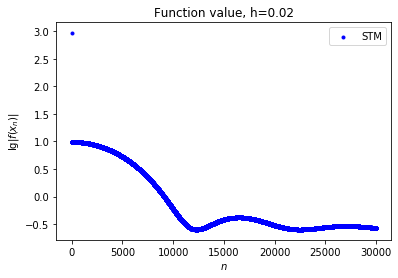

In [10]:
algrun.plot_func('Function value, h=0.02', log=True)

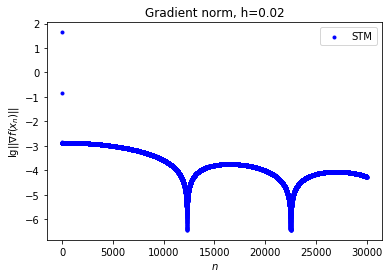

In [11]:
algrun.plot_grads('Gradient norm, h=0.02', log=True)

In [12]:
algrun.print_data()

Experiment 'STM': total time 19851.62779688835 seconds;
gradient called 30001 times, function called 0 times;
minimal gradient norm is 3.7254343691426094e-07, minimal function value is 0.25234776449068985


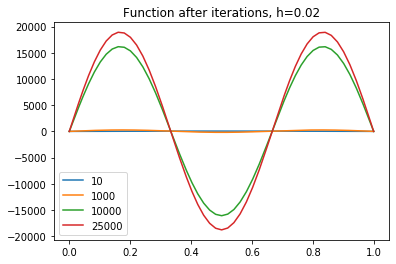

In [16]:
plt.title('Function after iterations, h=0.02')
plt.plot(x, algrun.results['STM']['points'][10], label='10')
plt.plot(x, algrun.results['STM']['points'][1000], label='1000')
plt.plot(x, algrun.results['STM']['points'][10000], label='10000')
plt.plot(x, algrun.results['STM']['points'][25000], label='25000')
plt.legend()